# **What about the minimum dataset for obtaining a satisfying fidelity?**

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

TensorFlow version: 2.11.0


In [2]:
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import kraus_error

In [3]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [4]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [5]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [6]:
#Function which computes the components of the Bloch vector, given the density matrix 

#Here we define the identity matrix and the Pauli matrices for dimension 2 (one qubit)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

In [7]:
sim_bknd=Aer.get_backend('aer_simulator')

In [8]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## (In)Fidelity Implementation

In [9]:
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]

In [10]:
#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [11]:
#function which returns density matrix from bloch components
def rho_from_coeffs(coeffs):
    rho = 0.25 * np.sum([c * p for c,p in zip(coeffs, pauli_basis2q)], axis=0)
    return rho

In [12]:
def fidelity_function(a,b):
  fid = np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

In [13]:
def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b) 
   return fidelity 

In [14]:
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

A = tf.stack([X_tf,Y_tf,Z_tf]) 

In [15]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)

In [16]:
@tf.function
def infidelity2(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Models 

In [17]:
num_qubits = 1

#PROBABILITIES FOR BIT, PHASE, BIT-PHASE FLIP OR DEPOLARIZING ERRORS
p_error = 0.2
    
#PROBABILITIES FOR GENERAL PAULI ERROR
p_0=0.7
p_1=0.2
p_2=0.05
p_3=0.05
    
#PARAMETERS FOR KRAUS ERROR
alpha = np.pi / 3
beta = np.pi / 6
    
A_0 = np.array([[np.cos (alpha), 0], [0, np.cos (beta)]])
A_1 = np.array([[0, np.sin (beta)], [np.sin (alpha), 0]])
Kraus_operators = [A_0, A_1]
    
bit_flip_error = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip_error = pauli_error([('Z', p_error), ('I', 1 - p_error)])
bit_phase_flip_error = pauli_error([('Y', p_error), ('I', 1 - p_error)])
dep_error = depolarizing_error(p_error, num_qubits)
general_pauli_error = pauli_error([('X', p_1), ('Y', p_2), ('Z', p_3), ('I', p_0)])
AD_error = amplitude_damping_error (0.3, 0.5) 
k_error = kraus_error(Kraus_operators)

In [18]:
#applies error whenever an identity gate appears in the circuit (compatibly with the probability errors)
def qsk_add_error(error_type):
    if error_type == 'bit':
        noise_model.add_all_qubit_quantum_error(bit_flip_error, ["id"])
    if error_type == 'phase':
        noise_model.add_all_qubit_quantum_error(phase_flip_error, ["id"])
    if error_type == 'bit-phase':
        noise_model.add_all_qubit_quantum_error(bit_phase_flip_error, ["id"])
    if error_type == 'depolarizing':
        noise_model.add_all_qubit_quantum_error(dep_error, ["id"])
    if error_type == 'Gpauli':
        noise_model.add_all_qubit_quantum_error(general_pauli_error, ["id"])
    if error_type == 'AD':
        noise_model.add_all_qubit_quantum_error(AD_error, ["id"])
    if error_type == 'Kraus':
        noise_model.add_all_qubit_quantum_error(k_error, ["id"])

## Training the Algorithm

In [19]:
# Generate data
data = generate_Haar_data(2, 800) #each state_vector has 4 elements
density_matrix_noise_free = [*map(get_density_matrix, data)] #16 components for each density matrix

In [20]:
num_qubits = 2
den_mat_noise_free = []
den_mat_with_noise = []


for i in range(len(data)):
    #print(f"Sample: {i+1} / {len(data)}")

    circ = qk.QuantumCircuit(num_qubits) 

    circ.initialize(data[i])
    circ = transpile(circ, backend=Aer.get_backend('aer_simulator_density_matrix')) 
    circ.barrier()
    circ.id(0) #applies identity to the first qubit
    circ.id(1) #applies identity to the second qubit
    circ.save_density_matrix()
    #print(circ)
    ideal_bknd = AerSimulator()
    res = ideal_bknd.run(circ).result().data()['density_matrix'] #simulates the circuit and saves the density matrix obtained
    den_noise_free = np.asarray(res)
    den_mat_noise_free.append(den_noise_free)


    noise_model = NoiseModel()
    noise_model.add_quantum_error(phase_flip_error, ["id"], [0])
    noise_model.add_quantum_error(phase_flip_error, ["id"], [1])
    noisy_bknd = AerSimulator(method = 'density_matrix', noise_model=noise_model)
    res_noise = noisy_bknd.run(circ).result().data()['density_matrix']
    den_with_noise = np.asarray(res_noise)
    den_mat_with_noise.append(den_with_noise)

In [21]:
vectors_noise_free = [*map(bloch_coeffs, den_mat_noise_free)]
vectors_with_noise = [*map(bloch_coeffs, den_mat_with_noise)]

## <font color='red'>MSE - 640 samples</font>

In [22]:
x_train_list = vectors_with_noise[:640]
y_train_list = vectors_noise_free[:640]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[640:720]
y_val_list = vectors_noise_free[640:720]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[720:800]
y_test_list = vectors_noise_free[720:800]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [23]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [24]:
# Define Loss
loss_fn = tf.keras.losses.mse

In [25]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [26]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 1s 59ms/step - loss: 0.2127 - val_loss: 0.2054
Epoch 2/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.2079 - val_loss: 0.2011
Epoch 3/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.2033 - val_loss: 0.1972
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1991 - val_loss: 0.1934
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.1952 - val_loss: 0.1898
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1914 - val_loss: 0.1864
Epoch 7/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1877 - val_loss: 0.1831
Epoch 8/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.1843 - val_loss: 0.1798
Epoch 9/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1809 - val_loss: 0.1766
Epoch 10/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.1775 - val_loss: 0.1734
Epoch 11/

5/5 [==============================] - 0s 10ms/step - loss: 0.0080 - val_loss: 0.0092
Epoch 84/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0077 - val_loss: 0.0088
Epoch 85/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 86/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0072 - val_loss: 0.0083
Epoch 87/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0080
Epoch 88/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 89/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0076
Epoch 90/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 91/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 92/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0061 - val_loss: 0.0071
Epoch 93/1000


5/5 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 165/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 166/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 167/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 168/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 169/1000
5/5 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 170/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 171/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 172/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 173/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch

5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 246/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 247/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 248/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 249/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 250/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 251/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 252/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 253/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 254/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch

Epoch 326/1000
5/5 [==============================] - 0s 14ms/step - loss: 9.4529e-04 - val_loss: 0.0014
Epoch 327/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.4271e-04 - val_loss: 0.0014
Epoch 328/1000
5/5 [==============================] - 0s 13ms/step - loss: 9.3852e-04 - val_loss: 0.0014
Epoch 329/1000
5/5 [==============================] - 0s 12ms/step - loss: 9.3275e-04 - val_loss: 0.0014
Epoch 330/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.2805e-04 - val_loss: 0.0014
Epoch 331/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.2235e-04 - val_loss: 0.0014
Epoch 332/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.1633e-04 - val_loss: 0.0014
Epoch 333/1000
5/5 [==============================] - 0s 13ms/step - loss: 9.1306e-04 - val_loss: 0.0013
Epoch 334/1000
5/5 [==============================] - 0s 12ms/step - loss: 9.1099e-04 - val_loss: 0.0013
Epoch 335/1000
5/5 [==============================] - 0

Epoch 404/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.6125e-04 - val_loss: 9.9037e-04
Epoch 405/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.5660e-04 - val_loss: 9.8084e-04
Epoch 406/1000
5/5 [==============================] - 0s 12ms/step - loss: 6.5255e-04 - val_loss: 9.8176e-04
Epoch 407/1000
5/5 [==============================] - 0s 14ms/step - loss: 6.5074e-04 - val_loss: 9.6962e-04
Epoch 408/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.4499e-04 - val_loss: 9.7303e-04
Epoch 409/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.4376e-04 - val_loss: 9.6283e-04
Epoch 410/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.3989e-04 - val_loss: 9.6618e-04
Epoch 411/1000
5/5 [==============================] - 0s 13ms/step - loss: 6.3893e-04 - val_loss: 9.5844e-04
Epoch 412/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.3581e-04 - val_loss: 9.5225e-04
Epoch 413/1000
5/5 

5/5 [==============================] - 0s 14ms/step - loss: 4.7586e-04 - val_loss: 7.1264e-04
Epoch 480/1000
5/5 [==============================] - 0s 11ms/step - loss: 4.7441e-04 - val_loss: 7.1523e-04
Epoch 481/1000
5/5 [==============================] - 0s 12ms/step - loss: 4.7664e-04 - val_loss: 7.0785e-04
Epoch 482/1000
5/5 [==============================] - 0s 13ms/step - loss: 4.7295e-04 - val_loss: 7.0597e-04
Epoch 483/1000
5/5 [==============================] - 0s 12ms/step - loss: 4.6745e-04 - val_loss: 7.0400e-04
Epoch 484/1000
5/5 [==============================] - 0s 14ms/step - loss: 4.6492e-04 - val_loss: 6.9657e-04
Epoch 485/1000
5/5 [==============================] - 0s 11ms/step - loss: 4.6312e-04 - val_loss: 6.9962e-04
Epoch 486/1000
5/5 [==============================] - 0s 11ms/step - loss: 4.6330e-04 - val_loss: 6.9204e-04
Epoch 487/1000
5/5 [==============================] - 0s 11ms/step - loss: 4.5920e-04 - val_loss: 6.9915e-04
Epoch 488/1000
5/5 [==============

5/5 [==============================] - 0s 13ms/step - loss: 3.3972e-04 - val_loss: 5.2305e-04
Epoch 555/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.3795e-04 - val_loss: 5.2140e-04
Epoch 556/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.3780e-04 - val_loss: 5.1985e-04
Epoch 557/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.3742e-04 - val_loss: 5.1608e-04
Epoch 558/1000
5/5 [==============================] - 0s 12ms/step - loss: 3.3571e-04 - val_loss: 5.1645e-04
Epoch 559/1000
5/5 [==============================] - 0s 12ms/step - loss: 3.3370e-04 - val_loss: 5.1358e-04
Epoch 560/1000
5/5 [==============================] - 0s 14ms/step - loss: 3.3273e-04 - val_loss: 5.1453e-04
Epoch 561/1000
5/5 [==============================] - 0s 13ms/step - loss: 3.3089e-04 - val_loss: 5.0807e-04
Epoch 562/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.3040e-04 - val_loss: 5.0737e-04
Epoch 563/1000
5/5 [==============

5/5 [==============================] - 0s 14ms/step - loss: 2.3952e-04 - val_loss: 3.6968e-04
Epoch 630/1000
5/5 [==============================] - 0s 13ms/step - loss: 2.3934e-04 - val_loss: 3.6748e-04
Epoch 631/1000
5/5 [==============================] - 0s 13ms/step - loss: 2.3609e-04 - val_loss: 3.6598e-04
Epoch 632/1000
5/5 [==============================] - 0s 13ms/step - loss: 2.3394e-04 - val_loss: 3.6363e-04
Epoch 633/1000
5/5 [==============================] - 0s 12ms/step - loss: 2.3287e-04 - val_loss: 3.6210e-04
Epoch 634/1000
5/5 [==============================] - 0s 11ms/step - loss: 2.3244e-04 - val_loss: 3.6218e-04
Epoch 635/1000
5/5 [==============================] - 0s 12ms/step - loss: 2.3179e-04 - val_loss: 3.5986e-04
Epoch 636/1000
5/5 [==============================] - 0s 12ms/step - loss: 2.3184e-04 - val_loss: 3.5829e-04
Epoch 637/1000
5/5 [==============================] - 0s 13ms/step - loss: 2.2981e-04 - val_loss: 3.6042e-04
Epoch 638/1000
5/5 [==============

5/5 [==============================] - 0s 12ms/step - loss: 1.5922e-04 - val_loss: 2.5393e-04
Epoch 705/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.5903e-04 - val_loss: 2.5094e-04
Epoch 706/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.5802e-04 - val_loss: 2.5236e-04
Epoch 707/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.5638e-04 - val_loss: 2.4638e-04
Epoch 708/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.5620e-04 - val_loss: 2.4582e-04
Epoch 709/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.5456e-04 - val_loss: 2.4646e-04
Epoch 710/1000
5/5 [==============================] - 0s 13ms/step - loss: 1.5353e-04 - val_loss: 2.4391e-04
Epoch 711/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.5371e-04 - val_loss: 2.4664e-04
Epoch 712/1000
5/5 [==============================] - 0s 12ms/step - loss: 1.5274e-04 - val_loss: 2.3998e-04
Epoch 713/1000
5/5 [==============

5/5 [==============================] - 0s 13ms/step - loss: 1.0165e-04 - val_loss: 1.6433e-04
Epoch 780/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0092e-04 - val_loss: 1.6333e-04
Epoch 781/1000
5/5 [==============================] - 0s 11ms/step - loss: 1.0053e-04 - val_loss: 1.6077e-04
Epoch 782/1000
5/5 [==============================] - 0s 13ms/step - loss: 9.9778e-05 - val_loss: 1.5853e-04
Epoch 783/1000
5/5 [==============================] - 0s 12ms/step - loss: 9.8758e-05 - val_loss: 1.5909e-04
Epoch 784/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.8510e-05 - val_loss: 1.5583e-04
Epoch 785/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.8372e-05 - val_loss: 1.5770e-04
Epoch 786/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.6763e-05 - val_loss: 1.5501e-04
Epoch 787/1000
5/5 [==============================] - 0s 11ms/step - loss: 9.6108e-05 - val_loss: 1.5543e-04
Epoch 788/1000
5/5 [==============

5/5 [==============================] - 0s 12ms/step - loss: 6.4064e-05 - val_loss: 1.0410e-04
Epoch 855/1000
5/5 [==============================] - 0s 15ms/step - loss: 6.3359e-05 - val_loss: 1.0419e-04
Epoch 856/1000
5/5 [==============================] - 0s 13ms/step - loss: 6.3596e-05 - val_loss: 1.0151e-04
Epoch 857/1000
5/5 [==============================] - 0s 12ms/step - loss: 6.3262e-05 - val_loss: 1.0323e-04
Epoch 858/1000
5/5 [==============================] - 0s 13ms/step - loss: 6.2926e-05 - val_loss: 1.0120e-04
Epoch 859/1000
5/5 [==============================] - 0s 13ms/step - loss: 6.1592e-05 - val_loss: 1.0021e-04
Epoch 860/1000
5/5 [==============================] - 0s 12ms/step - loss: 6.2160e-05 - val_loss: 1.0104e-04
Epoch 861/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.1182e-05 - val_loss: 9.9416e-05
Epoch 862/1000
5/5 [==============================] - 0s 11ms/step - loss: 6.0254e-05 - val_loss: 9.8157e-05
Epoch 863/1000
5/5 [==============

5/5 [==============================] - 0s 12ms/step - loss: 4.0825e-05 - val_loss: 6.7954e-05
Epoch 930/1000
5/5 [==============================] - 0s 12ms/step - loss: 3.9357e-05 - val_loss: 6.9065e-05
Epoch 931/1000
5/5 [==============================] - 0s 13ms/step - loss: 3.9832e-05 - val_loss: 6.6776e-05
Epoch 932/1000
5/5 [==============================] - 0s 14ms/step - loss: 3.9082e-05 - val_loss: 6.5723e-05
Epoch 933/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.8378e-05 - val_loss: 6.5945e-05
Epoch 934/1000
5/5 [==============================] - 0s 11ms/step - loss: 3.8080e-05 - val_loss: 6.7000e-05
Epoch 935/1000
5/5 [==============================] - 0s 12ms/step - loss: 3.7610e-05 - val_loss: 6.5955e-05
Epoch 936/1000
5/5 [==============================] - 0s 13ms/step - loss: 3.7536e-05 - val_loss: 6.3859e-05
Epoch 937/1000
5/5 [==============================] - 0s 13ms/step - loss: 3.7176e-05 - val_loss: 6.4196e-05
Epoch 938/1000
5/5 [==============

In [27]:
score = model.evaluate(x_test,  y_test, verbose=2)

3/3 - 0s - loss: 5.2877e-05 - 42ms/epoch - 14ms/step


In [28]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)

 
fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test,x_test)



tm640 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.9976791-2.228262e-12j), shape=(), dtype=complex64)
tf.Tensor((0.7110287+0j), shape=(), dtype=complex64)


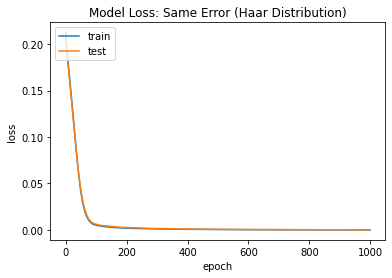

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Error (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 420 samples</font>

In [30]:
x_train_list = vectors_with_noise[:420]
y_train_list = vectors_noise_free[:420]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[640:720]
y_val_list = vectors_noise_free[640:720]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[720:800]
y_test_list = vectors_noise_free[720:800]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [31]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [32]:
# Define Loss
loss_fn = tf.keras.losses.mse

In [33]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [34]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=70, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 1s 44ms/step - loss: 0.2105 - val_loss: 0.2062
Epoch 2/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.2051 - val_loss: 0.2018
Epoch 3/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1999 - val_loss: 0.1975
Epoch 4/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1953 - val_loss: 0.1936
Epoch 5/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1909 - val_loss: 0.1899
Epoch 6/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1868 - val_loss: 0.1862
Epoch 7/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1827 - val_loss: 0.1827
Epoch 8/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1787 - val_loss: 0.1791
Epoch 9/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1748 - val_loss: 0.1756
Epoch 10/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1710 - val_loss: 0.1720
Epoch 11/

6/6 [==============================] - 0s 9ms/step - loss: 0.0064 - val_loss: 0.0079
Epoch 84/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0078
Epoch 85/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 86/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0059 - val_loss: 0.0074
Epoch 87/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 88/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0056 - val_loss: 0.0071
Epoch 89/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 90/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0054 - val_loss: 0.0068
Epoch 91/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 92/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0052 - val_loss: 0.0066
Epoch 93/1000
6/

6/6 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 165/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 166/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 167/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 168/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 169/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 170/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 171/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 172/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 173/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch

6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 246/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 247/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 248/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 249/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 250/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 251/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 252/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 253/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 254/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch

6/6 [==============================] - 0s 12ms/step - loss: 7.6249e-04 - val_loss: 0.0014
Epoch 325/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.5636e-04 - val_loss: 0.0014
Epoch 326/1000
6/6 [==============================] - 0s 11ms/step - loss: 7.5498e-04 - val_loss: 0.0014
Epoch 327/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.4807e-04 - val_loss: 0.0013
Epoch 328/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.4581e-04 - val_loss: 0.0013
Epoch 329/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.4461e-04 - val_loss: 0.0013
Epoch 330/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.4075e-04 - val_loss: 0.0013
Epoch 331/1000
6/6 [==============================] - 0s 14ms/step - loss: 7.3479e-04 - val_loss: 0.0013
Epoch 332/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.3144e-04 - val_loss: 0.0013
Epoch 333/1000
6/6 [==============================] - 0s 12ms/step - l

6/6 [==============================] - 0s 15ms/step - loss: 5.1960e-04 - val_loss: 9.8558e-04
Epoch 403/1000
6/6 [==============================] - 0s 10ms/step - loss: 5.1586e-04 - val_loss: 9.8063e-04
Epoch 404/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.1345e-04 - val_loss: 9.7764e-04
Epoch 405/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.1365e-04 - val_loss: 9.7327e-04
Epoch 406/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.1188e-04 - val_loss: 9.7154e-04
Epoch 407/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.0798e-04 - val_loss: 9.6514e-04
Epoch 408/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.0797e-04 - val_loss: 9.6460e-04
Epoch 409/1000
6/6 [==============================] - 0s 11ms/step - loss: 5.0447e-04 - val_loss: 9.5662e-04
Epoch 410/1000
6/6 [==============================] - 0s 12ms/step - loss: 5.0213e-04 - val_loss: 9.5582e-04
Epoch 411/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 3.6904e-04 - val_loss: 7.3096e-04
Epoch 478/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6729e-04 - val_loss: 7.2438e-04
Epoch 479/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6409e-04 - val_loss: 7.2785e-04
Epoch 480/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.6332e-04 - val_loss: 7.1793e-04
Epoch 481/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.6451e-04 - val_loss: 7.2372e-04
Epoch 482/1000
6/6 [==============================] - 0s 10ms/step - loss: 3.6248e-04 - val_loss: 7.1316e-04
Epoch 483/1000
6/6 [==============================] - 0s 11ms/step - loss: 3.5984e-04 - val_loss: 7.1101e-04
Epoch 484/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.5679e-04 - val_loss: 7.1203e-04
Epoch 485/1000
6/6 [==============================] - 0s 12ms/step - loss: 3.5444e-04 - val_loss: 7.0510e-04
Epoch 486/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 2.5744e-04 - val_loss: 5.2807e-04
Epoch 553/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.5790e-04 - val_loss: 5.2734e-04
Epoch 554/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.5676e-04 - val_loss: 5.1996e-04
Epoch 555/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.5403e-04 - val_loss: 5.2429e-04
Epoch 556/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5259e-04 - val_loss: 5.1209e-04
Epoch 557/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4799e-04 - val_loss: 5.1248e-04
Epoch 558/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4746e-04 - val_loss: 5.0798e-04
Epoch 559/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.4700e-04 - val_loss: 5.1033e-04
Epoch 560/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.4645e-04 - val_loss: 5.0732e-04
Epoch 561/1000
6/6 [==============

6/6 [==============================] - 0s 13ms/step - loss: 1.7562e-04 - val_loss: 3.7193e-04
Epoch 628/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7667e-04 - val_loss: 3.7847e-04
Epoch 629/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7430e-04 - val_loss: 3.7319e-04
Epoch 630/1000
6/6 [==============================] - 0s 10ms/step - loss: 1.7405e-04 - val_loss: 3.6986e-04
Epoch 631/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7407e-04 - val_loss: 3.7336e-04
Epoch 632/1000
6/6 [==============================] - 0s 11ms/step - loss: 1.7294e-04 - val_loss: 3.7495e-04
Epoch 633/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.7215e-04 - val_loss: 3.6400e-04
Epoch 634/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.6838e-04 - val_loss: 3.6567e-04
Epoch 635/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.6675e-04 - val_loss: 3.5882e-04
Epoch 636/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 1.1841e-04 - val_loss: 2.6808e-04
Epoch 703/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1684e-04 - val_loss: 2.7095e-04
Epoch 704/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1628e-04 - val_loss: 2.6432e-04
Epoch 705/1000
6/6 [==============================] - 0s 13ms/step - loss: 1.1545e-04 - val_loss: 2.6070e-04
Epoch 706/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1422e-04 - val_loss: 2.5963e-04
Epoch 707/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1338e-04 - val_loss: 2.6200e-04
Epoch 708/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1364e-04 - val_loss: 2.6164e-04
Epoch 709/1000
6/6 [==============================] - 0s 12ms/step - loss: 1.1227e-04 - val_loss: 2.5437e-04
Epoch 710/1000
6/6 [==============================] - 0s 11ms/step - loss: 1.1104e-04 - val_loss: 2.5509e-04
Epoch 711/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 7.4329e-05 - val_loss: 1.8002e-04
Epoch 778/1000
6/6 [==============================] - 0s 11ms/step - loss: 7.2676e-05 - val_loss: 1.8239e-04
Epoch 779/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.2192e-05 - val_loss: 1.7776e-04
Epoch 780/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.0116e-05 - val_loss: 1.7724e-04
Epoch 781/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.0004e-05 - val_loss: 1.7244e-04
Epoch 782/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.0302e-05 - val_loss: 1.7332e-04
Epoch 783/1000
6/6 [==============================] - 0s 12ms/step - loss: 7.0692e-05 - val_loss: 1.8039e-04
Epoch 784/1000
6/6 [==============================] - 0s 11ms/step - loss: 6.9985e-05 - val_loss: 1.7820e-04
Epoch 785/1000
6/6 [==============================] - 0s 13ms/step - loss: 7.0795e-05 - val_loss: 1.7134e-04
Epoch 786/1000
6/6 [==============

6/6 [==============================] - 0s 12ms/step - loss: 4.3748e-05 - val_loss: 1.2180e-04
Epoch 853/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.3171e-05 - val_loss: 1.2281e-04
Epoch 854/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.3299e-05 - val_loss: 1.2057e-04
Epoch 855/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.1805e-05 - val_loss: 1.1885e-04
Epoch 856/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.1654e-05 - val_loss: 1.1854e-04
Epoch 857/1000
6/6 [==============================] - 0s 12ms/step - loss: 4.1790e-05 - val_loss: 1.1946e-04
Epoch 858/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.2367e-05 - val_loss: 1.1724e-04
Epoch 859/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.1704e-05 - val_loss: 1.1789e-04
Epoch 860/1000
6/6 [==============================] - 0s 11ms/step - loss: 4.1303e-05 - val_loss: 1.1612e-04
Epoch 861/1000
6/6 [==============

6/6 [==============================] - 0s 13ms/step - loss: 2.7691e-05 - val_loss: 8.9373e-05
Epoch 928/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.7607e-05 - val_loss: 8.9683e-05
Epoch 929/1000
6/6 [==============================] - 0s 13ms/step - loss: 2.7493e-05 - val_loss: 9.0790e-05
Epoch 930/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.7531e-05 - val_loss: 8.8331e-05
Epoch 931/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.6974e-05 - val_loss: 8.8349e-05
Epoch 932/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.6941e-05 - val_loss: 8.7447e-05
Epoch 933/1000
6/6 [==============================] - 0s 11ms/step - loss: 2.5756e-05 - val_loss: 8.6660e-05
Epoch 934/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5780e-05 - val_loss: 8.5313e-05
Epoch 935/1000
6/6 [==============================] - 0s 12ms/step - loss: 2.5827e-05 - val_loss: 8.6398e-05
Epoch 936/1000
6/6 [==============

In [35]:
score = model.evaluate(x_test,  y_test, verbose=2)

3/3 - 0s - loss: 5.6728e-05 - 34ms/epoch - 11ms/step


In [36]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)

#print(y_test[0],y_prediction[0]) 
fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test,x_test)


tm420 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.9973283+1.8189894e-13j), shape=(), dtype=complex64)
tf.Tensor((0.7110287+0j), shape=(), dtype=complex64)


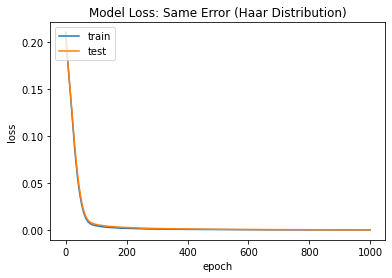

In [37]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Error (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 240 samples</font>

In [38]:
x_train_list = vectors_with_noise[:240]
y_train_list = vectors_noise_free[:240]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[640:720]
y_val_list = vectors_noise_free[640:720]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[720:800]
y_test_list = vectors_noise_free[720:800]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [39]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [40]:
# Define Loss
loss_fn = tf.keras.losses.mse

In [41]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [42]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=40, epochs=1000)

Epoch 1/1000
6/6 [==============================] - 1s 45ms/step - loss: 0.2030 - val_loss: 0.2049
Epoch 2/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1978 - val_loss: 0.2003
Epoch 3/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1931 - val_loss: 0.1961
Epoch 4/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1886 - val_loss: 0.1920
Epoch 5/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1844 - val_loss: 0.1881
Epoch 6/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1803 - val_loss: 0.1844
Epoch 7/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1762 - val_loss: 0.1808
Epoch 8/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.1723 - val_loss: 0.1772
Epoch 9/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.1685 - val_loss: 0.1735
Epoch 10/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.1645 - val_loss: 0.1699
Epoch 11/

6/6 [==============================] - 0s 12ms/step - loss: 0.0075 - val_loss: 0.0116
Epoch 84/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0113
Epoch 85/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0070 - val_loss: 0.0110
Epoch 86/1000
6/6 [==============================] - 0s 13ms/step - loss: 0.0068 - val_loss: 0.0107
Epoch 87/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0066 - val_loss: 0.0104
Epoch 88/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0064 - val_loss: 0.0102
Epoch 89/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0062 - val_loss: 0.0099
Epoch 90/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0097
Epoch 91/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0059 - val_loss: 0.0095
Epoch 92/1000
6/6 [==============================] - 0s 12ms/step - loss: 0.0057 - val_loss: 0.0093
Epoch 93/1000


6/6 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 165/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 166/1000
6/6 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 167/1000
6/6 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 168/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 169/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0050
Epoch 170/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 171/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 172/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0023 - val_loss: 0.0049
Epoch 173/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 174/10

Epoch 246/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 247/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 248/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0014 - val_loss: 0.0036
Epoch 249/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 250/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 251/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 252/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 253/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 254/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 255/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0035


6/6 [==============================] - 0s 8ms/step - loss: 9.0976e-04 - val_loss: 0.0029
Epoch 328/1000
6/6 [==============================] - 0s 8ms/step - loss: 9.0303e-04 - val_loss: 0.0029
Epoch 329/1000
6/6 [==============================] - 0s 9ms/step - loss: 9.0055e-04 - val_loss: 0.0029
Epoch 330/1000
6/6 [==============================] - 0s 8ms/step - loss: 8.9715e-04 - val_loss: 0.0029
Epoch 331/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.9375e-04 - val_loss: 0.0029
Epoch 332/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.9074e-04 - val_loss: 0.0029
Epoch 333/1000
6/6 [==============================] - 0s 8ms/step - loss: 8.8627e-04 - val_loss: 0.0029
Epoch 334/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.8034e-04 - val_loss: 0.0028
Epoch 335/1000
6/6 [==============================] - 0s 9ms/step - loss: 8.7967e-04 - val_loss: 0.0028
Epoch 336/1000
6/6 [==============================] - 0s 8ms/step - loss: 8.731

Epoch 406/1000
6/6 [==============================] - 0s 8ms/step - loss: 6.6075e-04 - val_loss: 0.0024
Epoch 407/1000
6/6 [==============================] - 0s 8ms/step - loss: 6.5658e-04 - val_loss: 0.0024
Epoch 408/1000
6/6 [==============================] - 0s 8ms/step - loss: 6.5718e-04 - val_loss: 0.0024
Epoch 409/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.5204e-04 - val_loss: 0.0024
Epoch 410/1000
6/6 [==============================] - 0s 8ms/step - loss: 6.5364e-04 - val_loss: 0.0024
Epoch 411/1000
6/6 [==============================] - 0s 9ms/step - loss: 6.5037e-04 - val_loss: 0.0024
Epoch 412/1000
6/6 [==============================] - 0s 8ms/step - loss: 6.4669e-04 - val_loss: 0.0024
Epoch 413/1000
6/6 [==============================] - 0s 8ms/step - loss: 6.4861e-04 - val_loss: 0.0024
Epoch 414/1000
6/6 [==============================] - 0s 8ms/step - loss: 6.4150e-04 - val_loss: 0.0024
Epoch 415/1000
6/6 [==============================] - 0s 9ms/ste

Epoch 485/1000
6/6 [==============================] - 0s 8ms/step - loss: 5.0712e-04 - val_loss: 0.0021
Epoch 486/1000
6/6 [==============================] - 0s 9ms/step - loss: 5.0565e-04 - val_loss: 0.0021
Epoch 487/1000
6/6 [==============================] - 0s 8ms/step - loss: 5.0492e-04 - val_loss: 0.0021
Epoch 488/1000
6/6 [==============================] - 0s 8ms/step - loss: 5.0328e-04 - val_loss: 0.0021
Epoch 489/1000
6/6 [==============================] - 0s 8ms/step - loss: 5.0132e-04 - val_loss: 0.0021
Epoch 490/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.9762e-04 - val_loss: 0.0021
Epoch 491/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.9817e-04 - val_loss: 0.0021
Epoch 492/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.9739e-04 - val_loss: 0.0021
Epoch 493/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.9362e-04 - val_loss: 0.0021
Epoch 494/1000
6/6 [==============================] - 0s 9ms/ste

6/6 [==============================] - 0s 9ms/step - loss: 4.0780e-04 - val_loss: 0.0019
Epoch 564/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.0436e-04 - val_loss: 0.0019
Epoch 565/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.0356e-04 - val_loss: 0.0019
Epoch 566/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.0283e-04 - val_loss: 0.0019
Epoch 567/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.0371e-04 - val_loss: 0.0019
Epoch 568/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.0155e-04 - val_loss: 0.0019
Epoch 569/1000
6/6 [==============================] - 0s 9ms/step - loss: 4.0359e-04 - val_loss: 0.0019
Epoch 570/1000
6/6 [==============================] - 0s 8ms/step - loss: 4.0184e-04 - val_loss: 0.0019
Epoch 571/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.9794e-04 - val_loss: 0.0019
Epoch 572/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.989

Epoch 642/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.3347e-04 - val_loss: 0.0017
Epoch 643/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.2992e-04 - val_loss: 0.0017
Epoch 644/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.3084e-04 - val_loss: 0.0017
Epoch 645/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.3037e-04 - val_loss: 0.0017
Epoch 646/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.2993e-04 - val_loss: 0.0017
Epoch 647/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.3187e-04 - val_loss: 0.0017
Epoch 648/1000
6/6 [==============================] - 0s 9ms/step - loss: 3.3079e-04 - val_loss: 0.0017
Epoch 649/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.2449e-04 - val_loss: 0.0017
Epoch 650/1000
6/6 [==============================] - 0s 8ms/step - loss: 3.2419e-04 - val_loss: 0.0017
Epoch 651/1000
6/6 [==============================] - 0s 9ms/ste

6/6 [==============================] - 0s 8ms/step - loss: 2.7626e-04 - val_loss: 0.0016
Epoch 721/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.7610e-04 - val_loss: 0.0016
Epoch 722/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.7654e-04 - val_loss: 0.0016
Epoch 723/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.7440e-04 - val_loss: 0.0016
Epoch 724/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.7353e-04 - val_loss: 0.0016
Epoch 725/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.7420e-04 - val_loss: 0.0016
Epoch 726/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.7380e-04 - val_loss: 0.0016
Epoch 727/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.7387e-04 - val_loss: 0.0016
Epoch 728/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.7950e-04 - val_loss: 0.0016
Epoch 729/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.737

Epoch 799/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.3155e-04 - val_loss: 0.0015
Epoch 800/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.3050e-04 - val_loss: 0.0015
Epoch 801/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.3262e-04 - val_loss: 0.0015
Epoch 802/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.3532e-04 - val_loss: 0.0015
Epoch 803/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.3276e-04 - val_loss: 0.0015
Epoch 804/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.3145e-04 - val_loss: 0.0015
Epoch 805/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.3032e-04 - val_loss: 0.0015
Epoch 806/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.2822e-04 - val_loss: 0.0015
Epoch 807/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.2751e-04 - val_loss: 0.0015
Epoch 808/1000
6/6 [==============================] - 0s 8ms/ste

6/6 [==============================] - 0s 8ms/step - loss: 2.0229e-04 - val_loss: 0.0014
Epoch 878/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.0166e-04 - val_loss: 0.0014
Epoch 879/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.0244e-04 - val_loss: 0.0014
Epoch 880/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.0210e-04 - val_loss: 0.0014
Epoch 881/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.9962e-04 - val_loss: 0.0014
Epoch 882/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.0001e-04 - val_loss: 0.0014
Epoch 883/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.9963e-04 - val_loss: 0.0014
Epoch 884/1000
6/6 [==============================] - 0s 9ms/step - loss: 2.0076e-04 - val_loss: 0.0014
Epoch 885/1000
6/6 [==============================] - 0s 8ms/step - loss: 2.0007e-04 - val_loss: 0.0014
Epoch 886/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.992

Epoch 956/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.7853e-04 - val_loss: 0.0013
Epoch 957/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.8008e-04 - val_loss: 0.0013
Epoch 958/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7909e-04 - val_loss: 0.0013
Epoch 959/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.7784e-04 - val_loss: 0.0013
Epoch 960/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7629e-04 - val_loss: 0.0013
Epoch 961/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7710e-04 - val_loss: 0.0013
Epoch 962/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7452e-04 - val_loss: 0.0013
Epoch 963/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.7316e-04 - val_loss: 0.0013
Epoch 964/1000
6/6 [==============================] - 0s 8ms/step - loss: 1.7442e-04 - val_loss: 0.0013
Epoch 965/1000
6/6 [==============================] - 0s 8ms/ste

In [43]:
score = model.evaluate(x_test,  y_test, verbose=2)

3/3 - 0s - loss: 0.0013 - 104ms/epoch - 35ms/step


In [44]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)

#print(y_test[0],y_prediction[0]) 
fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test,x_test)

tm240 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.9926996-5.820766e-12j), shape=(), dtype=complex64)
tf.Tensor((0.7110287+0j), shape=(), dtype=complex64)


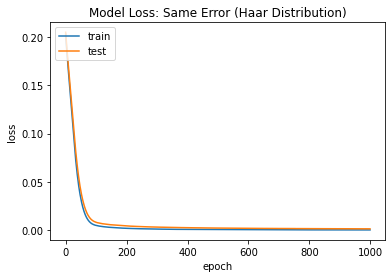

In [45]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Error (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 160 samples</font>

In [46]:
x_train_list = vectors_with_noise[:160]
y_train_list = vectors_noise_free[:160]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[640:720]
y_val_list = vectors_noise_free[640:720]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[720:800]
y_test_list = vectors_noise_free[720:800]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [47]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [48]:
# Define Loss
loss_fn = tf.keras.losses.mse

In [49]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [50]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=40, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 1s 47ms/step - loss: 0.2062 - val_loss: 0.2038
Epoch 2/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.2025 - val_loss: 0.2007
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1990 - val_loss: 0.1977
Epoch 4/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1958 - val_loss: 0.1949
Epoch 5/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1926 - val_loss: 0.1921
Epoch 6/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1896 - val_loss: 0.1895
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1868 - val_loss: 0.1870
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1839 - val_loss: 0.1845
Epoch 9/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1812 - val_loss: 0.1821
Epoch 10/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.1786 - val_loss: 0.1798
Epoch 11/

4/4 [==============================] - 0s 14ms/step - loss: 0.0223 - val_loss: 0.0321
Epoch 84/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0216 - val_loss: 0.0313
Epoch 85/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0210 - val_loss: 0.0306
Epoch 86/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0204 - val_loss: 0.0299
Epoch 87/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0198 - val_loss: 0.0292
Epoch 88/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0192 - val_loss: 0.0285
Epoch 89/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0187 - val_loss: 0.0279
Epoch 90/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0181 - val_loss: 0.0272
Epoch 91/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0176 - val_loss: 0.0266
Epoch 92/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0171 - val_loss: 0.0260
Epoch 93/1000


4/4 [==============================] - 0s 13ms/step - loss: 0.0040 - val_loss: 0.0082
Epoch 165/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0081
Epoch 166/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0038 - val_loss: 0.0081
Epoch 167/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0038 - val_loss: 0.0080
Epoch 168/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0079
Epoch 169/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0079
Epoch 170/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0037 - val_loss: 0.0078
Epoch 171/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0036 - val_loss: 0.0078
Epoch 172/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 173/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0035 - val_loss: 0.0077
Epoch

4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 246/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 247/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 248/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 249/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 250/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 251/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 252/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 253/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0056
Epoch 254/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0056
Epoch

4/4 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 327/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 328/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 329/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 330/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 331/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 332/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 333/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 334/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 335/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch

Epoch 406/1000
4/4 [==============================] - 0s 13ms/step - loss: 8.6150e-04 - val_loss: 0.0043
Epoch 407/1000
4/4 [==============================] - 0s 13ms/step - loss: 8.5489e-04 - val_loss: 0.0043
Epoch 408/1000
4/4 [==============================] - 0s 14ms/step - loss: 8.5116e-04 - val_loss: 0.0042
Epoch 409/1000
4/4 [==============================] - 0s 13ms/step - loss: 8.4964e-04 - val_loss: 0.0042
Epoch 410/1000
4/4 [==============================] - 0s 14ms/step - loss: 8.4709e-04 - val_loss: 0.0043
Epoch 411/1000
4/4 [==============================] - 0s 13ms/step - loss: 8.4274e-04 - val_loss: 0.0042
Epoch 412/1000
4/4 [==============================] - 0s 21ms/step - loss: 8.3665e-04 - val_loss: 0.0042
Epoch 413/1000
4/4 [==============================] - 0s 15ms/step - loss: 8.3440e-04 - val_loss: 0.0042
Epoch 414/1000
4/4 [==============================] - 0s 15ms/step - loss: 8.3174e-04 - val_loss: 0.0042
Epoch 415/1000
4/4 [==============================] - 0

4/4 [==============================] - 0s 12ms/step - loss: 6.4515e-04 - val_loss: 0.0039
Epoch 485/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.4265e-04 - val_loss: 0.0039
Epoch 486/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.4071e-04 - val_loss: 0.0039
Epoch 487/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.3859e-04 - val_loss: 0.0039
Epoch 488/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.3652e-04 - val_loss: 0.0039
Epoch 489/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.3381e-04 - val_loss: 0.0039
Epoch 490/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.3168e-04 - val_loss: 0.0039
Epoch 491/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.3044e-04 - val_loss: 0.0039
Epoch 492/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.2761e-04 - val_loss: 0.0039
Epoch 493/1000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 5.0597e-04 - val_loss: 0.0036
Epoch 563/1000
4/4 [==============================] - 0s 12ms/step - loss: 5.0393e-04 - val_loss: 0.0036
Epoch 564/1000
4/4 [==============================] - 0s 14ms/step - loss: 5.0255e-04 - val_loss: 0.0036
Epoch 565/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.9997e-04 - val_loss: 0.0036
Epoch 566/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.9901e-04 - val_loss: 0.0036
Epoch 567/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.9921e-04 - val_loss: 0.0036
Epoch 568/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.9777e-04 - val_loss: 0.0036
Epoch 569/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.9607e-04 - val_loss: 0.0036
Epoch 570/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.9435e-04 - val_loss: 0.0036
Epoch 571/1000
4/4 [==============================] - 0s 12ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 4.0548e-04 - val_loss: 0.0034
Epoch 641/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.0473e-04 - val_loss: 0.0034
Epoch 642/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.0233e-04 - val_loss: 0.0034
Epoch 643/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.0164e-04 - val_loss: 0.0034
Epoch 644/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.0093e-04 - val_loss: 0.0034
Epoch 645/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.9872e-04 - val_loss: 0.0034
Epoch 646/1000
4/4 [==============================] - 0s 12ms/step - loss: 4.0115e-04 - val_loss: 0.0034
Epoch 647/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.9957e-04 - val_loss: 0.0034
Epoch 648/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.9877e-04 - val_loss: 0.0034
Epoch 649/1000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 3.3346e-04 - val_loss: 0.0033
Epoch 719/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.3062e-04 - val_loss: 0.0033
Epoch 720/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.3247e-04 - val_loss: 0.0033
Epoch 721/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.3211e-04 - val_loss: 0.0033
Epoch 722/1000
4/4 [==============================] - 0s 14ms/step - loss: 3.2798e-04 - val_loss: 0.0033
Epoch 723/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.2705e-04 - val_loss: 0.0033
Epoch 724/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2662e-04 - val_loss: 0.0033
Epoch 725/1000
4/4 [==============================] - 0s 13ms/step - loss: 3.2717e-04 - val_loss: 0.0033
Epoch 726/1000
4/4 [==============================] - 0s 12ms/step - loss: 3.2460e-04 - val_loss: 0.0033
Epoch 727/1000
4/4 [==============================] - 0s 14ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 2.7550e-04 - val_loss: 0.0031
Epoch 797/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7549e-04 - val_loss: 0.0031
Epoch 798/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7522e-04 - val_loss: 0.0032
Epoch 799/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7568e-04 - val_loss: 0.0031
Epoch 800/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7216e-04 - val_loss: 0.0031
Epoch 801/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7270e-04 - val_loss: 0.0031
Epoch 802/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.7098e-04 - val_loss: 0.0031
Epoch 803/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.7267e-04 - val_loss: 0.0031
Epoch 804/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.7115e-04 - val_loss: 0.0031
Epoch 805/1000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 12ms/step - loss: 2.3111e-04 - val_loss: 0.0031
Epoch 875/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3058e-04 - val_loss: 0.0030
Epoch 876/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3139e-04 - val_loss: 0.0030
Epoch 877/1000
4/4 [==============================] - 0s 12ms/step - loss: 2.2978e-04 - val_loss: 0.0030
Epoch 878/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.3043e-04 - val_loss: 0.0030
Epoch 879/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2978e-04 - val_loss: 0.0030
Epoch 880/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2891e-04 - val_loss: 0.0030
Epoch 881/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.2919e-04 - val_loss: 0.0030
Epoch 882/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.2745e-04 - val_loss: 0.0030
Epoch 883/1000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 1.9791e-04 - val_loss: 0.0030
Epoch 953/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9711e-04 - val_loss: 0.0030
Epoch 954/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9729e-04 - val_loss: 0.0030
Epoch 955/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9673e-04 - val_loss: 0.0030
Epoch 956/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9662e-04 - val_loss: 0.0030
Epoch 957/1000
4/4 [==============================] - 0s 12ms/step - loss: 1.9504e-04 - val_loss: 0.0030
Epoch 958/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9602e-04 - val_loss: 0.0030
Epoch 959/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9546e-04 - val_loss: 0.0030
Epoch 960/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9451e-04 - val_loss: 0.0029
Epoch 961/1000
4/4 [==============================] - 0s 14ms/step - l

In [51]:
score = model.evaluate(x_test,  y_test, verbose=2)

3/3 - 0s - loss: 0.0030 - 110ms/epoch - 37ms/step


In [52]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test,x_test)


tm160 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.9826931+5.6024872e-11j), shape=(), dtype=complex64)
tf.Tensor((0.7110287+0j), shape=(), dtype=complex64)


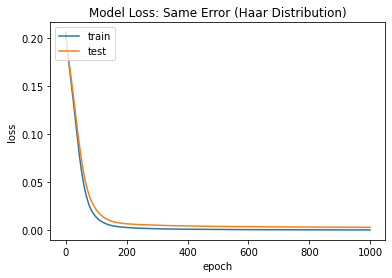

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Error (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 80 samples</font>

In [54]:
x_train_list = vectors_with_noise[:80]
y_train_list = vectors_noise_free[:80]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[640:720]
y_val_list = vectors_noise_free[640:720]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[720:800]
y_test_list = vectors_noise_free[720:800]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [55]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [56]:
# Define Loss
loss_fn = tf.keras.losses.mse

In [57]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [58]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=20, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 1s 49ms/step - loss: 0.2154 - val_loss: 0.2108
Epoch 2/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2111 - val_loss: 0.2080
Epoch 3/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.2069 - val_loss: 0.2053
Epoch 4/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.2032 - val_loss: 0.2029
Epoch 5/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1995 - val_loss: 0.2006
Epoch 6/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1962 - val_loss: 0.1984
Epoch 7/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.1932 - val_loss: 0.1964
Epoch 8/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1903 - val_loss: 0.1944
Epoch 9/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1875 - val_loss: 0.1925
Epoch 10/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.1847 - val_loss: 0.1907
Epoch 11/

4/4 [==============================] - 0s 14ms/step - loss: 0.0384 - val_loss: 0.0628
Epoch 84/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0373 - val_loss: 0.0616
Epoch 85/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0363 - val_loss: 0.0604
Epoch 86/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0353 - val_loss: 0.0593
Epoch 87/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0343 - val_loss: 0.0582
Epoch 88/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0333 - val_loss: 0.0572
Epoch 89/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0324 - val_loss: 0.0562
Epoch 90/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0315 - val_loss: 0.0552
Epoch 91/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0307 - val_loss: 0.0542
Epoch 92/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0299 - val_loss: 0.0532
Epoch 93/1000


4/4 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 0.0181
Epoch 165/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0179
Epoch 166/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0177
Epoch 167/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0176
Epoch 168/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0174
Epoch 169/1000
4/4 [==============================] - 0s 12ms/step - loss: 0.0047 - val_loss: 0.0172
Epoch 170/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0170
Epoch 171/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0045 - val_loss: 0.0169
Epoch 172/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0044 - val_loss: 0.0167
Epoch 173/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0044 - val_loss: 0.0166
Epoch

4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0116
Epoch 246/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0116
Epoch 247/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0115
Epoch 248/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0115
Epoch 249/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 250/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0115
Epoch 251/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0114
Epoch 252/1000
4/4 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0114
Epoch 253/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0114
Epoch 254/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0113
Epoch

4/4 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0102
Epoch 327/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0102
Epoch 328/1000
4/4 [==============================] - 0s 14ms/step - loss: 0.0010 - val_loss: 0.0102
Epoch 329/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0102
Epoch 330/1000
4/4 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 0.0102
Epoch 331/1000
4/4 [==============================] - 0s 14ms/step - loss: 9.9826e-04 - val_loss: 0.0102
Epoch 332/1000
4/4 [==============================] - 0s 14ms/step - loss: 9.9126e-04 - val_loss: 0.0102
Epoch 333/1000
4/4 [==============================] - 0s 13ms/step - loss: 9.9047e-04 - val_loss: 0.0102
Epoch 334/1000
4/4 [==============================] - 0s 13ms/step - loss: 9.7971e-04 - val_loss: 0.0102
Epoch 335/1000
4/4 [==============================] - 0s 15ms/step - loss: 9.7409e-04 - va

4/4 [==============================] - 0s 13ms/step - loss: 6.5002e-04 - val_loss: 0.0097
Epoch 405/1000
4/4 [==============================] - 0s 14ms/step - loss: 6.4645e-04 - val_loss: 0.0097
Epoch 406/1000
4/4 [==============================] - 0s 14ms/step - loss: 6.4440e-04 - val_loss: 0.0097
Epoch 407/1000
4/4 [==============================] - 0s 14ms/step - loss: 6.3860e-04 - val_loss: 0.0097
Epoch 408/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.3532e-04 - val_loss: 0.0097
Epoch 409/1000
4/4 [==============================] - 0s 14ms/step - loss: 6.3444e-04 - val_loss: 0.0097
Epoch 410/1000
4/4 [==============================] - 0s 14ms/step - loss: 6.2873e-04 - val_loss: 0.0096
Epoch 411/1000
4/4 [==============================] - 0s 14ms/step - loss: 6.2766e-04 - val_loss: 0.0097
Epoch 412/1000
4/4 [==============================] - 0s 13ms/step - loss: 6.2206e-04 - val_loss: 0.0096
Epoch 413/1000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 4.3024e-04 - val_loss: 0.0094
Epoch 483/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.2850e-04 - val_loss: 0.0094
Epoch 484/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.2818e-04 - val_loss: 0.0094
Epoch 485/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.2402e-04 - val_loss: 0.0094
Epoch 486/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.2295e-04 - val_loss: 0.0094
Epoch 487/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.2083e-04 - val_loss: 0.0094
Epoch 488/1000
4/4 [==============================] - 0s 13ms/step - loss: 4.1759e-04 - val_loss: 0.0094
Epoch 489/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.1509e-04 - val_loss: 0.0094
Epoch 490/1000
4/4 [==============================] - 0s 14ms/step - loss: 4.1242e-04 - val_loss: 0.0094
Epoch 491/1000
4/4 [==============================] - 0s 14ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 2.8858e-04 - val_loss: 0.0093
Epoch 561/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8791e-04 - val_loss: 0.0093
Epoch 562/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8465e-04 - val_loss: 0.0093
Epoch 563/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8373e-04 - val_loss: 0.0093
Epoch 564/1000
4/4 [==============================] - 0s 13ms/step - loss: 2.8262e-04 - val_loss: 0.0093
Epoch 565/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8058e-04 - val_loss: 0.0093
Epoch 566/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.8049e-04 - val_loss: 0.0093
Epoch 567/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.7909e-04 - val_loss: 0.0093
Epoch 568/1000
4/4 [==============================] - 0s 14ms/step - loss: 2.7640e-04 - val_loss: 0.0092
Epoch 569/1000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 1.9545e-04 - val_loss: 0.0092
Epoch 639/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9361e-04 - val_loss: 0.0092
Epoch 640/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9253e-04 - val_loss: 0.0092
Epoch 641/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.9183e-04 - val_loss: 0.0092
Epoch 642/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9206e-04 - val_loss: 0.0092
Epoch 643/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.9081e-04 - val_loss: 0.0092
Epoch 644/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.8982e-04 - val_loss: 0.0092
Epoch 645/1000
4/4 [==============================] - 0s 14ms/step - loss: 1.8869e-04 - val_loss: 0.0092
Epoch 646/1000
4/4 [==============================] - 0s 13ms/step - loss: 1.8750e-04 - val_loss: 0.0092
Epoch 647/1000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 31ms/step - loss: 1.3408e-04 - val_loss: 0.0092
Epoch 717/1000
4/4 [==============================] - 0s 30ms/step - loss: 1.3296e-04 - val_loss: 0.0092
Epoch 718/1000
4/4 [==============================] - 0s 29ms/step - loss: 1.3221e-04 - val_loss: 0.0092
Epoch 719/1000
4/4 [==============================] - 0s 31ms/step - loss: 1.3166e-04 - val_loss: 0.0092
Epoch 720/1000
4/4 [==============================] - 0s 28ms/step - loss: 1.3160e-04 - val_loss: 0.0092
Epoch 721/1000
4/4 [==============================] - 0s 35ms/step - loss: 1.3011e-04 - val_loss: 0.0092
Epoch 722/1000
4/4 [==============================] - 0s 36ms/step - loss: 1.3022e-04 - val_loss: 0.0092
Epoch 723/1000
4/4 [==============================] - 0s 59ms/step - loss: 1.2989e-04 - val_loss: 0.0092
Epoch 724/1000
4/4 [==============================] - 0s 34ms/step - loss: 1.2936e-04 - val_loss: 0.0092
Epoch 725/1000
4/4 [==============================] - 0s 30ms/step - l

4/4 [==============================] - 0s 25ms/step - loss: 9.0817e-05 - val_loss: 0.0092
Epoch 795/1000
4/4 [==============================] - 0s 27ms/step - loss: 9.1848e-05 - val_loss: 0.0092
Epoch 796/1000
4/4 [==============================] - 0s 32ms/step - loss: 9.0968e-05 - val_loss: 0.0092
Epoch 797/1000
4/4 [==============================] - 0s 26ms/step - loss: 9.0421e-05 - val_loss: 0.0092
Epoch 798/1000
4/4 [==============================] - 0s 27ms/step - loss: 8.9986e-05 - val_loss: 0.0092
Epoch 799/1000
4/4 [==============================] - 0s 27ms/step - loss: 8.9276e-05 - val_loss: 0.0092
Epoch 800/1000
4/4 [==============================] - 0s 24ms/step - loss: 8.8396e-05 - val_loss: 0.0092
Epoch 801/1000
4/4 [==============================] - 0s 25ms/step - loss: 8.8067e-05 - val_loss: 0.0092
Epoch 802/1000
4/4 [==============================] - 0s 26ms/step - loss: 8.7720e-05 - val_loss: 0.0092
Epoch 803/1000
4/4 [==============================] - 0s 25ms/step - l

4/4 [==============================] - 0s 23ms/step - loss: 6.2692e-05 - val_loss: 0.0092
Epoch 873/1000
4/4 [==============================] - 0s 25ms/step - loss: 6.1724e-05 - val_loss: 0.0092
Epoch 874/1000
4/4 [==============================] - 0s 23ms/step - loss: 6.1450e-05 - val_loss: 0.0092
Epoch 875/1000
4/4 [==============================] - 0s 23ms/step - loss: 6.1354e-05 - val_loss: 0.0092
Epoch 876/1000
4/4 [==============================] - 0s 23ms/step - loss: 6.1092e-05 - val_loss: 0.0092
Epoch 877/1000
4/4 [==============================] - 0s 26ms/step - loss: 6.0943e-05 - val_loss: 0.0092
Epoch 878/1000
4/4 [==============================] - 0s 24ms/step - loss: 6.0195e-05 - val_loss: 0.0092
Epoch 879/1000
4/4 [==============================] - 0s 26ms/step - loss: 6.0425e-05 - val_loss: 0.0092
Epoch 880/1000
4/4 [==============================] - 0s 24ms/step - loss: 6.0513e-05 - val_loss: 0.0092
Epoch 881/1000
4/4 [==============================] - 0s 25ms/step - l

4/4 [==============================] - 0s 29ms/step - loss: 4.2881e-05 - val_loss: 0.0092
Epoch 951/1000
4/4 [==============================] - 0s 25ms/step - loss: 4.2469e-05 - val_loss: 0.0092
Epoch 952/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.2057e-05 - val_loss: 0.0092
Epoch 953/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.2137e-05 - val_loss: 0.0092
Epoch 954/1000
4/4 [==============================] - 0s 27ms/step - loss: 4.1978e-05 - val_loss: 0.0092
Epoch 955/1000
4/4 [==============================] - 0s 26ms/step - loss: 4.2083e-05 - val_loss: 0.0092
Epoch 956/1000
4/4 [==============================] - 0s 29ms/step - loss: 4.0960e-05 - val_loss: 0.0092
Epoch 957/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.1354e-05 - val_loss: 0.0092
Epoch 958/1000
4/4 [==============================] - 0s 28ms/step - loss: 4.0981e-05 - val_loss: 0.0092
Epoch 959/1000
4/4 [==============================] - 0s 27ms/step - l

In [59]:
score = model.evaluate(x_test,  y_test, verbose=2)

3/3 - 0s - loss: 0.0084 - 238ms/epoch - 79ms/step


In [60]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test,x_test)


tm80 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.94554883-2.910383e-11j), shape=(), dtype=complex64)
tf.Tensor((0.7110287+0j), shape=(), dtype=complex64)


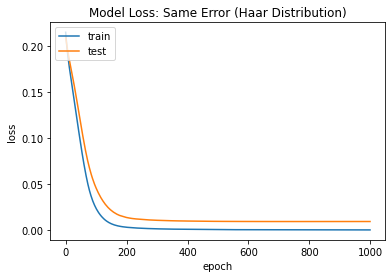

In [61]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Error (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='red'>MSE - 40 samples</font>

In [62]:
x_train_list = vectors_with_noise[:40]
y_train_list = vectors_noise_free[:40]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[640:720]
y_val_list = vectors_noise_free[640:720]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[720:800]
y_test_list = vectors_noise_free[720:800]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [63]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [64]:
# Define Loss
loss_fn = tf.keras.losses.mse

In [65]:
# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [66]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=5, epochs=1000)

Epoch 1/1000
8/8 [==============================] - 2s 44ms/step - loss: 0.2049 - val_loss: 0.2067
Epoch 2/1000
8/8 [==============================] - 0s 14ms/step - loss: 0.1995 - val_loss: 0.2038
Epoch 3/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.1952 - val_loss: 0.2010
Epoch 4/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.1912 - val_loss: 0.1984
Epoch 5/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.1873 - val_loss: 0.1961
Epoch 6/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.1839 - val_loss: 0.1939
Epoch 7/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.1805 - val_loss: 0.1918
Epoch 8/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.1772 - val_loss: 0.1897
Epoch 9/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.1739 - val_loss: 0.1876
Epoch 10/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.1706 - val_loss: 0.1856
Epoch 11/

8/8 [==============================] - 0s 14ms/step - loss: 0.0152 - val_loss: 0.0585
Epoch 84/1000
8/8 [==============================] - 0s 13ms/step - loss: 0.0148 - val_loss: 0.0581
Epoch 85/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.0143 - val_loss: 0.0575
Epoch 86/1000
8/8 [==============================] - 0s 19ms/step - loss: 0.0140 - val_loss: 0.0570
Epoch 87/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.0135 - val_loss: 0.0564
Epoch 88/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0132 - val_loss: 0.0557
Epoch 89/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0129 - val_loss: 0.0552
Epoch 90/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.0125 - val_loss: 0.0546
Epoch 91/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.0543
Epoch 92/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.0118 - val_loss: 0.0537
Epoch 93/1000


8/8 [==============================] - 0s 17ms/step - loss: 0.0019 - val_loss: 0.0321
Epoch 165/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0319
Epoch 166/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0018 - val_loss: 0.0317
Epoch 167/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0315
Epoch 168/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0017 - val_loss: 0.0314
Epoch 169/1000
8/8 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0313
Epoch 170/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0311
Epoch 171/1000
8/8 [==============================] - 0s 15ms/step - loss: 0.0016 - val_loss: 0.0309
Epoch 172/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0308
Epoch 173/1000
8/8 [==============================] - 0s 16ms/step - loss: 0.0015 - val_loss: 0.0306
Epoch

8/8 [==============================] - 0s 15ms/step - loss: 3.4439e-04 - val_loss: 0.0254
Epoch 244/1000
8/8 [==============================] - 0s 16ms/step - loss: 3.3655e-04 - val_loss: 0.0253
Epoch 245/1000
8/8 [==============================] - 0s 14ms/step - loss: 3.3430e-04 - val_loss: 0.0253
Epoch 246/1000
8/8 [==============================] - 0s 14ms/step - loss: 3.2442e-04 - val_loss: 0.0252
Epoch 247/1000
8/8 [==============================] - 0s 15ms/step - loss: 3.2538e-04 - val_loss: 0.0252
Epoch 248/1000
8/8 [==============================] - 0s 13ms/step - loss: 3.1575e-04 - val_loss: 0.0252
Epoch 249/1000
8/8 [==============================] - 0s 13ms/step - loss: 3.1017e-04 - val_loss: 0.0252
Epoch 250/1000
8/8 [==============================] - 0s 15ms/step - loss: 3.0665e-04 - val_loss: 0.0252
Epoch 251/1000
8/8 [==============================] - 0s 15ms/step - loss: 2.9671e-04 - val_loss: 0.0251
Epoch 252/1000
8/8 [==============================] - 0s 13ms/step - l

8/8 [==============================] - 0s 12ms/step - loss: 1.0067e-04 - val_loss: 0.0239
Epoch 322/1000
8/8 [==============================] - 0s 12ms/step - loss: 9.5399e-05 - val_loss: 0.0239
Epoch 323/1000
8/8 [==============================] - 0s 14ms/step - loss: 9.9410e-05 - val_loss: 0.0239
Epoch 324/1000
8/8 [==============================] - 0s 12ms/step - loss: 9.5567e-05 - val_loss: 0.0238
Epoch 325/1000
8/8 [==============================] - 0s 15ms/step - loss: 9.4032e-05 - val_loss: 0.0239
Epoch 326/1000
8/8 [==============================] - 0s 13ms/step - loss: 9.2448e-05 - val_loss: 0.0238
Epoch 327/1000
8/8 [==============================] - 0s 13ms/step - loss: 9.1287e-05 - val_loss: 0.0238
Epoch 328/1000
8/8 [==============================] - 0s 13ms/step - loss: 8.8544e-05 - val_loss: 0.0238
Epoch 329/1000
8/8 [==============================] - 0s 13ms/step - loss: 8.8834e-05 - val_loss: 0.0238
Epoch 330/1000
8/8 [==============================] - 0s 13ms/step - l

8/8 [==============================] - 0s 13ms/step - loss: 3.1605e-05 - val_loss: 0.0233
Epoch 400/1000
8/8 [==============================] - 0s 12ms/step - loss: 3.1146e-05 - val_loss: 0.0233
Epoch 401/1000
8/8 [==============================] - 0s 13ms/step - loss: 3.1057e-05 - val_loss: 0.0232
Epoch 402/1000
8/8 [==============================] - 0s 13ms/step - loss: 3.0747e-05 - val_loss: 0.0233
Epoch 403/1000
8/8 [==============================] - 0s 15ms/step - loss: 2.9735e-05 - val_loss: 0.0232
Epoch 404/1000
8/8 [==============================] - 0s 16ms/step - loss: 3.0326e-05 - val_loss: 0.0233
Epoch 405/1000
8/8 [==============================] - 0s 15ms/step - loss: 2.9658e-05 - val_loss: 0.0232
Epoch 406/1000
8/8 [==============================] - 0s 14ms/step - loss: 2.9142e-05 - val_loss: 0.0232
Epoch 407/1000
8/8 [==============================] - 0s 14ms/step - loss: 2.8061e-05 - val_loss: 0.0232
Epoch 408/1000
8/8 [==============================] - 0s 16ms/step - l

8/8 [==============================] - 0s 13ms/step - loss: 1.0257e-05 - val_loss: 0.0229
Epoch 478/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.1279e-05 - val_loss: 0.0229
Epoch 479/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.1856e-05 - val_loss: 0.0229
Epoch 480/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.1044e-05 - val_loss: 0.0229
Epoch 481/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.0487e-05 - val_loss: 0.0228
Epoch 482/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.0607e-05 - val_loss: 0.0229
Epoch 483/1000
8/8 [==============================] - 0s 18ms/step - loss: 9.5264e-06 - val_loss: 0.0229
Epoch 484/1000
8/8 [==============================] - 0s 18ms/step - loss: 9.7456e-06 - val_loss: 0.0228
Epoch 485/1000
8/8 [==============================] - 0s 18ms/step - loss: 1.0163e-05 - val_loss: 0.0229
Epoch 486/1000
8/8 [==============================] - 0s 17ms/step - l

8/8 [==============================] - 0s 11ms/step - loss: 3.2849e-06 - val_loss: 0.0227
Epoch 556/1000
8/8 [==============================] - 0s 12ms/step - loss: 3.2009e-06 - val_loss: 0.0226
Epoch 557/1000
8/8 [==============================] - 0s 12ms/step - loss: 3.4417e-06 - val_loss: 0.0227
Epoch 558/1000
8/8 [==============================] - 0s 12ms/step - loss: 3.0593e-06 - val_loss: 0.0226
Epoch 559/1000
8/8 [==============================] - 0s 13ms/step - loss: 2.9128e-06 - val_loss: 0.0226
Epoch 560/1000
8/8 [==============================] - 0s 12ms/step - loss: 2.8763e-06 - val_loss: 0.0226
Epoch 561/1000
8/8 [==============================] - 0s 12ms/step - loss: 2.7576e-06 - val_loss: 0.0226
Epoch 562/1000
8/8 [==============================] - 0s 12ms/step - loss: 2.8116e-06 - val_loss: 0.0226
Epoch 563/1000
8/8 [==============================] - 0s 12ms/step - loss: 2.8107e-06 - val_loss: 0.0226
Epoch 564/1000
8/8 [==============================] - 0s 11ms/step - l

8/8 [==============================] - 0s 16ms/step - loss: 8.0922e-07 - val_loss: 0.0225
Epoch 634/1000
8/8 [==============================] - 0s 16ms/step - loss: 7.7998e-07 - val_loss: 0.0225
Epoch 635/1000
8/8 [==============================] - 0s 16ms/step - loss: 8.2558e-07 - val_loss: 0.0225
Epoch 636/1000
8/8 [==============================] - 0s 16ms/step - loss: 8.6037e-07 - val_loss: 0.0225
Epoch 637/1000
8/8 [==============================] - 0s 16ms/step - loss: 7.7436e-07 - val_loss: 0.0225
Epoch 638/1000
8/8 [==============================] - 0s 15ms/step - loss: 7.4851e-07 - val_loss: 0.0225
Epoch 639/1000
8/8 [==============================] - 0s 12ms/step - loss: 7.7700e-07 - val_loss: 0.0225
Epoch 640/1000
8/8 [==============================] - 0s 11ms/step - loss: 7.7177e-07 - val_loss: 0.0225
Epoch 641/1000
8/8 [==============================] - 0s 13ms/step - loss: 8.5352e-07 - val_loss: 0.0225
Epoch 642/1000
8/8 [==============================] - 0s 13ms/step - l

8/8 [==============================] - 0s 13ms/step - loss: 1.6379e-07 - val_loss: 0.0224
Epoch 712/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.4710e-07 - val_loss: 0.0224
Epoch 713/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.4884e-07 - val_loss: 0.0224
Epoch 714/1000
8/8 [==============================] - 0s 16ms/step - loss: 1.1993e-07 - val_loss: 0.0224
Epoch 715/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.1712e-07 - val_loss: 0.0224
Epoch 716/1000
8/8 [==============================] - 0s 14ms/step - loss: 1.2844e-07 - val_loss: 0.0224
Epoch 717/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.5006e-07 - val_loss: 0.0224
Epoch 718/1000
8/8 [==============================] - 0s 15ms/step - loss: 1.5889e-07 - val_loss: 0.0224
Epoch 719/1000
8/8 [==============================] - 0s 17ms/step - loss: 1.3231e-07 - val_loss: 0.0224
Epoch 720/1000
8/8 [==============================] - 0s 15ms/step - l

8/8 [==============================] - 0s 12ms/step - loss: 2.1835e-08 - val_loss: 0.0224
Epoch 790/1000
8/8 [==============================] - 0s 11ms/step - loss: 1.8321e-08 - val_loss: 0.0224
Epoch 791/1000
8/8 [==============================] - 0s 13ms/step - loss: 2.6279e-08 - val_loss: 0.0224
Epoch 792/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.5675e-08 - val_loss: 0.0224
Epoch 793/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.5029e-08 - val_loss: 0.0224
Epoch 794/1000
8/8 [==============================] - 0s 13ms/step - loss: 1.2050e-08 - val_loss: 0.0224
Epoch 795/1000
8/8 [==============================] - 0s 11ms/step - loss: 1.4743e-08 - val_loss: 0.0224
Epoch 796/1000
8/8 [==============================] - 0s 10ms/step - loss: 1.4260e-08 - val_loss: 0.0224
Epoch 797/1000
8/8 [==============================] - 0s 11ms/step - loss: 1.1449e-08 - val_loss: 0.0224
Epoch 798/1000
8/8 [==============================] - 0s 10ms/step - l

8/8 [==============================] - 0s 16ms/step - loss: 6.9673e-09 - val_loss: 0.0224
Epoch 868/1000
8/8 [==============================] - 0s 14ms/step - loss: 7.2125e-09 - val_loss: 0.0224
Epoch 869/1000
8/8 [==============================] - 0s 13ms/step - loss: 7.9839e-09 - val_loss: 0.0224
Epoch 870/1000
8/8 [==============================] - 0s 14ms/step - loss: 7.3826e-09 - val_loss: 0.0224
Epoch 871/1000
8/8 [==============================] - 0s 17ms/step - loss: 8.3761e-09 - val_loss: 0.0224
Epoch 872/1000
8/8 [==============================] - 0s 15ms/step - loss: 8.4807e-09 - val_loss: 0.0224
Epoch 873/1000
8/8 [==============================] - 0s 17ms/step - loss: 8.6506e-09 - val_loss: 0.0224
Epoch 874/1000
8/8 [==============================] - 0s 18ms/step - loss: 7.2894e-09 - val_loss: 0.0224
Epoch 875/1000
8/8 [==============================] - 0s 15ms/step - loss: 7.0241e-09 - val_loss: 0.0224
Epoch 876/1000
8/8 [==============================] - 0s 15ms/step - l

8/8 [==============================] - 0s 10ms/step - loss: 4.6420e-06 - val_loss: 0.0224
Epoch 946/1000
8/8 [==============================] - 0s 13ms/step - loss: 4.3915e-06 - val_loss: 0.0223
Epoch 947/1000
8/8 [==============================] - 0s 12ms/step - loss: 3.5102e-06 - val_loss: 0.0223
Epoch 948/1000
8/8 [==============================] - 0s 10ms/step - loss: 3.8361e-06 - val_loss: 0.0224
Epoch 949/1000
8/8 [==============================] - 0s 13ms/step - loss: 4.3069e-06 - val_loss: 0.0224
Epoch 950/1000
8/8 [==============================] - 0s 11ms/step - loss: 4.4213e-06 - val_loss: 0.0224
Epoch 951/1000
8/8 [==============================] - 0s 12ms/step - loss: 4.0661e-06 - val_loss: 0.0224
Epoch 952/1000
8/8 [==============================] - 0s 12ms/step - loss: 5.4641e-06 - val_loss: 0.0223
Epoch 953/1000
8/8 [==============================] - 0s 17ms/step - loss: 6.5879e-06 - val_loss: 0.0224
Epoch 954/1000
8/8 [==============================] - 0s 15ms/step - l

In [67]:
score = model.evaluate(x_test,  y_test, verbose=2)

3/3 - 0s - loss: 0.0211 - 193ms/epoch - 64ms/step


In [68]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test,x_test)


tm40 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.8735632-1.5133991e-10j), shape=(), dtype=complex64)
tf.Tensor((0.7110287+0j), shape=(), dtype=complex64)


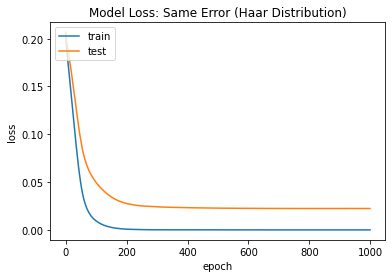

In [69]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Error (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='yellow'>INF - 40 samples</font>

In [70]:
x_train_list = vectors_with_noise[:40]
y_train_list = vectors_noise_free[:40]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[600:700]
y_val_list = vectors_noise_free[600:700]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[700:]
y_test_list = vectors_noise_free[700:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [71]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=infidelity2)

In [72]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=20, epochs=3000)

Epoch 1/3000
2/2 [==============================] - 2s 283ms/step - loss: 0.7430 - val_loss: 0.7807
Epoch 2/3000
2/2 [==============================] - 0s 59ms/step - loss: 0.7254 - val_loss: 0.7722
Epoch 3/3000
2/2 [==============================] - 0s 59ms/step - loss: 0.7084 - val_loss: 0.7634
Epoch 4/3000
2/2 [==============================] - 0s 62ms/step - loss: 0.6932 - val_loss: 0.7548
Epoch 5/3000
2/2 [==============================] - 0s 56ms/step - loss: 0.6770 - val_loss: 0.7461
Epoch 6/3000
2/2 [==============================] - 0s 70ms/step - loss: 0.6610 - val_loss: 0.7375
Epoch 7/3000
2/2 [==============================] - 0s 73ms/step - loss: 0.6459 - val_loss: 0.7289
Epoch 8/3000
2/2 [==============================] - 0s 66ms/step - loss: 0.6304 - val_loss: 0.7203
Epoch 9/3000
2/2 [==============================] - 0s 61ms/step - loss: 0.6149 - val_loss: 0.7116
Epoch 10/3000
2/2 [==============================] - 0s 64ms/step - loss: 0.5990 - val_loss: 0.7028
Epoch 11

2/2 [==============================] - 0s 62ms/step - loss: 0.0633 - val_loss: 0.3147
Epoch 84/3000
2/2 [==============================] - 0s 62ms/step - loss: 0.0619 - val_loss: 0.3130
Epoch 85/3000
2/2 [==============================] - 0s 62ms/step - loss: 0.0603 - val_loss: 0.3115
Epoch 86/3000
2/2 [==============================] - 0s 65ms/step - loss: 0.0589 - val_loss: 0.3101
Epoch 87/3000
2/2 [==============================] - 0s 67ms/step - loss: 0.0576 - val_loss: 0.3087
Epoch 88/3000
2/2 [==============================] - 0s 59ms/step - loss: 0.0562 - val_loss: 0.3073
Epoch 89/3000
2/2 [==============================] - 0s 62ms/step - loss: 0.0548 - val_loss: 0.3060
Epoch 90/3000
2/2 [==============================] - 0s 52ms/step - loss: 0.0536 - val_loss: 0.3048
Epoch 91/3000
2/2 [==============================] - 0s 52ms/step - loss: 0.0524 - val_loss: 0.3036
Epoch 92/3000
2/2 [==============================] - 0s 56ms/step - loss: 0.0513 - val_loss: 0.3025
Epoch 93/3000


2/2 [==============================] - 0s 68ms/step - loss: 0.0147 - val_loss: 0.2696
Epoch 165/3000
2/2 [==============================] - 0s 67ms/step - loss: 0.0145 - val_loss: 0.2695
Epoch 166/3000
2/2 [==============================] - 0s 65ms/step - loss: 0.0143 - val_loss: 0.2693
Epoch 167/3000
2/2 [==============================] - 0s 57ms/step - loss: 0.0141 - val_loss: 0.2691
Epoch 168/3000
2/2 [==============================] - 0s 62ms/step - loss: 0.0139 - val_loss: 0.2689
Epoch 169/3000
2/2 [==============================] - 0s 68ms/step - loss: 0.0137 - val_loss: 0.2687
Epoch 170/3000
2/2 [==============================] - 0s 65ms/step - loss: 0.0135 - val_loss: 0.2686
Epoch 171/3000
2/2 [==============================] - 0s 65ms/step - loss: 0.0133 - val_loss: 0.2684
Epoch 172/3000
2/2 [==============================] - 0s 72ms/step - loss: 0.0131 - val_loss: 0.2683
Epoch 173/3000
2/2 [==============================] - 0s 66ms/step - loss: 0.0129 - val_loss: 0.2681
Epoch

2/2 [==============================] - 0s 62ms/step - loss: 0.0049 - val_loss: 0.2609
Epoch 246/3000
2/2 [==============================] - 0s 67ms/step - loss: 0.0048 - val_loss: 0.2608
Epoch 247/3000
2/2 [==============================] - 0s 81ms/step - loss: 0.0047 - val_loss: 0.2608
Epoch 248/3000
2/2 [==============================] - 0s 72ms/step - loss: 0.0047 - val_loss: 0.2608
Epoch 249/3000
2/2 [==============================] - 0s 67ms/step - loss: 0.0046 - val_loss: 0.2607
Epoch 250/3000
2/2 [==============================] - 0s 67ms/step - loss: 0.0045 - val_loss: 0.2607
Epoch 251/3000
2/2 [==============================] - 0s 70ms/step - loss: 0.0045 - val_loss: 0.2606
Epoch 252/3000
2/2 [==============================] - 0s 64ms/step - loss: 0.0044 - val_loss: 0.2606
Epoch 253/3000
2/2 [==============================] - 0s 71ms/step - loss: 0.0044 - val_loss: 0.2605
Epoch 254/3000
2/2 [==============================] - 0s 64ms/step - loss: 0.0043 - val_loss: 0.2604
Epoch

2/2 [==============================] - 0s 75ms/step - loss: 0.0016 - val_loss: 0.2595
Epoch 327/3000
2/2 [==============================] - 0s 70ms/step - loss: 0.0016 - val_loss: 0.2595
Epoch 328/3000
2/2 [==============================] - 0s 76ms/step - loss: 0.0016 - val_loss: 0.2595
Epoch 329/3000
2/2 [==============================] - 0s 77ms/step - loss: 0.0015 - val_loss: 0.2595
Epoch 330/3000
2/2 [==============================] - 0s 61ms/step - loss: 0.0015 - val_loss: 0.2595
Epoch 331/3000
2/2 [==============================] - 0s 78ms/step - loss: 0.0015 - val_loss: 0.2595
Epoch 332/3000
2/2 [==============================] - 0s 83ms/step - loss: 0.0015 - val_loss: 0.2595
Epoch 333/3000
2/2 [==============================] - 0s 75ms/step - loss: 0.0015 - val_loss: 0.2595
Epoch 334/3000
2/2 [==============================] - 0s 75ms/step - loss: 0.0014 - val_loss: 0.2596
Epoch 335/3000
2/2 [==============================] - 0s 81ms/step - loss: 0.0014 - val_loss: 0.2596
Epoch

2/2 [==============================] - 0s 61ms/step - loss: 5.4353e-04 - val_loss: 0.2605
Epoch 406/3000
2/2 [==============================] - 0s 63ms/step - loss: 5.3840e-04 - val_loss: 0.2605
Epoch 407/3000
2/2 [==============================] - 0s 61ms/step - loss: 5.2931e-04 - val_loss: 0.2605
Epoch 408/3000
2/2 [==============================] - 0s 64ms/step - loss: 5.2283e-04 - val_loss: 0.2605
Epoch 409/3000
2/2 [==============================] - 0s 59ms/step - loss: 5.1568e-04 - val_loss: 0.2605
Epoch 410/3000
2/2 [==============================] - 0s 56ms/step - loss: 5.0924e-04 - val_loss: 0.2606
Epoch 411/3000
2/2 [==============================] - 0s 70ms/step - loss: 5.0166e-04 - val_loss: 0.2606
Epoch 412/3000
2/2 [==============================] - 0s 58ms/step - loss: 4.9569e-04 - val_loss: 0.2606
Epoch 413/3000
2/2 [==============================] - 0s 55ms/step - loss: 4.8823e-04 - val_loss: 0.2606
Epoch 414/3000
2/2 [==============================] - 0s 57ms/step - l

2/2 [==============================] - 0s 61ms/step - loss: 1.9748e-04 - val_loss: 0.2614
Epoch 484/3000
2/2 [==============================] - 0s 58ms/step - loss: 1.9498e-04 - val_loss: 0.2614
Epoch 485/3000
2/2 [==============================] - 0s 54ms/step - loss: 1.9266e-04 - val_loss: 0.2614
Epoch 486/3000
2/2 [==============================] - 0s 62ms/step - loss: 1.8996e-04 - val_loss: 0.2614
Epoch 487/3000
2/2 [==============================] - 0s 61ms/step - loss: 1.8786e-04 - val_loss: 0.2614
Epoch 488/3000
2/2 [==============================] - 0s 52ms/step - loss: 1.8564e-04 - val_loss: 0.2615
Epoch 489/3000
2/2 [==============================] - 0s 61ms/step - loss: 1.8323e-04 - val_loss: 0.2615
Epoch 490/3000
2/2 [==============================] - 0s 56ms/step - loss: 1.8093e-04 - val_loss: 0.2615
Epoch 491/3000
2/2 [==============================] - 0s 59ms/step - loss: 1.7850e-04 - val_loss: 0.2615
Epoch 492/3000
2/2 [==============================] - 0s 66ms/step - l

2/2 [==============================] - 0s 70ms/step - loss: 8.0608e-05 - val_loss: 0.2621
Epoch 562/3000
2/2 [==============================] - 0s 70ms/step - loss: 7.9878e-05 - val_loss: 0.2621
Epoch 563/3000
2/2 [==============================] - 0s 61ms/step - loss: 7.8832e-05 - val_loss: 0.2621
Epoch 564/3000
2/2 [==============================] - 0s 59ms/step - loss: 7.8081e-05 - val_loss: 0.2621
Epoch 565/3000
2/2 [==============================] - 0s 56ms/step - loss: 7.7075e-05 - val_loss: 0.2621
Epoch 566/3000
2/2 [==============================] - 0s 60ms/step - loss: 7.6142e-05 - val_loss: 0.2621
Epoch 567/3000
2/2 [==============================] - 0s 54ms/step - loss: 7.5628e-05 - val_loss: 0.2621
Epoch 568/3000
2/2 [==============================] - 0s 60ms/step - loss: 7.4828e-05 - val_loss: 0.2622
Epoch 569/3000
2/2 [==============================] - 0s 53ms/step - loss: 7.4142e-05 - val_loss: 0.2622
Epoch 570/3000
2/2 [==============================] - 0s 53ms/step - l

2/2 [==============================] - 0s 52ms/step - loss: 3.7321e-05 - val_loss: 0.2625
Epoch 640/3000
2/2 [==============================] - 0s 49ms/step - loss: 3.6915e-05 - val_loss: 0.2625
Epoch 641/3000
2/2 [==============================] - 0s 51ms/step - loss: 3.6582e-05 - val_loss: 0.2625
Epoch 642/3000
2/2 [==============================] - 0s 51ms/step - loss: 3.6174e-05 - val_loss: 0.2625
Epoch 643/3000
2/2 [==============================] - 0s 59ms/step - loss: 3.5827e-05 - val_loss: 0.2625
Epoch 644/3000
2/2 [==============================] - 0s 61ms/step - loss: 3.5544e-05 - val_loss: 0.2625
Epoch 645/3000
2/2 [==============================] - 0s 57ms/step - loss: 3.5158e-05 - val_loss: 0.2625
Epoch 646/3000
2/2 [==============================] - 0s 63ms/step - loss: 3.5121e-05 - val_loss: 0.2625
Epoch 647/3000
2/2 [==============================] - 0s 66ms/step - loss: 3.4694e-05 - val_loss: 0.2625
Epoch 648/3000
2/2 [==============================] - 0s 60ms/step - l

2/2 [==============================] - 0s 62ms/step - loss: 1.8685e-05 - val_loss: 0.2628
Epoch 718/3000
2/2 [==============================] - 0s 59ms/step - loss: 1.8530e-05 - val_loss: 0.2628
Epoch 719/3000
2/2 [==============================] - 0s 52ms/step - loss: 1.8369e-05 - val_loss: 0.2628
Epoch 720/3000
2/2 [==============================] - 0s 50ms/step - loss: 1.8246e-05 - val_loss: 0.2628
Epoch 721/3000
2/2 [==============================] - 0s 57ms/step - loss: 1.8041e-05 - val_loss: 0.2628
Epoch 722/3000
2/2 [==============================] - 0s 51ms/step - loss: 1.7907e-05 - val_loss: 0.2628
Epoch 723/3000
2/2 [==============================] - 0s 55ms/step - loss: 1.7697e-05 - val_loss: 0.2628
Epoch 724/3000
2/2 [==============================] - 0s 57ms/step - loss: 1.7597e-05 - val_loss: 0.2628
Epoch 725/3000
2/2 [==============================] - 0s 53ms/step - loss: 1.7425e-05 - val_loss: 0.2628
Epoch 726/3000
2/2 [==============================] - 0s 59ms/step - l

2/2 [==============================] - 0s 68ms/step - loss: 9.7305e-06 - val_loss: 0.2629
Epoch 796/3000
2/2 [==============================] - 0s 67ms/step - loss: 9.6515e-06 - val_loss: 0.2629
Epoch 797/3000
2/2 [==============================] - 0s 61ms/step - loss: 9.5874e-06 - val_loss: 0.2629
Epoch 798/3000
2/2 [==============================] - 0s 63ms/step - loss: 9.4905e-06 - val_loss: 0.2629
Epoch 799/3000
2/2 [==============================] - 0s 66ms/step - loss: 9.3624e-06 - val_loss: 0.2629
Epoch 800/3000
2/2 [==============================] - 0s 68ms/step - loss: 9.3356e-06 - val_loss: 0.2629
Epoch 801/3000
2/2 [==============================] - 0s 66ms/step - loss: 9.2447e-06 - val_loss: 0.2629
Epoch 802/3000
2/2 [==============================] - 0s 65ms/step - loss: 9.1627e-06 - val_loss: 0.2629
Epoch 803/3000
2/2 [==============================] - 0s 67ms/step - loss: 9.1016e-06 - val_loss: 0.2629
Epoch 804/3000
2/2 [==============================] - 0s 67ms/step - l

2/2 [==============================] - 0s 62ms/step - loss: 5.0962e-06 - val_loss: 0.2630
Epoch 874/3000
2/2 [==============================] - 0s 57ms/step - loss: 5.0440e-06 - val_loss: 0.2630
Epoch 875/3000
2/2 [==============================] - 0s 54ms/step - loss: 4.9725e-06 - val_loss: 0.2630
Epoch 876/3000
2/2 [==============================] - 0s 62ms/step - loss: 4.9397e-06 - val_loss: 0.2630
Epoch 877/3000
2/2 [==============================] - 0s 64ms/step - loss: 4.8965e-06 - val_loss: 0.2631
Epoch 878/3000
2/2 [==============================] - 0s 57ms/step - loss: 4.8712e-06 - val_loss: 0.2631
Epoch 879/3000
2/2 [==============================] - 0s 57ms/step - loss: 4.8220e-06 - val_loss: 0.2631
Epoch 880/3000
2/2 [==============================] - 0s 53ms/step - loss: 4.7818e-06 - val_loss: 0.2631
Epoch 881/3000
2/2 [==============================] - 0s 58ms/step - loss: 4.7371e-06 - val_loss: 0.2631
Epoch 882/3000
2/2 [==============================] - 0s 58ms/step - l

2/2 [==============================] - 0s 56ms/step - loss: 2.6122e-06 - val_loss: 0.2631
Epoch 952/3000
2/2 [==============================] - 0s 61ms/step - loss: 2.5675e-06 - val_loss: 0.2631
Epoch 953/3000
2/2 [==============================] - 0s 64ms/step - loss: 2.5675e-06 - val_loss: 0.2631
Epoch 954/3000
2/2 [==============================] - 0s 73ms/step - loss: 2.5362e-06 - val_loss: 0.2631
Epoch 955/3000
2/2 [==============================] - 0s 65ms/step - loss: 2.5034e-06 - val_loss: 0.2631
Epoch 956/3000
2/2 [==============================] - 0s 56ms/step - loss: 2.4796e-06 - val_loss: 0.2631
Epoch 957/3000
2/2 [==============================] - 0s 58ms/step - loss: 2.4661e-06 - val_loss: 0.2631
Epoch 958/3000
2/2 [==============================] - 0s 54ms/step - loss: 2.4468e-06 - val_loss: 0.2631
Epoch 959/3000
2/2 [==============================] - 0s 59ms/step - loss: 2.4334e-06 - val_loss: 0.2631
Epoch 960/3000
2/2 [==============================] - 0s 57ms/step - l

Epoch 1029/3000
2/2 [==============================] - 0s 55ms/step - loss: 1.2815e-06 - val_loss: 0.2632
Epoch 1030/3000
2/2 [==============================] - 0s 61ms/step - loss: 1.2919e-06 - val_loss: 0.2632
Epoch 1031/3000
2/2 [==============================] - 0s 62ms/step - loss: 1.2696e-06 - val_loss: 0.2632
Epoch 1032/3000
2/2 [==============================] - 0s 51ms/step - loss: 1.2487e-06 - val_loss: 0.2632
Epoch 1033/3000
2/2 [==============================] - 0s 55ms/step - loss: 1.2353e-06 - val_loss: 0.2632
Epoch 1034/3000
2/2 [==============================] - 0s 55ms/step - loss: 1.2383e-06 - val_loss: 0.2632
Epoch 1035/3000
2/2 [==============================] - 0s 51ms/step - loss: 1.2115e-06 - val_loss: 0.2632
Epoch 1036/3000
2/2 [==============================] - 0s 57ms/step - loss: 1.2085e-06 - val_loss: 0.2632
Epoch 1037/3000
2/2 [==============================] - 0s 52ms/step - loss: 1.1876e-06 - val_loss: 0.2632
Epoch 1038/3000
2/2 [=========================

2/2 [==============================] - 0s 56ms/step - loss: 6.2287e-07 - val_loss: 0.2632
Epoch 1107/3000
2/2 [==============================] - 0s 54ms/step - loss: 6.0350e-07 - val_loss: 0.2632
Epoch 1108/3000
2/2 [==============================] - 0s 60ms/step - loss: 5.9754e-07 - val_loss: 0.2632
Epoch 1109/3000
2/2 [==============================] - 0s 55ms/step - loss: 5.9605e-07 - val_loss: 0.2632
Epoch 1110/3000
2/2 [==============================] - 0s 57ms/step - loss: 5.9903e-07 - val_loss: 0.2632
Epoch 1111/3000
2/2 [==============================] - 0s 62ms/step - loss: 5.9307e-07 - val_loss: 0.2632
Epoch 1112/3000
2/2 [==============================] - 0s 67ms/step - loss: 5.8264e-07 - val_loss: 0.2632
Epoch 1113/3000
2/2 [==============================] - 0s 58ms/step - loss: 5.8115e-07 - val_loss: 0.2632
Epoch 1114/3000
2/2 [==============================] - 0s 60ms/step - loss: 5.8711e-07 - val_loss: 0.2632
Epoch 1115/3000
2/2 [==============================] - 0s 59ms

2/2 [==============================] - 0s 66ms/step - loss: 2.8610e-07 - val_loss: 0.2633
Epoch 1184/3000
2/2 [==============================] - 0s 72ms/step - loss: 2.9057e-07 - val_loss: 0.2633
Epoch 1185/3000
2/2 [==============================] - 0s 69ms/step - loss: 2.8014e-07 - val_loss: 0.2633
Epoch 1186/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.8163e-07 - val_loss: 0.2633
Epoch 1187/3000
2/2 [==============================] - 0s 56ms/step - loss: 2.7269e-07 - val_loss: 0.2633
Epoch 1188/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.7269e-07 - val_loss: 0.2633
Epoch 1189/3000
2/2 [==============================] - 0s 66ms/step - loss: 2.8312e-07 - val_loss: 0.2633
Epoch 1190/3000
2/2 [==============================] - 0s 61ms/step - loss: 2.6971e-07 - val_loss: 0.2633
Epoch 1191/3000
2/2 [==============================] - 0s 60ms/step - loss: 2.6822e-07 - val_loss: 0.2633
Epoch 1192/3000
2/2 [==============================] - 0s 68ms

2/2 [==============================] - 0s 47ms/step - loss: 1.2815e-07 - val_loss: 0.2633
Epoch 1261/3000
2/2 [==============================] - 0s 50ms/step - loss: 1.3858e-07 - val_loss: 0.2633
Epoch 1262/3000
2/2 [==============================] - 0s 52ms/step - loss: 1.1474e-07 - val_loss: 0.2633
Epoch 1263/3000
2/2 [==============================] - 0s 57ms/step - loss: 1.3709e-07 - val_loss: 0.2633
Epoch 1264/3000
2/2 [==============================] - 0s 58ms/step - loss: 1.2815e-07 - val_loss: 0.2633
Epoch 1265/3000
2/2 [==============================] - 0s 62ms/step - loss: 1.2517e-07 - val_loss: 0.2633
Epoch 1266/3000
2/2 [==============================] - 0s 59ms/step - loss: 1.3113e-07 - val_loss: 0.2633
Epoch 1267/3000
2/2 [==============================] - 0s 54ms/step - loss: 1.2070e-07 - val_loss: 0.2633
Epoch 1268/3000
2/2 [==============================] - 0s 57ms/step - loss: 1.3560e-07 - val_loss: 0.2633
Epoch 1269/3000
2/2 [==============================] - 0s 54ms

2/2 [==============================] - 0s 52ms/step - loss: 7.3016e-08 - val_loss: 0.2633
Epoch 1338/3000
2/2 [==============================] - 0s 52ms/step - loss: 6.2585e-08 - val_loss: 0.2633
Epoch 1339/3000
2/2 [==============================] - 0s 47ms/step - loss: 6.4075e-08 - val_loss: 0.2633
Epoch 1340/3000
2/2 [==============================] - 0s 51ms/step - loss: 5.6624e-08 - val_loss: 0.2633
Epoch 1341/3000
2/2 [==============================] - 0s 44ms/step - loss: 6.5565e-08 - val_loss: 0.2633
Epoch 1342/3000
2/2 [==============================] - 0s 51ms/step - loss: 5.6624e-08 - val_loss: 0.2633
Epoch 1343/3000
2/2 [==============================] - 0s 49ms/step - loss: 5.8115e-08 - val_loss: 0.2633
Epoch 1344/3000
2/2 [==============================] - 0s 46ms/step - loss: 7.0035e-08 - val_loss: 0.2633
Epoch 1345/3000
2/2 [==============================] - 0s 48ms/step - loss: 6.4075e-08 - val_loss: 0.2633
Epoch 1346/3000
2/2 [==============================] - 0s 54ms

2/2 [==============================] - 0s 58ms/step - loss: 4.9174e-08 - val_loss: 0.2633
Epoch 1415/3000
2/2 [==============================] - 0s 63ms/step - loss: 5.9605e-08 - val_loss: 0.2633
Epoch 1416/3000
2/2 [==============================] - 0s 55ms/step - loss: 3.5763e-08 - val_loss: 0.2633
Epoch 1417/3000
2/2 [==============================] - 0s 52ms/step - loss: 3.7253e-08 - val_loss: 0.2633
Epoch 1418/3000
2/2 [==============================] - 0s 54ms/step - loss: 4.1723e-08 - val_loss: 0.2633
Epoch 1419/3000
2/2 [==============================] - 0s 51ms/step - loss: 4.7684e-08 - val_loss: 0.2633
Epoch 1420/3000
2/2 [==============================] - 0s 56ms/step - loss: 3.2783e-08 - val_loss: 0.2633
Epoch 1421/3000
2/2 [==============================] - 0s 60ms/step - loss: 4.7684e-08 - val_loss: 0.2633
Epoch 1422/3000
2/2 [==============================] - 0s 50ms/step - loss: 5.2154e-08 - val_loss: 0.2633
Epoch 1423/3000
2/2 [==============================] - 0s 60ms

2/2 [==============================] - 0s 52ms/step - loss: 3.8743e-08 - val_loss: 0.2633
Epoch 1492/3000
2/2 [==============================] - 0s 57ms/step - loss: 4.1723e-08 - val_loss: 0.2633
Epoch 1493/3000
2/2 [==============================] - 0s 51ms/step - loss: 4.9174e-08 - val_loss: 0.2633
Epoch 1494/3000
2/2 [==============================] - 0s 55ms/step - loss: 3.4273e-08 - val_loss: 0.2633
Epoch 1495/3000
2/2 [==============================] - 0s 60ms/step - loss: 3.1292e-08 - val_loss: 0.2633
Epoch 1496/3000
2/2 [==============================] - 0s 60ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 1497/3000
2/2 [==============================] - 0s 57ms/step - loss: 4.6194e-08 - val_loss: 0.2633
Epoch 1498/3000
2/2 [==============================] - 0s 52ms/step - loss: 3.7253e-08 - val_loss: 0.2633
Epoch 1499/3000
2/2 [==============================] - 0s 53ms/step - loss: 3.1292e-08 - val_loss: 0.2633
Epoch 1500/3000
2/2 [==============================] - 0s 60ms

2/2 [==============================] - 0s 56ms/step - loss: 4.4703e-08 - val_loss: 0.2633
Epoch 1569/3000
2/2 [==============================] - 0s 54ms/step - loss: 4.1723e-08 - val_loss: 0.2633
Epoch 1570/3000
2/2 [==============================] - 0s 47ms/step - loss: 4.6194e-08 - val_loss: 0.2633
Epoch 1571/3000
2/2 [==============================] - 0s 53ms/step - loss: 3.7253e-08 - val_loss: 0.2633
Epoch 1572/3000
2/2 [==============================] - 0s 55ms/step - loss: 4.1723e-08 - val_loss: 0.2633
Epoch 1573/3000
2/2 [==============================] - 0s 55ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 1574/3000
2/2 [==============================] - 0s 49ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 1575/3000
2/2 [==============================] - 0s 55ms/step - loss: 3.7253e-08 - val_loss: 0.2633
Epoch 1576/3000
2/2 [==============================] - 0s 56ms/step - loss: 3.4273e-08 - val_loss: 0.2633
Epoch 1577/3000
2/2 [==============================] - 0s 57ms

2/2 [==============================] - 0s 76ms/step - loss: 5.0664e-08 - val_loss: 0.2633
Epoch 1646/3000
2/2 [==============================] - 0s 62ms/step - loss: 3.8743e-08 - val_loss: 0.2633
Epoch 1647/3000
2/2 [==============================] - 0s 68ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 1648/3000
2/2 [==============================] - 0s 69ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 1649/3000
2/2 [==============================] - 0s 75ms/step - loss: 8.9407e-09 - val_loss: 0.2633
Epoch 1650/3000
2/2 [==============================] - 0s 68ms/step - loss: 4.3213e-08 - val_loss: 0.2633
Epoch 1651/3000
2/2 [==============================] - 0s 63ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 1652/3000
2/2 [==============================] - 0s 63ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 1653/3000
2/2 [==============================] - 0s 66ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 1654/3000
2/2 [==============================] - 0s 74ms

2/2 [==============================] - 0s 62ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 1723/3000
2/2 [==============================] - 0s 65ms/step - loss: 3.4273e-08 - val_loss: 0.2633
Epoch 1724/3000
2/2 [==============================] - 0s 60ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 1725/3000
2/2 [==============================] - 0s 56ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 1726/3000
2/2 [==============================] - 0s 62ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 1727/3000
2/2 [==============================] - 0s 71ms/step - loss: 1.7881e-08 - val_loss: 0.2633
Epoch 1728/3000
2/2 [==============================] - 0s 92ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 1729/3000
2/2 [==============================] - 0s 75ms/step - loss: 1.1921e-08 - val_loss: 0.2633
Epoch 1730/3000
2/2 [==============================] - 0s 70ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 1731/3000
2/2 [==============================] - 0s 65ms

2/2 [==============================] - 0s 72ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 1800/3000
2/2 [==============================] - 0s 75ms/step - loss: 4.6194e-08 - val_loss: 0.2633
Epoch 1801/3000
2/2 [==============================] - 0s 77ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 1802/3000
2/2 [==============================] - 0s 73ms/step - loss: 3.7253e-08 - val_loss: 0.2633
Epoch 1803/3000
2/2 [==============================] - 0s 80ms/step - loss: 3.2783e-08 - val_loss: 0.2633
Epoch 1804/3000
2/2 [==============================] - 0s 70ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 1805/3000
2/2 [==============================] - 0s 58ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 1806/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 1807/3000
2/2 [==============================] - 0s 63ms/step - loss: 4.0233e-08 - val_loss: 0.2633
Epoch 1808/3000
2/2 [==============================] - 0s 56ms

2/2 [==============================] - 0s 52ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 1877/3000
2/2 [==============================] - 0s 50ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 1878/3000
2/2 [==============================] - 0s 60ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 1879/3000
2/2 [==============================] - 0s 61ms/step - loss: 3.7253e-08 - val_loss: 0.2633
Epoch 1880/3000
2/2 [==============================] - 0s 47ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 1881/3000
2/2 [==============================] - 0s 59ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 1882/3000
2/2 [==============================] - 0s 47ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 1883/3000
2/2 [==============================] - 0s 66ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 1884/3000
2/2 [==============================] - 0s 70ms/step - loss: 3.2783e-08 - val_loss: 0.2633
Epoch 1885/3000
2/2 [==============================] - 0s 53ms

2/2 [==============================] - 0s 52ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 1954/3000
2/2 [==============================] - 0s 48ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 1955/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 1956/3000
2/2 [==============================] - 0s 63ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 1957/3000
2/2 [==============================] - 0s 46ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 1958/3000
2/2 [==============================] - 0s 59ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 1959/3000
2/2 [==============================] - 0s 48ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 1960/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 1961/3000
2/2 [==============================] - 0s 50ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 1962/3000
2/2 [==============================] - 0s 61ms

2/2 [==============================] - 0s 68ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 2031/3000
2/2 [==============================] - 0s 61ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 2032/3000
2/2 [==============================] - 0s 64ms/step - loss: 3.1292e-08 - val_loss: 0.2633
Epoch 2033/3000
2/2 [==============================] - 0s 63ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 2034/3000
2/2 [==============================] - 0s 59ms/step - loss: 3.1292e-08 - val_loss: 0.2633
Epoch 2035/3000
2/2 [==============================] - 0s 66ms/step - loss: 1.6391e-08 - val_loss: 0.2633
Epoch 2036/3000
2/2 [==============================] - 0s 54ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 2037/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 2038/3000
2/2 [==============================] - 0s 60ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 2039/3000
2/2 [==============================] - 0s 52ms

2/2 [==============================] - 0s 41ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 2108/3000
2/2 [==============================] - 0s 46ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 2109/3000
2/2 [==============================] - 0s 52ms/step - loss: 1.6391e-08 - val_loss: 0.2633
Epoch 2110/3000
2/2 [==============================] - 0s 49ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 2111/3000
2/2 [==============================] - 0s 53ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 2112/3000
2/2 [==============================] - 0s 70ms/step - loss: 1.4901e-08 - val_loss: 0.2633
Epoch 2113/3000
2/2 [==============================] - 0s 61ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 2114/3000
2/2 [==============================] - 0s 61ms/step - loss: 1.7881e-08 - val_loss: 0.2633
Epoch 2115/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 2116/3000
2/2 [==============================] - 0s 56ms

2/2 [==============================] - 0s 51ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 2185/3000
2/2 [==============================] - 0s 58ms/step - loss: 1.6391e-08 - val_loss: 0.2633
Epoch 2186/3000
2/2 [==============================] - 0s 53ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 2187/3000
2/2 [==============================] - 0s 73ms/step - loss: 1.6391e-08 - val_loss: 0.2633
Epoch 2188/3000
2/2 [==============================] - 0s 51ms/step - loss: 3.1292e-08 - val_loss: 0.2633
Epoch 2189/3000
2/2 [==============================] - 0s 44ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 2190/3000
2/2 [==============================] - 0s 48ms/step - loss: 1.3411e-08 - val_loss: 0.2633
Epoch 2191/3000
2/2 [==============================] - 0s 51ms/step - loss: 2.3842e-08 - val_loss: 0.2633
Epoch 2192/3000
2/2 [==============================] - 0s 54ms/step - loss: 3.1292e-08 - val_loss: 0.2633
Epoch 2193/3000
2/2 [==============================] - 0s 60ms

2/2 [==============================] - 0s 43ms/step - loss: 1.6391e-08 - val_loss: 0.2633
Epoch 2262/3000
2/2 [==============================] - 0s 49ms/step - loss: 3.1292e-08 - val_loss: 0.2633
Epoch 2263/3000
2/2 [==============================] - 0s 51ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 2264/3000
2/2 [==============================] - 0s 41ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 2265/3000
2/2 [==============================] - 0s 40ms/step - loss: 1.4901e-08 - val_loss: 0.2633
Epoch 2266/3000
2/2 [==============================] - 0s 43ms/step - loss: 1.9372e-08 - val_loss: 0.2633
Epoch 2267/3000
2/2 [==============================] - 0s 44ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 2268/3000
2/2 [==============================] - 0s 47ms/step - loss: 1.1921e-08 - val_loss: 0.2633
Epoch 2269/3000
2/2 [==============================] - 0s 48ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 2270/3000
2/2 [==============================] - 0s 44ms

2/2 [==============================] - 0s 42ms/step - loss: 1.6391e-08 - val_loss: 0.2633
Epoch 2339/3000
2/2 [==============================] - 0s 50ms/step - loss: 3.4273e-08 - val_loss: 0.2633
Epoch 2340/3000
2/2 [==============================] - 0s 43ms/step - loss: 1.4901e-08 - val_loss: 0.2633
Epoch 2341/3000
2/2 [==============================] - 0s 49ms/step - loss: 1.0431e-08 - val_loss: 0.2633
Epoch 2342/3000
2/2 [==============================] - 0s 47ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 2343/3000
2/2 [==============================] - 0s 48ms/step - loss: 4.4703e-09 - val_loss: 0.2633
Epoch 2344/3000
2/2 [==============================] - 0s 49ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 2345/3000
2/2 [==============================] - 0s 43ms/step - loss: 3.4273e-08 - val_loss: 0.2633
Epoch 2346/3000
2/2 [==============================] - 0s 45ms/step - loss: 2.6822e-08 - val_loss: 0.2633
Epoch 2347/3000
2/2 [==============================] - 0s 48ms

2/2 [==============================] - 0s 59ms/step - loss: 2.9802e-08 - val_loss: 0.2633
Epoch 2416/3000
2/2 [==============================] - 0s 54ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 2417/3000
2/2 [==============================] - 0s 55ms/step - loss: 2.5332e-08 - val_loss: 0.2633
Epoch 2418/3000
2/2 [==============================] - 0s 59ms/step - loss: 1.0431e-08 - val_loss: 0.2633
Epoch 2419/3000
2/2 [==============================] - 0s 55ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 2420/3000
2/2 [==============================] - 0s 54ms/step - loss: 3.2783e-08 - val_loss: 0.2633
Epoch 2421/3000
2/2 [==============================] - 0s 57ms/step - loss: 2.8312e-08 - val_loss: 0.2633
Epoch 2422/3000
2/2 [==============================] - 0s 47ms/step - loss: 1.7881e-08 - val_loss: 0.2633
Epoch 2423/3000
2/2 [==============================] - 0s 59ms/step - loss: 1.4901e-08 - val_loss: 0.2633
Epoch 2424/3000
2/2 [==============================] - 0s 56ms

2/2 [==============================] - 0s 60ms/step - loss: 1.3411e-08 - val_loss: 0.2633
Epoch 2493/3000
2/2 [==============================] - 0s 51ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 2494/3000
2/2 [==============================] - 0s 47ms/step - loss: 3.5763e-08 - val_loss: 0.2633
Epoch 2495/3000
2/2 [==============================] - 0s 54ms/step - loss: 2.2352e-08 - val_loss: 0.2633
Epoch 2496/3000
2/2 [==============================] - 0s 54ms/step - loss: 1.0431e-08 - val_loss: 0.2633
Epoch 2497/3000
2/2 [==============================] - 0s 58ms/step - loss: 3.4273e-08 - val_loss: 0.2633
Epoch 2498/3000
2/2 [==============================] - 0s 66ms/step - loss: 1.9372e-08 - val_loss: 0.2633
Epoch 2499/3000
2/2 [==============================] - 0s 53ms/step - loss: 4.0233e-08 - val_loss: 0.2633
Epoch 2500/3000
2/2 [==============================] - 0s 58ms/step - loss: 1.9372e-08 - val_loss: 0.2633
Epoch 2501/3000
2/2 [==============================] - 0s 51ms

2/2 [==============================] - 0s 55ms/step - loss: 3.8743e-08 - val_loss: 0.2633
Epoch 2570/3000
2/2 [==============================] - 0s 57ms/step - loss: 3.8743e-08 - val_loss: 0.2633
Epoch 2571/3000
2/2 [==============================] - 0s 59ms/step - loss: 1.4901e-08 - val_loss: 0.2633
Epoch 2572/3000
2/2 [==============================] - 0s 52ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 2573/3000
2/2 [==============================] - 0s 53ms/step - loss: 2.0862e-08 - val_loss: 0.2633
Epoch 2574/3000
2/2 [==============================] - 0s 50ms/step - loss: 1.0431e-08 - val_loss: 0.2633
Epoch 2575/3000
2/2 [==============================] - 0s 54ms/step - loss: 1.1921e-08 - val_loss: 0.2633
Epoch 2576/3000
2/2 [==============================] - 0s 48ms/step - loss: 1.7881e-08 - val_loss: 0.2633
Epoch 2577/3000
2/2 [==============================] - 0s 72ms/step - loss: 3.7253e-08 - val_loss: 0.2633
Epoch 2578/3000
2/2 [==============================] - 0s 84ms

2/2 [==============================] - 0s 63ms/step - loss: 2.5400e-04 - val_loss: 0.2628
Epoch 2647/3000
2/2 [==============================] - 0s 67ms/step - loss: 2.0957e-04 - val_loss: 0.2632
Epoch 2648/3000
2/2 [==============================] - 0s 63ms/step - loss: 1.8149e-04 - val_loss: 0.2620
Epoch 2649/3000
2/2 [==============================] - 0s 54ms/step - loss: 2.4409e-04 - val_loss: 0.2629
Epoch 2650/3000
2/2 [==============================] - 0s 56ms/step - loss: 2.3356e-04 - val_loss: 0.2621
Epoch 2651/3000
2/2 [==============================] - 0s 60ms/step - loss: 1.7669e-04 - val_loss: 0.2612
Epoch 2652/3000
2/2 [==============================] - 0s 56ms/step - loss: 1.6522e-04 - val_loss: 0.2621
Epoch 2653/3000
2/2 [==============================] - 0s 55ms/step - loss: 2.5671e-04 - val_loss: 0.2619
Epoch 2654/3000
2/2 [==============================] - 0s 59ms/step - loss: 1.9292e-04 - val_loss: 0.2620
Epoch 2655/3000
2/2 [==============================] - 0s 65ms

2/2 [==============================] - 0s 72ms/step - loss: 2.4050e-06 - val_loss: 0.2594
Epoch 2724/3000
2/2 [==============================] - 0s 69ms/step - loss: 1.9804e-06 - val_loss: 0.2595
Epoch 2725/3000
2/2 [==============================] - 0s 67ms/step - loss: 1.8626e-06 - val_loss: 0.2595
Epoch 2726/3000
2/2 [==============================] - 0s 62ms/step - loss: 1.4618e-06 - val_loss: 0.2595
Epoch 2727/3000
2/2 [==============================] - 0s 61ms/step - loss: 1.7151e-06 - val_loss: 0.2595
Epoch 2728/3000
2/2 [==============================] - 0s 65ms/step - loss: 1.5482e-06 - val_loss: 0.2594
Epoch 2729/3000
2/2 [==============================] - 0s 69ms/step - loss: 1.3664e-06 - val_loss: 0.2595
Epoch 2730/3000
2/2 [==============================] - 0s 73ms/step - loss: 1.1042e-06 - val_loss: 0.2595
Epoch 2731/3000
2/2 [==============================] - 0s 58ms/step - loss: 1.4752e-06 - val_loss: 0.2595
Epoch 2732/3000
2/2 [==============================] - 0s 58ms

2/2 [==============================] - 0s 61ms/step - loss: 1.0729e-07 - val_loss: 0.2594
Epoch 2801/3000
2/2 [==============================] - 0s 70ms/step - loss: 1.3858e-07 - val_loss: 0.2594
Epoch 2802/3000
2/2 [==============================] - 0s 71ms/step - loss: 1.4305e-07 - val_loss: 0.2594
Epoch 2803/3000
2/2 [==============================] - 0s 64ms/step - loss: 9.0897e-08 - val_loss: 0.2594
Epoch 2804/3000
2/2 [==============================] - 0s 67ms/step - loss: 1.0729e-07 - val_loss: 0.2594
Epoch 2805/3000
2/2 [==============================] - 0s 74ms/step - loss: 1.1921e-07 - val_loss: 0.2594
Epoch 2806/3000
2/2 [==============================] - 0s 68ms/step - loss: 1.0729e-07 - val_loss: 0.2594
Epoch 2807/3000
2/2 [==============================] - 0s 61ms/step - loss: 7.3016e-08 - val_loss: 0.2594
Epoch 2808/3000
2/2 [==============================] - 0s 60ms/step - loss: 1.1921e-07 - val_loss: 0.2594
Epoch 2809/3000
2/2 [==============================] - 0s 64ms

2/2 [==============================] - 0s 58ms/step - loss: 1.1772e-07 - val_loss: 0.2594
Epoch 2878/3000
2/2 [==============================] - 0s 62ms/step - loss: 6.4075e-08 - val_loss: 0.2594
Epoch 2879/3000
2/2 [==============================] - 0s 62ms/step - loss: 1.1623e-07 - val_loss: 0.2594
Epoch 2880/3000
2/2 [==============================] - 0s 53ms/step - loss: 1.1772e-07 - val_loss: 0.2594
Epoch 2881/3000
2/2 [==============================] - 0s 58ms/step - loss: 9.8348e-08 - val_loss: 0.2594
Epoch 2882/3000
2/2 [==============================] - 0s 55ms/step - loss: 7.7486e-08 - val_loss: 0.2594
Epoch 2883/3000
2/2 [==============================] - 0s 72ms/step - loss: 7.5996e-08 - val_loss: 0.2594
Epoch 2884/3000
2/2 [==============================] - 0s 68ms/step - loss: 9.9838e-08 - val_loss: 0.2594
Epoch 2885/3000
2/2 [==============================] - 0s 64ms/step - loss: 1.0282e-07 - val_loss: 0.2594
Epoch 2886/3000
2/2 [==============================] - 0s 60ms

2/2 [==============================] - 0s 79ms/step - loss: 2.9951e-07 - val_loss: 0.2594
Epoch 2955/3000
2/2 [==============================] - 0s 71ms/step - loss: 3.2634e-07 - val_loss: 0.2594
Epoch 2956/3000
2/2 [==============================] - 0s 72ms/step - loss: 2.8759e-07 - val_loss: 0.2594
Epoch 2957/3000
2/2 [==============================] - 0s 70ms/step - loss: 3.2187e-07 - val_loss: 0.2594
Epoch 2958/3000
2/2 [==============================] - 0s 68ms/step - loss: 3.3081e-07 - val_loss: 0.2594
Epoch 2959/3000
2/2 [==============================] - 0s 66ms/step - loss: 3.3230e-07 - val_loss: 0.2594
Epoch 2960/3000
2/2 [==============================] - 0s 55ms/step - loss: 3.2634e-07 - val_loss: 0.2594
Epoch 2961/3000
2/2 [==============================] - 0s 60ms/step - loss: 3.1739e-07 - val_loss: 0.2594
Epoch 2962/3000
2/2 [==============================] - 0s 62ms/step - loss: 2.6673e-07 - val_loss: 0.2594
Epoch 2963/3000
2/2 [==============================] - 0s 67ms

In [73]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.2499 - 333ms/epoch - 83ms/step


In [74]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test, x_test)



inft40 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.7500589-2.3283065e-11j), shape=(), dtype=complex64)
tf.Tensor((0.7096527+0j), shape=(), dtype=complex64)


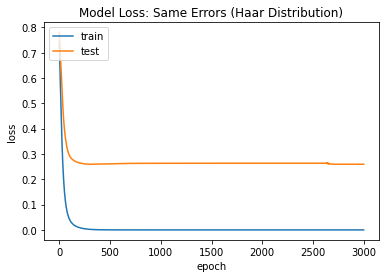

In [75]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Errors (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='yellow'>INF - 80 samples</font>

In [76]:
x_train_list = vectors_with_noise[:80]
y_train_list = vectors_noise_free[:80]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[600:700]
y_val_list = vectors_noise_free[600:700]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[700:]
y_test_list = vectors_noise_free[700:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [77]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=infidelity2)

In [78]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=20, epochs=3000)

Epoch 1/3000
4/4 [==============================] - 2s 105ms/step - loss: 0.7448 - val_loss: 0.6994
Epoch 2/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.7233 - val_loss: 0.6837
Epoch 3/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.7024 - val_loss: 0.6679
Epoch 4/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.6824 - val_loss: 0.6516
Epoch 5/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.6616 - val_loss: 0.6351
Epoch 6/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.6404 - val_loss: 0.6185
Epoch 7/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.6199 - val_loss: 0.6014
Epoch 8/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.5980 - val_loss: 0.5843
Epoch 9/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.5765 - val_loss: 0.5667
Epoch 10/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.5542 - val_loss: 0.5491
Epoch 11

4/4 [==============================] - 0s 23ms/step - loss: 0.0479 - val_loss: 0.1526
Epoch 84/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0468 - val_loss: 0.1514
Epoch 85/3000
4/4 [==============================] - 0s 19ms/step - loss: 0.0458 - val_loss: 0.1504
Epoch 86/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0448 - val_loss: 0.1494
Epoch 87/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0439 - val_loss: 0.1483
Epoch 88/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0429 - val_loss: 0.1473
Epoch 89/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0420 - val_loss: 0.1463
Epoch 90/3000
4/4 [==============================] - 0s 24ms/step - loss: 0.0411 - val_loss: 0.1454
Epoch 91/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0402 - val_loss: 0.1443
Epoch 92/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0394 - val_loss: 0.1433
Epoch 93/3000


4/4 [==============================] - 0s 22ms/step - loss: 0.0114 - val_loss: 0.1114
Epoch 165/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0112 - val_loss: 0.1112
Epoch 166/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0110 - val_loss: 0.1110
Epoch 167/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0109 - val_loss: 0.1108
Epoch 168/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0107 - val_loss: 0.1106
Epoch 169/3000
4/4 [==============================] - 0s 18ms/step - loss: 0.0106 - val_loss: 0.1104
Epoch 170/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0104 - val_loss: 0.1102
Epoch 171/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0103 - val_loss: 0.1100
Epoch 172/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0101 - val_loss: 0.1098
Epoch 173/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0100 - val_loss: 0.1096
Epoch

4/4 [==============================] - 0s 24ms/step - loss: 0.0040 - val_loss: 0.1016
Epoch 246/3000
4/4 [==============================] - 0s 24ms/step - loss: 0.0040 - val_loss: 0.1015
Epoch 247/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0040 - val_loss: 0.1014
Epoch 248/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0039 - val_loss: 0.1013
Epoch 249/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0039 - val_loss: 0.1013
Epoch 250/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0038 - val_loss: 0.1013
Epoch 251/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0038 - val_loss: 0.1012
Epoch 252/3000
4/4 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.1011
Epoch 253/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0037 - val_loss: 0.1010
Epoch 254/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.1009
Epoch

4/4 [==============================] - 0s 21ms/step - loss: 0.0017 - val_loss: 0.0977
Epoch 327/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0017 - val_loss: 0.0977
Epoch 328/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0977
Epoch 329/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0017 - val_loss: 0.0976
Epoch 330/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0017 - val_loss: 0.0976
Epoch 331/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0017 - val_loss: 0.0976
Epoch 332/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0975
Epoch 333/3000
4/4 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0976
Epoch 334/3000
4/4 [==============================] - 0s 19ms/step - loss: 0.0016 - val_loss: 0.0975
Epoch 335/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0016 - val_loss: 0.0975
Epoch

4/4 [==============================] - 0s 19ms/step - loss: 8.1849e-04 - val_loss: 0.0960
Epoch 407/3000
4/4 [==============================] - 0s 21ms/step - loss: 8.1190e-04 - val_loss: 0.0960
Epoch 408/3000
4/4 [==============================] - 0s 20ms/step - loss: 8.0296e-04 - val_loss: 0.0960
Epoch 409/3000
4/4 [==============================] - 0s 21ms/step - loss: 7.9337e-04 - val_loss: 0.0960
Epoch 410/3000
4/4 [==============================] - 0s 20ms/step - loss: 7.8684e-04 - val_loss: 0.0959
Epoch 411/3000
4/4 [==============================] - 0s 20ms/step - loss: 7.7978e-04 - val_loss: 0.0959
Epoch 412/3000
4/4 [==============================] - 0s 21ms/step - loss: 7.7217e-04 - val_loss: 0.0959
Epoch 413/3000
4/4 [==============================] - 0s 20ms/step - loss: 7.6635e-04 - val_loss: 0.0959
Epoch 414/3000
4/4 [==============================] - 0s 21ms/step - loss: 7.5877e-04 - val_loss: 0.0959
Epoch 415/3000
4/4 [==============================] - 0s 21ms/step - l

4/4 [==============================] - 0s 24ms/step - loss: 4.0096e-04 - val_loss: 0.0950
Epoch 485/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.9703e-04 - val_loss: 0.0950
Epoch 486/3000
4/4 [==============================] - 0s 22ms/step - loss: 3.9378e-04 - val_loss: 0.0950
Epoch 487/3000
4/4 [==============================] - 0s 22ms/step - loss: 3.9129e-04 - val_loss: 0.0950
Epoch 488/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.8711e-04 - val_loss: 0.0950
Epoch 489/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.8409e-04 - val_loss: 0.0950
Epoch 490/3000
4/4 [==============================] - 0s 26ms/step - loss: 3.8176e-04 - val_loss: 0.0950
Epoch 491/3000
4/4 [==============================] - 0s 27ms/step - loss: 3.7794e-04 - val_loss: 0.0949
Epoch 492/3000
4/4 [==============================] - 0s 27ms/step - loss: 3.7451e-04 - val_loss: 0.0949
Epoch 493/3000
4/4 [==============================] - 0s 26ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 2.0318e-04 - val_loss: 0.0944
Epoch 563/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.0235e-04 - val_loss: 0.0944
Epoch 564/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.0003e-04 - val_loss: 0.0944
Epoch 565/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.9955e-04 - val_loss: 0.0944
Epoch 566/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.9705e-04 - val_loss: 0.0944
Epoch 567/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.9498e-04 - val_loss: 0.0944
Epoch 568/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.9393e-04 - val_loss: 0.0944
Epoch 569/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.9150e-04 - val_loss: 0.0944
Epoch 570/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.8970e-04 - val_loss: 0.0944
Epoch 571/3000
4/4 [==============================] - 0s 16ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 1.0467e-04 - val_loss: 0.0940
Epoch 641/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.0483e-04 - val_loss: 0.0940
Epoch 642/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.0328e-04 - val_loss: 0.0940
Epoch 643/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.0131e-04 - val_loss: 0.0940
Epoch 644/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.0145e-04 - val_loss: 0.0940
Epoch 645/3000
4/4 [==============================] - 0s 20ms/step - loss: 9.9591e-05 - val_loss: 0.0940
Epoch 646/3000
4/4 [==============================] - 0s 18ms/step - loss: 9.9339e-05 - val_loss: 0.0940
Epoch 647/3000
4/4 [==============================] - 0s 19ms/step - loss: 9.8068e-05 - val_loss: 0.0940
Epoch 648/3000
4/4 [==============================] - 0s 18ms/step - loss: 9.7121e-05 - val_loss: 0.0940
Epoch 649/3000
4/4 [==============================] - 0s 19ms/step - l

4/4 [==============================] - 0s 21ms/step - loss: 5.3660e-05 - val_loss: 0.0938
Epoch 719/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.2502e-05 - val_loss: 0.0938
Epoch 720/3000
4/4 [==============================] - 0s 19ms/step - loss: 5.1889e-05 - val_loss: 0.0938
Epoch 721/3000
4/4 [==============================] - 0s 20ms/step - loss: 5.0992e-05 - val_loss: 0.0938
Epoch 722/3000
4/4 [==============================] - 0s 20ms/step - loss: 5.1223e-05 - val_loss: 0.0938
Epoch 723/3000
4/4 [==============================] - 0s 21ms/step - loss: 5.0323e-05 - val_loss: 0.0937
Epoch 724/3000
4/4 [==============================] - 0s 21ms/step - loss: 4.9689e-05 - val_loss: 0.0937
Epoch 725/3000
4/4 [==============================] - 0s 20ms/step - loss: 5.0203e-05 - val_loss: 0.0938
Epoch 726/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.9598e-05 - val_loss: 0.0937
Epoch 727/3000
4/4 [==============================] - 0s 21ms/step - l

4/4 [==============================] - 0s 20ms/step - loss: 2.5699e-05 - val_loss: 0.0936
Epoch 797/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.5257e-05 - val_loss: 0.0936
Epoch 798/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.5391e-05 - val_loss: 0.0936
Epoch 799/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.4917e-05 - val_loss: 0.0936
Epoch 800/3000
4/4 [==============================] - 0s 22ms/step - loss: 2.4451e-05 - val_loss: 0.0936
Epoch 801/3000
4/4 [==============================] - 0s 23ms/step - loss: 2.4392e-05 - val_loss: 0.0936
Epoch 802/3000
4/4 [==============================] - 0s 21ms/step - loss: 2.4230e-05 - val_loss: 0.0936
Epoch 803/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.3701e-05 - val_loss: 0.0936
Epoch 804/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.3387e-05 - val_loss: 0.0936
Epoch 805/3000
4/4 [==============================] - 0s 19ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 1.1732e-05 - val_loss: 0.0935
Epoch 875/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.1724e-05 - val_loss: 0.0935
Epoch 876/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.1490e-05 - val_loss: 0.0935
Epoch 877/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.1524e-05 - val_loss: 0.0935
Epoch 878/3000
4/4 [==============================] - 0s 21ms/step - loss: 1.1449e-05 - val_loss: 0.0935
Epoch 879/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.1408e-05 - val_loss: 0.0935
Epoch 880/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.1505e-05 - val_loss: 0.0935
Epoch 881/3000
4/4 [==============================] - 0s 22ms/step - loss: 1.1178e-05 - val_loss: 0.0935
Epoch 882/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.0981e-05 - val_loss: 0.0935
Epoch 883/3000
4/4 [==============================] - 0s 21ms/step - l

4/4 [==============================] - 0s 18ms/step - loss: 5.2266e-06 - val_loss: 0.0934
Epoch 953/3000
4/4 [==============================] - 0s 19ms/step - loss: 5.2445e-06 - val_loss: 0.0935
Epoch 954/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.1893e-06 - val_loss: 0.0934
Epoch 955/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.2951e-06 - val_loss: 0.0934
Epoch 956/3000
4/4 [==============================] - 0s 21ms/step - loss: 5.1416e-06 - val_loss: 0.0934
Epoch 957/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.2512e-06 - val_loss: 0.0934
Epoch 958/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.0485e-06 - val_loss: 0.0934
Epoch 959/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.8175e-06 - val_loss: 0.0934
Epoch 960/3000
4/4 [==============================] - 0s 21ms/step - loss: 4.9762e-06 - val_loss: 0.0934
Epoch 961/3000
4/4 [==============================] - 0s 19ms/step - l

Epoch 1030/3000
4/4 [==============================] - 0s 22ms/step - loss: 2.2292e-06 - val_loss: 0.0934
Epoch 1031/3000
4/4 [==============================] - 0s 22ms/step - loss: 2.1413e-06 - val_loss: 0.0934
Epoch 1032/3000
4/4 [==============================] - 0s 23ms/step - loss: 2.1026e-06 - val_loss: 0.0934
Epoch 1033/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.0921e-06 - val_loss: 0.0934
Epoch 1034/3000
4/4 [==============================] - 0s 22ms/step - loss: 2.0698e-06 - val_loss: 0.0934
Epoch 1035/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.0437e-06 - val_loss: 0.0934
Epoch 1036/3000
4/4 [==============================] - 0s 23ms/step - loss: 2.0161e-06 - val_loss: 0.0934
Epoch 1037/3000
4/4 [==============================] - 0s 21ms/step - loss: 1.9744e-06 - val_loss: 0.0934
Epoch 1038/3000
4/4 [==============================] - 0s 24ms/step - loss: 1.9349e-06 - val_loss: 0.0934
Epoch 1039/3000
4/4 [=========================

4/4 [==============================] - 0s 19ms/step - loss: 8.7172e-07 - val_loss: 0.0934
Epoch 1108/3000
4/4 [==============================] - 0s 20ms/step - loss: 8.3447e-07 - val_loss: 0.0934
Epoch 1109/3000
4/4 [==============================] - 0s 20ms/step - loss: 8.3223e-07 - val_loss: 0.0934
Epoch 1110/3000
4/4 [==============================] - 0s 19ms/step - loss: 8.3968e-07 - val_loss: 0.0934
Epoch 1111/3000
4/4 [==============================] - 0s 21ms/step - loss: 8.1733e-07 - val_loss: 0.0934
Epoch 1112/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.0243e-07 - val_loss: 0.0934
Epoch 1113/3000
4/4 [==============================] - 0s 23ms/step - loss: 8.4788e-07 - val_loss: 0.0934
Epoch 1114/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.2850e-07 - val_loss: 0.0934
Epoch 1115/3000
4/4 [==============================] - 0s 19ms/step - loss: 8.1584e-07 - val_loss: 0.0934
Epoch 1116/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 24ms/step - loss: 4.3213e-07 - val_loss: 0.0934
Epoch 1185/3000
4/4 [==============================] - 0s 21ms/step - loss: 4.1872e-07 - val_loss: 0.0934
Epoch 1186/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.0680e-07 - val_loss: 0.0934
Epoch 1187/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.2378e-07 - val_loss: 0.0934
Epoch 1188/3000
4/4 [==============================] - 0s 23ms/step - loss: 5.9903e-07 - val_loss: 0.0934
Epoch 1189/3000
4/4 [==============================] - 0s 24ms/step - loss: 6.2138e-07 - val_loss: 0.0934
Epoch 1190/3000
4/4 [==============================] - 0s 24ms/step - loss: 6.2436e-07 - val_loss: 0.0934
Epoch 1191/3000
4/4 [==============================] - 0s 22ms/step - loss: 5.8860e-07 - val_loss: 0.0934
Epoch 1192/3000
4/4 [==============================] - 0s 20ms/step - loss: 5.8115e-07 - val_loss: 0.0934
Epoch 1193/3000
4/4 [==============================] - 0s 22ms

4/4 [==============================] - 0s 19ms/step - loss: 5.6997e-07 - val_loss: 0.0934
Epoch 1262/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.8950e-07 - val_loss: 0.0934
Epoch 1263/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.4927e-07 - val_loss: 0.0934
Epoch 1264/3000
4/4 [==============================] - 0s 15ms/step - loss: 4.1574e-07 - val_loss: 0.0934
Epoch 1265/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.3230e-07 - val_loss: 0.0934
Epoch 1266/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.5390e-07 - val_loss: 0.0934
Epoch 1267/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.6657e-07 - val_loss: 0.0934
Epoch 1268/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.3677e-07 - val_loss: 0.0934
Epoch 1269/3000
4/4 [==============================] - 0s 15ms/step - loss: 3.6508e-07 - val_loss: 0.0934
Epoch 1270/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 18ms/step - loss: 7.5251e-08 - val_loss: 0.0934
Epoch 1339/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.8231e-08 - val_loss: 0.0934
Epoch 1340/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.3330e-08 - val_loss: 0.0934
Epoch 1341/3000
4/4 [==============================] - 0s 16ms/step - loss: 6.9290e-08 - val_loss: 0.0934
Epoch 1342/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.3447e-08 - val_loss: 0.0934
Epoch 1343/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.1526e-08 - val_loss: 0.0934
Epoch 1344/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.1956e-08 - val_loss: 0.0934
Epoch 1345/3000
4/4 [==============================] - 0s 18ms/step - loss: 9.1642e-08 - val_loss: 0.0934
Epoch 1346/3000
4/4 [==============================] - 0s 17ms/step - loss: 9.2387e-08 - val_loss: 0.0934
Epoch 1347/3000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 17ms/step - loss: 7.9292e-05 - val_loss: 0.0932
Epoch 1416/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.7303e-05 - val_loss: 0.0934
Epoch 1417/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.5559e-05 - val_loss: 0.0934
Epoch 1418/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.1570e-05 - val_loss: 0.0932
Epoch 1419/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.7758e-05 - val_loss: 0.0932
Epoch 1420/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.0787e-05 - val_loss: 0.0932
Epoch 1421/3000
4/4 [==============================] - 0s 15ms/step - loss: 7.4099e-05 - val_loss: 0.0933
Epoch 1422/3000
4/4 [==============================] - 0s 15ms/step - loss: 7.6228e-05 - val_loss: 0.0931
Epoch 1423/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.2725e-04 - val_loss: 0.0931
Epoch 1424/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 15ms/step - loss: 5.0664e-07 - val_loss: 0.0921
Epoch 1493/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.5986e-07 - val_loss: 0.0921
Epoch 1494/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.8520e-07 - val_loss: 0.0921
Epoch 1495/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.4869e-07 - val_loss: 0.0921
Epoch 1496/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.8536e-07 - val_loss: 0.0921
Epoch 1497/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.3171e-07 - val_loss: 0.0921
Epoch 1498/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.2575e-07 - val_loss: 0.0921
Epoch 1499/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.6987e-07 - val_loss: 0.0921
Epoch 1500/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.7956e-07 - val_loss: 0.0921
Epoch 1501/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 20ms/step - loss: 3.7998e-08 - val_loss: 0.0921
Epoch 1570/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.9802e-08 - val_loss: 0.0921
Epoch 1571/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.3528e-08 - val_loss: 0.0921
Epoch 1572/3000
4/4 [==============================] - 0s 21ms/step - loss: 4.0233e-08 - val_loss: 0.0921
Epoch 1573/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.6508e-08 - val_loss: 0.0921
Epoch 1574/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.6508e-08 - val_loss: 0.0921
Epoch 1575/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.2037e-08 - val_loss: 0.0921
Epoch 1576/3000
4/4 [==============================] - 0s 22ms/step - loss: 2.7567e-08 - val_loss: 0.0921
Epoch 1577/3000
4/4 [==============================] - 0s 21ms/step - loss: 1.9372e-08 - val_loss: 0.0921
Epoch 1578/3000
4/4 [==============================] - 0s 23ms

4/4 [==============================] - 0s 19ms/step - loss: 4.8429e-08 - val_loss: 0.0921
Epoch 1647/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.1723e-08 - val_loss: 0.0921
Epoch 1648/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.6508e-08 - val_loss: 0.0921
Epoch 1649/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.5763e-08 - val_loss: 0.0921
Epoch 1650/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.2468e-08 - val_loss: 0.0921
Epoch 1651/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.4273e-08 - val_loss: 0.0921
Epoch 1652/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.4703e-08 - val_loss: 0.0921
Epoch 1653/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.3958e-08 - val_loss: 0.0921
Epoch 1654/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.5018e-08 - val_loss: 0.0921
Epoch 1655/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 18ms/step - loss: 3.1060e-05 - val_loss: 0.0920
Epoch 1724/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.4220e-05 - val_loss: 0.0918
Epoch 1725/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.9419e-05 - val_loss: 0.0919
Epoch 1726/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.1092e-05 - val_loss: 0.0920
Epoch 1727/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.0925e-05 - val_loss: 0.0917
Epoch 1728/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.4971e-05 - val_loss: 0.0920
Epoch 1729/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.2410e-05 - val_loss: 0.0918
Epoch 1730/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.1425e-05 - val_loss: 0.0919
Epoch 1731/3000
4/4 [==============================] - 0s 20ms/step - loss: 5.2308e-05 - val_loss: 0.0918
Epoch 1732/3000
4/4 [==============================] - 0s 20ms

4/4 [==============================] - 0s 18ms/step - loss: 3.0961e-05 - val_loss: 0.0905
Epoch 1801/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.7147e-05 - val_loss: 0.0905
Epoch 1802/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.4206e-05 - val_loss: 0.0904
Epoch 1803/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.8330e-05 - val_loss: 0.0903
Epoch 1804/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.0706e-05 - val_loss: 0.0904
Epoch 1805/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.4951e-05 - val_loss: 0.0903
Epoch 1806/3000
4/4 [==============================] - 0s 20ms/step - loss: 2.4106e-05 - val_loss: 0.0903
Epoch 1807/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.9269e-05 - val_loss: 0.0902
Epoch 1808/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.4761e-05 - val_loss: 0.0903
Epoch 1809/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 20ms/step - loss: 1.0281e-05 - val_loss: 0.0902
Epoch 1878/3000
4/4 [==============================] - 0s 20ms/step - loss: 9.6589e-06 - val_loss: 0.0903
Epoch 1879/3000
4/4 [==============================] - 0s 18ms/step - loss: 9.9972e-06 - val_loss: 0.0901
Epoch 1880/3000
4/4 [==============================] - 0s 19ms/step - loss: 8.6084e-06 - val_loss: 0.0902
Epoch 1881/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.4975e-06 - val_loss: 0.0903
Epoch 1882/3000
4/4 [==============================] - 0s 16ms/step - loss: 6.5878e-06 - val_loss: 0.0902
Epoch 1883/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.0930e-06 - val_loss: 0.0902
Epoch 1884/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.9609e-06 - val_loss: 0.0902
Epoch 1885/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.2572e-05 - val_loss: 0.0903
Epoch 1886/3000
4/4 [==============================] - 0s 24ms

4/4 [==============================] - 0s 19ms/step - loss: 2.6678e-05 - val_loss: 0.0900
Epoch 1955/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.6739e-05 - val_loss: 0.0898
Epoch 1956/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.2888e-05 - val_loss: 0.0899
Epoch 1957/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.0711e-05 - val_loss: 0.0899
Epoch 1958/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.0533e-05 - val_loss: 0.0900
Epoch 1959/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.2064e-05 - val_loss: 0.0901
Epoch 1960/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.4883e-05 - val_loss: 0.0899
Epoch 1961/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.6671e-05 - val_loss: 0.0899
Epoch 1962/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.5718e-05 - val_loss: 0.0899
Epoch 1963/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 18ms/step - loss: 9.5069e-06 - val_loss: 0.0888
Epoch 2032/3000
4/4 [==============================] - 0s 19ms/step - loss: 8.8692e-06 - val_loss: 0.0889
Epoch 2033/3000
4/4 [==============================] - 0s 19ms/step - loss: 7.2606e-06 - val_loss: 0.0888
Epoch 2034/3000
4/4 [==============================] - 0s 19ms/step - loss: 6.8769e-06 - val_loss: 0.0890
Epoch 2035/3000
4/4 [==============================] - 0s 19ms/step - loss: 7.7322e-06 - val_loss: 0.0889
Epoch 2036/3000
4/4 [==============================] - 0s 19ms/step - loss: 8.6933e-06 - val_loss: 0.0889
Epoch 2037/3000
4/4 [==============================] - 0s 19ms/step - loss: 9.8757e-06 - val_loss: 0.0889
Epoch 2038/3000
4/4 [==============================] - 0s 19ms/step - loss: 9.7156e-06 - val_loss: 0.0889
Epoch 2039/3000
4/4 [==============================] - 0s 18ms/step - loss: 9.0495e-06 - val_loss: 0.0889
Epoch 2040/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 18ms/step - loss: 4.0913e-05 - val_loss: 0.0882
Epoch 2109/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.3330e-05 - val_loss: 0.0882
Epoch 2110/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.8442e-05 - val_loss: 0.0883
Epoch 2111/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.6752e-05 - val_loss: 0.0880
Epoch 2112/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.8852e-05 - val_loss: 0.0883
Epoch 2113/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.8375e-05 - val_loss: 0.0883
Epoch 2114/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.8290e-05 - val_loss: 0.0883
Epoch 2115/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.9946e-05 - val_loss: 0.0881
Epoch 2116/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.7154e-05 - val_loss: 0.0882
Epoch 2117/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 20ms/step - loss: 3.6761e-06 - val_loss: 0.0880
Epoch 2186/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.9905e-06 - val_loss: 0.0880
Epoch 2187/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.9406e-06 - val_loss: 0.0880
Epoch 2188/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.4586e-06 - val_loss: 0.0879
Epoch 2189/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.9114e-06 - val_loss: 0.0880
Epoch 2190/3000
4/4 [==============================] - 0s 23ms/step - loss: 4.3482e-06 - val_loss: 0.0879
Epoch 2191/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.4206e-06 - val_loss: 0.0879
Epoch 2192/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.4153e-06 - val_loss: 0.0879
Epoch 2193/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.0828e-06 - val_loss: 0.0880
Epoch 2194/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 18ms/step - loss: 4.4855e-05 - val_loss: 0.0879
Epoch 2263/3000
4/4 [==============================] - 0s 22ms/step - loss: 5.5549e-05 - val_loss: 0.0875
Epoch 2264/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.6170e-05 - val_loss: 0.0875
Epoch 2265/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.6342e-05 - val_loss: 0.0879
Epoch 2266/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.1988e-05 - val_loss: 0.0874
Epoch 2267/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.3828e-05 - val_loss: 0.0878
Epoch 2268/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.8648e-05 - val_loss: 0.0875
Epoch 2269/3000
4/4 [==============================] - 0s 17ms/step - loss: 9.5450e-05 - val_loss: 0.0874
Epoch 2270/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.9311e-05 - val_loss: 0.0874
Epoch 2271/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 15ms/step - loss: 2.8867e-05 - val_loss: 0.0869
Epoch 2340/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.3654e-05 - val_loss: 0.0869
Epoch 2341/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.8654e-05 - val_loss: 0.0871
Epoch 2342/3000
4/4 [==============================] - 0s 21ms/step - loss: 4.6641e-05 - val_loss: 0.0870
Epoch 2343/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.5155e-05 - val_loss: 0.0869
Epoch 2344/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.7916e-05 - val_loss: 0.0870
Epoch 2345/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.3393e-05 - val_loss: 0.0872
Epoch 2346/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.8906e-05 - val_loss: 0.0870
Epoch 2347/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.8807e-05 - val_loss: 0.0870
Epoch 2348/3000
4/4 [==============================] - 0s 20ms

4/4 [==============================] - 0s 18ms/step - loss: 1.0922e-05 - val_loss: 0.0866
Epoch 2417/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.3058e-05 - val_loss: 0.0866
Epoch 2418/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.1063e-05 - val_loss: 0.0867
Epoch 2419/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.1467e-05 - val_loss: 0.0865
Epoch 2420/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.0411e-05 - val_loss: 0.0865
Epoch 2421/3000
4/4 [==============================] - 0s 21ms/step - loss: 1.1695e-05 - val_loss: 0.0867
Epoch 2422/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.2054e-05 - val_loss: 0.0866
Epoch 2423/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.1554e-05 - val_loss: 0.0865
Epoch 2424/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.2077e-05 - val_loss: 0.0866
Epoch 2425/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 24ms/step - loss: 4.3570e-05 - val_loss: 0.0858
Epoch 2494/3000
4/4 [==============================] - 0s 20ms/step - loss: 5.1475e-05 - val_loss: 0.0855
Epoch 2495/3000
4/4 [==============================] - 0s 20ms/step - loss: 5.1112e-05 - val_loss: 0.0857
Epoch 2496/3000
4/4 [==============================] - 0s 19ms/step - loss: 5.1209e-05 - val_loss: 0.0855
Epoch 2497/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.4344e-05 - val_loss: 0.0857
Epoch 2498/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.7410e-05 - val_loss: 0.0857
Epoch 2499/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.6474e-05 - val_loss: 0.0858
Epoch 2500/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.5974e-05 - val_loss: 0.0855
Epoch 2501/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.5878e-05 - val_loss: 0.0856
Epoch 2502/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 18ms/step - loss: 6.1624e-06 - val_loss: 0.0852
Epoch 2571/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.9024e-06 - val_loss: 0.0851
Epoch 2572/3000
4/4 [==============================] - 0s 19ms/step - loss: 5.0060e-06 - val_loss: 0.0852
Epoch 2573/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.2468e-06 - val_loss: 0.0851
Epoch 2574/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.4250e-06 - val_loss: 0.0851
Epoch 2575/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.8847e-06 - val_loss: 0.0852
Epoch 2576/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.8832e-06 - val_loss: 0.0851
Epoch 2577/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.8631e-06 - val_loss: 0.0852
Epoch 2578/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.8855e-06 - val_loss: 0.0851
Epoch 2579/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 14ms/step - loss: 1.7948e-05 - val_loss: 0.0849
Epoch 2648/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.5208e-05 - val_loss: 0.0848
Epoch 2649/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.7503e-05 - val_loss: 0.0850
Epoch 2650/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.9807e-05 - val_loss: 0.0848
Epoch 2651/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.1556e-05 - val_loss: 0.0848
Epoch 2652/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.7827e-05 - val_loss: 0.0850
Epoch 2653/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.1026e-05 - val_loss: 0.0849
Epoch 2654/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.8078e-05 - val_loss: 0.0848
Epoch 2655/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.5308e-05 - val_loss: 0.0849
Epoch 2656/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 5.7130e-05 - val_loss: 0.0843
Epoch 2725/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.6671e-05 - val_loss: 0.0843
Epoch 2726/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.6416e-05 - val_loss: 0.0841
Epoch 2727/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.6485e-05 - val_loss: 0.0842
Epoch 2728/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.3750e-05 - val_loss: 0.0843
Epoch 2729/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.1095e-05 - val_loss: 0.0842
Epoch 2730/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.2740e-05 - val_loss: 0.0843
Epoch 2731/3000
4/4 [==============================] - 0s 19ms/step - loss: 5.5430e-05 - val_loss: 0.0841
Epoch 2732/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.3678e-05 - val_loss: 0.0842
Epoch 2733/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 13ms/step - loss: 4.8507e-05 - val_loss: 0.0837
Epoch 2802/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.7193e-05 - val_loss: 0.0835
Epoch 2803/3000
4/4 [==============================] - 0s 13ms/step - loss: 5.2340e-05 - val_loss: 0.0835
Epoch 2804/3000
4/4 [==============================] - 0s 13ms/step - loss: 4.3146e-05 - val_loss: 0.0836
Epoch 2805/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.0890e-05 - val_loss: 0.0836
Epoch 2806/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.1637e-05 - val_loss: 0.0837
Epoch 2807/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.6488e-05 - val_loss: 0.0835
Epoch 2808/3000
4/4 [==============================] - 0s 15ms/step - loss: 4.1257e-05 - val_loss: 0.0837
Epoch 2809/3000
4/4 [==============================] - 0s 13ms/step - loss: 4.4897e-05 - val_loss: 0.0836
Epoch 2810/3000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 14ms/step - loss: 4.5405e-05 - val_loss: 0.0832
Epoch 2879/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.1687e-05 - val_loss: 0.0831
Epoch 2880/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.4512e-05 - val_loss: 0.0830
Epoch 2881/3000
4/4 [==============================] - 0s 13ms/step - loss: 3.3119e-05 - val_loss: 0.0831
Epoch 2882/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.7065e-05 - val_loss: 0.0830
Epoch 2883/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.8607e-05 - val_loss: 0.0830
Epoch 2884/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.7481e-05 - val_loss: 0.0830
Epoch 2885/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.5234e-05 - val_loss: 0.0831
Epoch 2886/3000
4/4 [==============================] - 0s 13ms/step - loss: 1.2714e-05 - val_loss: 0.0829
Epoch 2887/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 14ms/step - loss: 6.1125e-06 - val_loss: 0.0829
Epoch 2956/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.2451e-06 - val_loss: 0.0829
Epoch 2957/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.6289e-06 - val_loss: 0.0829
Epoch 2958/3000
4/4 [==============================] - 0s 13ms/step - loss: 4.7445e-06 - val_loss: 0.0829
Epoch 2959/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.9406e-06 - val_loss: 0.0829
Epoch 2960/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.4009e-06 - val_loss: 0.0830
Epoch 2961/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.2662e-06 - val_loss: 0.0830
Epoch 2962/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.3906e-06 - val_loss: 0.0829
Epoch 2963/3000
4/4 [==============================] - 0s 13ms/step - loss: 4.3646e-06 - val_loss: 0.0829
Epoch 2964/3000
4/4 [==============================] - 0s 14ms

In [79]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.0855 - 130ms/epoch - 33ms/step


In [80]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test, x_test)



inft80 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.91452074-1.6298145e-10j), shape=(), dtype=complex64)
tf.Tensor((0.7096527+0j), shape=(), dtype=complex64)


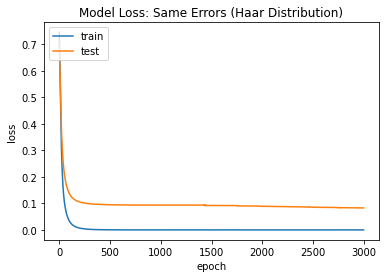

In [81]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Errors (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='yellow'>INF - 240 samples</font>

In [82]:
x_train_list = vectors_with_noise[:240]
y_train_list = vectors_noise_free[:240]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[600:700]
y_val_list = vectors_noise_free[600:700]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[700:]
y_test_list = vectors_noise_free[700:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [83]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=infidelity2)

In [84]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=60, epochs=3000)

Epoch 1/3000
4/4 [==============================] - 1s 57ms/step - loss: 0.7941 - val_loss: 0.7683
Epoch 2/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.7704 - val_loss: 0.7513
Epoch 3/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.7486 - val_loss: 0.7349
Epoch 4/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.7274 - val_loss: 0.7189
Epoch 5/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.7069 - val_loss: 0.7030
Epoch 6/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.6861 - val_loss: 0.6865
Epoch 7/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.6650 - val_loss: 0.6694
Epoch 8/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.6441 - val_loss: 0.6518
Epoch 9/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.6220 - val_loss: 0.6331
Epoch 10/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.5990 - val_loss: 0.6136
Epoch 11/

4/4 [==============================] - 0s 15ms/step - loss: 0.0392 - val_loss: 0.0727
Epoch 84/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0385 - val_loss: 0.0718
Epoch 85/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0378 - val_loss: 0.0709
Epoch 86/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0372 - val_loss: 0.0702
Epoch 87/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0366 - val_loss: 0.0693
Epoch 88/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0359 - val_loss: 0.0685
Epoch 89/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0353 - val_loss: 0.0678
Epoch 90/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0348 - val_loss: 0.0670
Epoch 91/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0342 - val_loss: 0.0662
Epoch 92/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0337 - val_loss: 0.0654
Epoch 93/3000


4/4 [==============================] - 0s 14ms/step - loss: 0.0148 - val_loss: 0.0390
Epoch 165/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0146 - val_loss: 0.0388
Epoch 166/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0145 - val_loss: 0.0387
Epoch 167/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0144 - val_loss: 0.0385
Epoch 168/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0143 - val_loss: 0.0383
Epoch 169/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0142 - val_loss: 0.0381
Epoch 170/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0141 - val_loss: 0.0379
Epoch 171/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0139 - val_loss: 0.0377
Epoch 172/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0138 - val_loss: 0.0376
Epoch 173/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0137 - val_loss: 0.0374
Epoch

4/4 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0291
Epoch 246/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0084 - val_loss: 0.0290
Epoch 247/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0083 - val_loss: 0.0289
Epoch 248/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0083 - val_loss: 0.0288
Epoch 249/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0287
Epoch 250/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0082 - val_loss: 0.0287
Epoch 251/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0286
Epoch 252/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0081 - val_loss: 0.0285
Epoch 253/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0080 - val_loss: 0.0284
Epoch 254/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0080 - val_loss: 0.0284
Epoch

4/4 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0239
Epoch 327/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0238
Epoch 328/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0237
Epoch 329/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0055 - val_loss: 0.0237
Epoch 330/3000
4/4 [==============================] - 0s 24ms/step - loss: 0.0055 - val_loss: 0.0237
Epoch 331/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0236
Epoch 332/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0235
Epoch 333/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0054 - val_loss: 0.0235
Epoch 334/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0235
Epoch 335/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0235
Epoch

4/4 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0208
Epoch 408/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0208
Epoch 409/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0208
Epoch 410/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0208
Epoch 411/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0039 - val_loss: 0.0207
Epoch 412/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0039 - val_loss: 0.0207
Epoch 413/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0207
Epoch 414/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0038 - val_loss: 0.0206
Epoch 415/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0038 - val_loss: 0.0206
Epoch 416/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0038 - val_loss: 0.0206
Epoch

4/4 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0190
Epoch 489/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0190
Epoch 490/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0190
Epoch 491/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0030 - val_loss: 0.0189
Epoch 492/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0189
Epoch 493/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.0189
Epoch 494/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0189
Epoch 495/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.0188
Epoch 496/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.0188
Epoch 497/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0188
Epoch

4/4 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0177
Epoch 570/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0177
Epoch 571/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0177
Epoch 572/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0177
Epoch 573/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0177
Epoch 574/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 575/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 576/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 577/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch 578/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0176
Epoch

4/4 [==============================] - 0s 15ms/step - loss: 0.0019 - val_loss: 0.0167
Epoch 651/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0167
Epoch 652/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0167
Epoch 653/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0019 - val_loss: 0.0167
Epoch 654/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0167
Epoch 655/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0167
Epoch 656/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0167
Epoch 657/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0018 - val_loss: 0.0166
Epoch 658/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0018 - val_loss: 0.0166
Epoch 659/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0018 - val_loss: 0.0166
Epoch

4/4 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 732/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 733/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 734/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 735/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 736/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 737/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0158
Epoch 738/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 739/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0159
Epoch 740/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0158
Epoch

4/4 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 0.0153
Epoch 813/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0153
Epoch 814/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss: 0.0154
Epoch 815/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 816/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 817/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 818/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 819/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 820/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch 821/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 0.0153
Epoch

4/4 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0150
Epoch 894/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0150
Epoch 895/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 896/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 897/3000
4/4 [==============================] - 0s 18ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 898/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 899/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 900/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 901/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch 902/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0010 - val_loss: 0.0149
Epoch

Epoch 972/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.7467e-04 - val_loss: 0.0146
Epoch 973/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.7198e-04 - val_loss: 0.0146
Epoch 974/3000
4/4 [==============================] - 0s 17ms/step - loss: 8.7228e-04 - val_loss: 0.0146
Epoch 975/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.6715e-04 - val_loss: 0.0146
Epoch 976/3000
4/4 [==============================] - 0s 14ms/step - loss: 8.6196e-04 - val_loss: 0.0146
Epoch 977/3000
4/4 [==============================] - 0s 22ms/step - loss: 8.6777e-04 - val_loss: 0.0146
Epoch 978/3000
4/4 [==============================] - 0s 17ms/step - loss: 8.6192e-04 - val_loss: 0.0146
Epoch 979/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.5960e-04 - val_loss: 0.0146
Epoch 980/3000
4/4 [==============================] - 0s 17ms/step - loss: 8.5692e-04 - val_loss: 0.0146
Epoch 981/3000
4/4 [==============================] - 0

4/4 [==============================] - 0s 18ms/step - loss: 7.4034e-04 - val_loss: 0.0143
Epoch 1050/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.4065e-04 - val_loss: 0.0143
Epoch 1051/3000
4/4 [==============================] - 0s 15ms/step - loss: 7.3760e-04 - val_loss: 0.0144
Epoch 1052/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.3355e-04 - val_loss: 0.0143
Epoch 1053/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.3577e-04 - val_loss: 0.0143
Epoch 1054/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.3071e-04 - val_loss: 0.0143
Epoch 1055/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.3482e-04 - val_loss: 0.0143
Epoch 1056/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.2984e-04 - val_loss: 0.0143
Epoch 1057/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.3048e-04 - val_loss: 0.0143
Epoch 1058/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 19ms/step - loss: 6.2779e-04 - val_loss: 0.0141
Epoch 1127/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.3359e-04 - val_loss: 0.0141
Epoch 1128/3000
4/4 [==============================] - 0s 18ms/step - loss: 6.3062e-04 - val_loss: 0.0141
Epoch 1129/3000
4/4 [==============================] - 0s 18ms/step - loss: 6.3228e-04 - val_loss: 0.0141
Epoch 1130/3000
4/4 [==============================] - 0s 18ms/step - loss: 6.3577e-04 - val_loss: 0.0142
Epoch 1131/3000
4/4 [==============================] - 0s 16ms/step - loss: 6.2598e-04 - val_loss: 0.0141
Epoch 1132/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.2874e-04 - val_loss: 0.0141
Epoch 1133/3000
4/4 [==============================] - 0s 16ms/step - loss: 6.2507e-04 - val_loss: 0.0141
Epoch 1134/3000
4/4 [==============================] - 0s 18ms/step - loss: 6.2219e-04 - val_loss: 0.0141
Epoch 1135/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 23ms/step - loss: 5.4420e-04 - val_loss: 0.0140
Epoch 1204/3000
4/4 [==============================] - 0s 22ms/step - loss: 5.4464e-04 - val_loss: 0.0140
Epoch 1205/3000
4/4 [==============================] - 0s 26ms/step - loss: 5.4630e-04 - val_loss: 0.0140
Epoch 1206/3000
4/4 [==============================] - 0s 25ms/step - loss: 5.3751e-04 - val_loss: 0.0139
Epoch 1207/3000
4/4 [==============================] - 0s 27ms/step - loss: 5.4118e-04 - val_loss: 0.0139
Epoch 1208/3000
4/4 [==============================] - 0s 26ms/step - loss: 5.4163e-04 - val_loss: 0.0140
Epoch 1209/3000
4/4 [==============================] - 0s 25ms/step - loss: 5.3972e-04 - val_loss: 0.0139
Epoch 1210/3000
4/4 [==============================] - 0s 24ms/step - loss: 5.3923e-04 - val_loss: 0.0139
Epoch 1211/3000
4/4 [==============================] - 0s 27ms/step - loss: 5.4181e-04 - val_loss: 0.0139
Epoch 1212/3000
4/4 [==============================] - 0s 24ms

4/4 [==============================] - 0s 22ms/step - loss: 4.7842e-04 - val_loss: 0.0138
Epoch 1281/3000
4/4 [==============================] - 0s 22ms/step - loss: 4.7676e-04 - val_loss: 0.0138
Epoch 1282/3000
4/4 [==============================] - 0s 22ms/step - loss: 4.7653e-04 - val_loss: 0.0138
Epoch 1283/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.7171e-04 - val_loss: 0.0138
Epoch 1284/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.7276e-04 - val_loss: 0.0138
Epoch 1285/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.6958e-04 - val_loss: 0.0138
Epoch 1286/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.6682e-04 - val_loss: 0.0138
Epoch 1287/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.6707e-04 - val_loss: 0.0138
Epoch 1288/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.6478e-04 - val_loss: 0.0137
Epoch 1289/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 17ms/step - loss: 4.0936e-04 - val_loss: 0.0136
Epoch 1358/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.0994e-04 - val_loss: 0.0136
Epoch 1359/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.0507e-04 - val_loss: 0.0136
Epoch 1360/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.0690e-04 - val_loss: 0.0136
Epoch 1361/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.1027e-04 - val_loss: 0.0136
Epoch 1362/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.0817e-04 - val_loss: 0.0136
Epoch 1363/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.0598e-04 - val_loss: 0.0136
Epoch 1364/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.0988e-04 - val_loss: 0.0136
Epoch 1365/3000
4/4 [==============================] - 0s 20ms/step - loss: 4.0937e-04 - val_loss: 0.0136
Epoch 1366/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 21ms/step - loss: 3.5996e-04 - val_loss: 0.0135
Epoch 1435/3000
4/4 [==============================] - 0s 24ms/step - loss: 3.5534e-04 - val_loss: 0.0135
Epoch 1436/3000
4/4 [==============================] - 0s 25ms/step - loss: 3.5406e-04 - val_loss: 0.0135
Epoch 1437/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.5975e-04 - val_loss: 0.0135
Epoch 1438/3000
4/4 [==============================] - 0s 23ms/step - loss: 3.5464e-04 - val_loss: 0.0135
Epoch 1439/3000
4/4 [==============================] - 0s 22ms/step - loss: 3.5159e-04 - val_loss: 0.0135
Epoch 1440/3000
4/4 [==============================] - 0s 22ms/step - loss: 3.5021e-04 - val_loss: 0.0135
Epoch 1441/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.4966e-04 - val_loss: 0.0135
Epoch 1442/3000
4/4 [==============================] - 0s 24ms/step - loss: 3.5025e-04 - val_loss: 0.0135
Epoch 1443/3000
4/4 [==============================] - 0s 26ms

4/4 [==============================] - 0s 21ms/step - loss: 3.0581e-04 - val_loss: 0.0134
Epoch 1512/3000
4/4 [==============================] - 0s 23ms/step - loss: 3.0650e-04 - val_loss: 0.0134
Epoch 1513/3000
4/4 [==============================] - 0s 25ms/step - loss: 3.0511e-04 - val_loss: 0.0134
Epoch 1514/3000
4/4 [==============================] - 0s 24ms/step - loss: 3.0751e-04 - val_loss: 0.0134
Epoch 1515/3000
4/4 [==============================] - 0s 24ms/step - loss: 3.0287e-04 - val_loss: 0.0134
Epoch 1516/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.0446e-04 - val_loss: 0.0134
Epoch 1517/3000
4/4 [==============================] - 0s 26ms/step - loss: 3.0199e-04 - val_loss: 0.0134
Epoch 1518/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.0386e-04 - val_loss: 0.0134
Epoch 1519/3000
4/4 [==============================] - 0s 22ms/step - loss: 3.0523e-04 - val_loss: 0.0134
Epoch 1520/3000
4/4 [==============================] - 0s 22ms

4/4 [==============================] - 0s 18ms/step - loss: 2.6139e-04 - val_loss: 0.0134
Epoch 1589/3000
4/4 [==============================] - 0s 31ms/step - loss: 2.6244e-04 - val_loss: 0.0134
Epoch 1590/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.6087e-04 - val_loss: 0.0134
Epoch 1591/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.6101e-04 - val_loss: 0.0134
Epoch 1592/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.6200e-04 - val_loss: 0.0134
Epoch 1593/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.5957e-04 - val_loss: 0.0134
Epoch 1594/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.5901e-04 - val_loss: 0.0134
Epoch 1595/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.5892e-04 - val_loss: 0.0134
Epoch 1596/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.5903e-04 - val_loss: 0.0134
Epoch 1597/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 18ms/step - loss: 2.3185e-04 - val_loss: 0.0134
Epoch 1666/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.2578e-04 - val_loss: 0.0134
Epoch 1667/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.2869e-04 - val_loss: 0.0134
Epoch 1668/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.2981e-04 - val_loss: 0.0134
Epoch 1669/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.2973e-04 - val_loss: 0.0134
Epoch 1670/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.2824e-04 - val_loss: 0.0134
Epoch 1671/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.2682e-04 - val_loss: 0.0134
Epoch 1672/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.2727e-04 - val_loss: 0.0134
Epoch 1673/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.2492e-04 - val_loss: 0.0134
Epoch 1674/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 16ms/step - loss: 1.9685e-04 - val_loss: 0.0134
Epoch 1743/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.9658e-04 - val_loss: 0.0134
Epoch 1744/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.9650e-04 - val_loss: 0.0134
Epoch 1745/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.9546e-04 - val_loss: 0.0134
Epoch 1746/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.9897e-04 - val_loss: 0.0134
Epoch 1747/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.0246e-04 - val_loss: 0.0134
Epoch 1748/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.9806e-04 - val_loss: 0.0134
Epoch 1749/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.9521e-04 - val_loss: 0.0134
Epoch 1750/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.9838e-04 - val_loss: 0.0134
Epoch 1751/3000
4/4 [==============================] - 0s 18ms

4/4 [==============================] - 0s 18ms/step - loss: 1.7062e-04 - val_loss: 0.0134
Epoch 1820/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.6931e-04 - val_loss: 0.0134
Epoch 1821/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.6795e-04 - val_loss: 0.0134
Epoch 1822/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.6799e-04 - val_loss: 0.0134
Epoch 1823/3000
4/4 [==============================] - 0s 21ms/step - loss: 1.6938e-04 - val_loss: 0.0134
Epoch 1824/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.6874e-04 - val_loss: 0.0134
Epoch 1825/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.6794e-04 - val_loss: 0.0134
Epoch 1826/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.6999e-04 - val_loss: 0.0134
Epoch 1827/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.6978e-04 - val_loss: 0.0134
Epoch 1828/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 17ms/step - loss: 1.4807e-04 - val_loss: 0.0134
Epoch 1897/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.5216e-04 - val_loss: 0.0134
Epoch 1898/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.5198e-04 - val_loss: 0.0134
Epoch 1899/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.5090e-04 - val_loss: 0.0134
Epoch 1900/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.5194e-04 - val_loss: 0.0134
Epoch 1901/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.5103e-04 - val_loss: 0.0134
Epoch 1902/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.5044e-04 - val_loss: 0.0134
Epoch 1903/3000
4/4 [==============================] - 0s 16ms/step - loss: 1.5069e-04 - val_loss: 0.0134
Epoch 1904/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.5030e-04 - val_loss: 0.0134
Epoch 1905/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 16ms/step - loss: 1.3125e-04 - val_loss: 0.0134
Epoch 1974/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.3191e-04 - val_loss: 0.0134
Epoch 1975/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.3121e-04 - val_loss: 0.0134
Epoch 1976/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.3160e-04 - val_loss: 0.0134
Epoch 1977/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.3094e-04 - val_loss: 0.0134
Epoch 1978/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.3171e-04 - val_loss: 0.0134
Epoch 1979/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.3065e-04 - val_loss: 0.0134
Epoch 1980/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.2962e-04 - val_loss: 0.0134
Epoch 1981/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.3095e-04 - val_loss: 0.0134
Epoch 1982/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 18ms/step - loss: 1.1409e-04 - val_loss: 0.0134
Epoch 2051/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.1357e-04 - val_loss: 0.0134
Epoch 2052/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.1120e-04 - val_loss: 0.0134
Epoch 2053/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.1228e-04 - val_loss: 0.0134
Epoch 2054/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.1491e-04 - val_loss: 0.0134
Epoch 2055/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.1484e-04 - val_loss: 0.0134
Epoch 2056/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.1522e-04 - val_loss: 0.0134
Epoch 2057/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.1408e-04 - val_loss: 0.0134
Epoch 2058/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.1157e-04 - val_loss: 0.0134
Epoch 2059/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 18ms/step - loss: 1.0298e-04 - val_loss: 0.0134
Epoch 2128/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.0260e-04 - val_loss: 0.0134
Epoch 2129/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.0149e-04 - val_loss: 0.0134
Epoch 2130/3000
4/4 [==============================] - 0s 16ms/step - loss: 1.0058e-04 - val_loss: 0.0134
Epoch 2131/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.0321e-04 - val_loss: 0.0134
Epoch 2132/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.0691e-04 - val_loss: 0.0134
Epoch 2133/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.0328e-04 - val_loss: 0.0134
Epoch 2134/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.0120e-04 - val_loss: 0.0134
Epoch 2135/3000
4/4 [==============================] - 0s 16ms/step - loss: 9.9805e-05 - val_loss: 0.0134
Epoch 2136/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 18ms/step - loss: 8.6601e-05 - val_loss: 0.0134
Epoch 2205/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.7543e-05 - val_loss: 0.0134
Epoch 2206/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.8527e-05 - val_loss: 0.0134
Epoch 2207/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.6079e-05 - val_loss: 0.0134
Epoch 2208/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.7027e-05 - val_loss: 0.0134
Epoch 2209/3000
4/4 [==============================] - 0s 17ms/step - loss: 8.7202e-05 - val_loss: 0.0134
Epoch 2210/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.7680e-05 - val_loss: 0.0134
Epoch 2211/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.9094e-05 - val_loss: 0.0134
Epoch 2212/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.9698e-05 - val_loss: 0.0134
Epoch 2213/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 18ms/step - loss: 8.1813e-05 - val_loss: 0.0134
Epoch 2282/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.4112e-05 - val_loss: 0.0134
Epoch 2283/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.2665e-05 - val_loss: 0.0134
Epoch 2284/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.0236e-05 - val_loss: 0.0134
Epoch 2285/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.0216e-05 - val_loss: 0.0135
Epoch 2286/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.9647e-05 - val_loss: 0.0135
Epoch 2287/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.7815e-05 - val_loss: 0.0134
Epoch 2288/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.8706e-05 - val_loss: 0.0135
Epoch 2289/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.8714e-05 - val_loss: 0.0134
Epoch 2290/3000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 17ms/step - loss: 6.9774e-05 - val_loss: 0.0134
Epoch 2359/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.0721e-05 - val_loss: 0.0134
Epoch 2360/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.0940e-05 - val_loss: 0.0135
Epoch 2361/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.1782e-05 - val_loss: 0.0135
Epoch 2362/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.2738e-05 - val_loss: 0.0135
Epoch 2363/3000
4/4 [==============================] - 0s 18ms/step - loss: 7.1856e-05 - val_loss: 0.0135
Epoch 2364/3000
4/4 [==============================] - 0s 16ms/step - loss: 7.2525e-05 - val_loss: 0.0135
Epoch 2365/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.0295e-05 - val_loss: 0.0134
Epoch 2366/3000
4/4 [==============================] - 0s 17ms/step - loss: 7.1512e-05 - val_loss: 0.0135
Epoch 2367/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 18ms/step - loss: 6.6005e-05 - val_loss: 0.0135
Epoch 2436/3000
4/4 [==============================] - 0s 16ms/step - loss: 6.4268e-05 - val_loss: 0.0135
Epoch 2437/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.3665e-05 - val_loss: 0.0135
Epoch 2438/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.3181e-05 - val_loss: 0.0135
Epoch 2439/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.3698e-05 - val_loss: 0.0135
Epoch 2440/3000
4/4 [==============================] - 0s 16ms/step - loss: 6.2730e-05 - val_loss: 0.0134
Epoch 2441/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.3049e-05 - val_loss: 0.0135
Epoch 2442/3000
4/4 [==============================] - 0s 18ms/step - loss: 6.4681e-05 - val_loss: 0.0135
Epoch 2443/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.4589e-05 - val_loss: 0.0135
Epoch 2444/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 16ms/step - loss: 5.7219e-05 - val_loss: 0.0135
Epoch 2513/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.8540e-05 - val_loss: 0.0135
Epoch 2514/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.9706e-05 - val_loss: 0.0135
Epoch 2515/3000
4/4 [==============================] - 0s 18ms/step - loss: 6.0810e-05 - val_loss: 0.0135
Epoch 2516/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.7377e-05 - val_loss: 0.0135
Epoch 2517/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.6314e-05 - val_loss: 0.0135
Epoch 2518/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.8047e-05 - val_loss: 0.0134
Epoch 2519/3000
4/4 [==============================] - 0s 18ms/step - loss: 5.7424e-05 - val_loss: 0.0135
Epoch 2520/3000
4/4 [==============================] - 0s 15ms/step - loss: 5.7486e-05 - val_loss: 0.0135
Epoch 2521/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 17ms/step - loss: 5.0738e-05 - val_loss: 0.0135
Epoch 2590/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.9693e-05 - val_loss: 0.0135
Epoch 2591/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.8794e-05 - val_loss: 0.0135
Epoch 2592/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.9572e-05 - val_loss: 0.0135
Epoch 2593/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.8964e-05 - val_loss: 0.0135
Epoch 2594/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.9223e-05 - val_loss: 0.0135
Epoch 2595/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.9219e-05 - val_loss: 0.0135
Epoch 2596/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.0183e-05 - val_loss: 0.0135
Epoch 2597/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.0507e-05 - val_loss: 0.0135
Epoch 2598/3000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 15ms/step - loss: 4.6287e-05 - val_loss: 0.0136
Epoch 2667/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.6196e-05 - val_loss: 0.0135
Epoch 2668/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.5416e-05 - val_loss: 0.0135
Epoch 2669/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.4585e-05 - val_loss: 0.0135
Epoch 2670/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.5807e-05 - val_loss: 0.0135
Epoch 2671/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.6507e-05 - val_loss: 0.0135
Epoch 2672/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.6054e-05 - val_loss: 0.0136
Epoch 2673/3000
4/4 [==============================] - 0s 15ms/step - loss: 4.7350e-05 - val_loss: 0.0135
Epoch 2674/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.9746e-05 - val_loss: 0.0135
Epoch 2675/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 17ms/step - loss: 4.4567e-05 - val_loss: 0.0136
Epoch 2744/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.4271e-05 - val_loss: 0.0136
Epoch 2745/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.3495e-05 - val_loss: 0.0135
Epoch 2746/3000
4/4 [==============================] - 0s 19ms/step - loss: 4.4128e-05 - val_loss: 0.0136
Epoch 2747/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.2362e-05 - val_loss: 0.0136
Epoch 2748/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.2248e-05 - val_loss: 0.0136
Epoch 2749/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.0676e-05 - val_loss: 0.0136
Epoch 2750/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.0798e-05 - val_loss: 0.0136
Epoch 2751/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.0684e-05 - val_loss: 0.0136
Epoch 2752/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 18ms/step - loss: 4.0084e-05 - val_loss: 0.0136
Epoch 2821/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.9456e-05 - val_loss: 0.0136
Epoch 2822/3000
4/4 [==============================] - 0s 18ms/step - loss: 4.0620e-05 - val_loss: 0.0136
Epoch 2823/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.9880e-05 - val_loss: 0.0136
Epoch 2824/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.8337e-05 - val_loss: 0.0136
Epoch 2825/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.7434e-05 - val_loss: 0.0136
Epoch 2826/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.7218e-05 - val_loss: 0.0136
Epoch 2827/3000
4/4 [==============================] - 0s 19ms/step - loss: 3.7521e-05 - val_loss: 0.0136
Epoch 2828/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.7666e-05 - val_loss: 0.0136
Epoch 2829/3000
4/4 [==============================] - 0s 19ms

4/4 [==============================] - 0s 17ms/step - loss: 3.3875e-05 - val_loss: 0.0136
Epoch 2898/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.4204e-05 - val_loss: 0.0137
Epoch 2899/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.4276e-05 - val_loss: 0.0136
Epoch 2900/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.4913e-05 - val_loss: 0.0136
Epoch 2901/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.8052e-05 - val_loss: 0.0136
Epoch 2902/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.6507e-05 - val_loss: 0.0137
Epoch 2903/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.6880e-05 - val_loss: 0.0136
Epoch 2904/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.6644e-05 - val_loss: 0.0137
Epoch 2905/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.6498e-05 - val_loss: 0.0136
Epoch 2906/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 15ms/step - loss: 2.9354e-05 - val_loss: 0.0137
Epoch 2975/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.9688e-05 - val_loss: 0.0137
Epoch 2976/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.9934e-05 - val_loss: 0.0137
Epoch 2977/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.9239e-05 - val_loss: 0.0137
Epoch 2978/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.8885e-05 - val_loss: 0.0137
Epoch 2979/3000
4/4 [==============================] - 0s 21ms/step - loss: 2.9409e-05 - val_loss: 0.0137
Epoch 2980/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.9338e-05 - val_loss: 0.0137
Epoch 2981/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.8865e-05 - val_loss: 0.0137
Epoch 2982/3000
4/4 [==============================] - 0s 19ms/step - loss: 2.8939e-05 - val_loss: 0.0137
Epoch 2983/3000
4/4 [==============================] - 0s 17ms

In [85]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.0139 - 40ms/epoch - 10ms/step


In [86]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test, x_test)



inft240 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.98614067+9.080395e-11j), shape=(), dtype=complex64)
tf.Tensor((0.7096527+0j), shape=(), dtype=complex64)


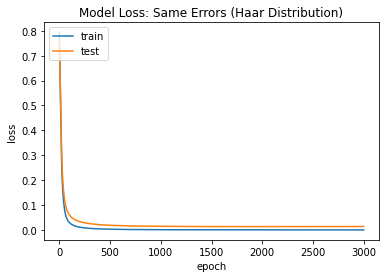

In [87]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Errors (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='yellow'>INF - 420 samples</font>

In [88]:
x_train_list = vectors_with_noise[:420]
y_train_list = vectors_noise_free[:420]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[600:700]
y_val_list = vectors_noise_free[600:700]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[700:]
y_test_list = vectors_noise_free[700:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [89]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=infidelity2)

In [90]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=84, epochs=3000)

Epoch 1/3000
5/5 [==============================] - 1s 47ms/step - loss: 0.7214 - val_loss: 0.7176
Epoch 2/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.6906 - val_loss: 0.6917
Epoch 3/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.6597 - val_loss: 0.6648
Epoch 4/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.6278 - val_loss: 0.6366
Epoch 5/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.5950 - val_loss: 0.6064
Epoch 6/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.5612 - val_loss: 0.5752
Epoch 7/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.5277 - val_loss: 0.5427
Epoch 8/3000
5/5 [==============================] - 0s 14ms/step - loss: 0.4922 - val_loss: 0.5096
Epoch 9/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.4588 - val_loss: 0.4763
Epoch 10/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.4252 - val_loss: 0.4435
Epoch 11/

5/5 [==============================] - 0s 11ms/step - loss: 0.0245 - val_loss: 0.0343
Epoch 84/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0241 - val_loss: 0.0338
Epoch 85/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0237 - val_loss: 0.0333
Epoch 86/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0233 - val_loss: 0.0330
Epoch 87/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0229 - val_loss: 0.0325
Epoch 88/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0226 - val_loss: 0.0321
Epoch 89/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0222 - val_loss: 0.0316
Epoch 90/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0219 - val_loss: 0.0313
Epoch 91/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0216 - val_loss: 0.0309
Epoch 92/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0212 - val_loss: 0.0305
Epoch 93/3000


5/5 [==============================] - 0s 10ms/step - loss: 0.0097 - val_loss: 0.0168
Epoch 165/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0097 - val_loss: 0.0167
Epoch 166/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0096 - val_loss: 0.0166
Epoch 167/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0095 - val_loss: 0.0165
Epoch 168/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0094 - val_loss: 0.0164
Epoch 169/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0094 - val_loss: 0.0163
Epoch 170/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0093 - val_loss: 0.0162
Epoch 171/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0092 - val_loss: 0.0161
Epoch 172/3000
5/5 [==============================] - 0s 15ms/step - loss: 0.0091 - val_loss: 0.0160
Epoch 173/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0091 - val_loss: 0.0160
Epoch

5/5 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0115
Epoch 246/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0115
Epoch 247/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0114
Epoch 248/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 249/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0114
Epoch 250/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0113
Epoch 251/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.0113
Epoch 252/3000
5/5 [==============================] - 0s 15ms/step - loss: 0.0055 - val_loss: 0.0113
Epoch 253/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0112
Epoch 254/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0055 - val_loss: 0.0112
Epoch

5/5 [==============================] - 0s 11ms/step - loss: 0.0040 - val_loss: 0.0090
Epoch 327/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0090
Epoch 328/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0089
Epoch 329/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0089
Epoch 330/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0039 - val_loss: 0.0089
Epoch 331/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0039 - val_loss: 0.0089
Epoch 332/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0039 - val_loss: 0.0088
Epoch 333/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch 334/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch 335/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0038 - val_loss: 0.0088
Epoch

5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 408/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 409/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 410/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 411/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 412/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 413/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0074
Epoch 414/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 415/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 416/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0028 - val_loss: 0.0073
Epoch

5/5 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 489/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 490/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 491/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 492/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 493/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 494/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 495/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 496/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0063
Epoch 497/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch

5/5 [==============================] - 0s 10ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 570/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0055
Epoch 571/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 572/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 573/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 574/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 575/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 576/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 577/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 578/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch

5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 651/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 652/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 653/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 654/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 655/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 656/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 657/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 658/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch 659/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0048
Epoch

5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 732/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 733/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 734/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 735/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 736/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 737/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 738/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 739/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 740/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch

5/5 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 813/3000
5/5 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 814/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0042
Epoch 815/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 816/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 817/3000
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 818/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 819/3000
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 820/3000
5/5 [==============================] - 0s 14ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 821/3000
5/5 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch

5/5 [==============================] - 0s 12ms/step - loss: 9.9362e-04 - val_loss: 0.0039
Epoch 894/3000
5/5 [==============================] - 0s 10ms/step - loss: 9.9010e-04 - val_loss: 0.0039
Epoch 895/3000
5/5 [==============================] - 0s 10ms/step - loss: 9.9711e-04 - val_loss: 0.0039
Epoch 896/3000
5/5 [==============================] - 0s 10ms/step - loss: 9.9575e-04 - val_loss: 0.0039
Epoch 897/3000
5/5 [==============================] - 0s 10ms/step - loss: 9.9935e-04 - val_loss: 0.0039
Epoch 898/3000
5/5 [==============================] - 0s 11ms/step - loss: 9.9530e-04 - val_loss: 0.0039
Epoch 899/3000
5/5 [==============================] - 0s 10ms/step - loss: 9.8468e-04 - val_loss: 0.0039
Epoch 900/3000
5/5 [==============================] - 0s 11ms/step - loss: 9.8614e-04 - val_loss: 0.0038
Epoch 901/3000
5/5 [==============================] - 0s 11ms/step - loss: 9.8187e-04 - val_loss: 0.0039
Epoch 902/3000
5/5 [==============================] - 0s 10ms/step - l

5/5 [==============================] - 0s 11ms/step - loss: 8.8375e-04 - val_loss: 0.0036
Epoch 972/3000
5/5 [==============================] - 0s 14ms/step - loss: 8.9571e-04 - val_loss: 0.0037
Epoch 973/3000
5/5 [==============================] - 0s 13ms/step - loss: 8.9337e-04 - val_loss: 0.0036
Epoch 974/3000
5/5 [==============================] - 0s 10ms/step - loss: 8.8413e-04 - val_loss: 0.0037
Epoch 975/3000
5/5 [==============================] - 0s 10ms/step - loss: 8.7727e-04 - val_loss: 0.0036
Epoch 976/3000
5/5 [==============================] - 0s 10ms/step - loss: 8.7445e-04 - val_loss: 0.0036
Epoch 977/3000
5/5 [==============================] - 0s 10ms/step - loss: 8.7980e-04 - val_loss: 0.0036
Epoch 978/3000
5/5 [==============================] - 0s 11ms/step - loss: 8.7741e-04 - val_loss: 0.0036
Epoch 979/3000
5/5 [==============================] - 0s 10ms/step - loss: 8.7536e-04 - val_loss: 0.0036
Epoch 980/3000
5/5 [==============================] - 0s 10ms/step - l

5/5 [==============================] - 0s 10ms/step - loss: 7.8605e-04 - val_loss: 0.0035
Epoch 1049/3000
5/5 [==============================] - 0s 10ms/step - loss: 7.8518e-04 - val_loss: 0.0034
Epoch 1050/3000
5/5 [==============================] - 0s 10ms/step - loss: 7.8691e-04 - val_loss: 0.0034
Epoch 1051/3000
5/5 [==============================] - 0s 10ms/step - loss: 7.9285e-04 - val_loss: 0.0034
Epoch 1052/3000
5/5 [==============================] - 0s 11ms/step - loss: 7.8465e-04 - val_loss: 0.0034
Epoch 1053/3000
5/5 [==============================] - 0s 10ms/step - loss: 7.7885e-04 - val_loss: 0.0034
Epoch 1054/3000
5/5 [==============================] - 0s 11ms/step - loss: 7.7892e-04 - val_loss: 0.0034
Epoch 1055/3000
5/5 [==============================] - 0s 11ms/step - loss: 7.7290e-04 - val_loss: 0.0034
Epoch 1056/3000
5/5 [==============================] - 0s 11ms/step - loss: 7.6877e-04 - val_loss: 0.0034
Epoch 1057/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 10ms/step - loss: 7.1067e-04 - val_loss: 0.0032
Epoch 1126/3000
5/5 [==============================] - 0s 11ms/step - loss: 7.0526e-04 - val_loss: 0.0032
Epoch 1127/3000
5/5 [==============================] - 0s 10ms/step - loss: 6.9976e-04 - val_loss: 0.0033
Epoch 1128/3000
5/5 [==============================] - 0s 10ms/step - loss: 6.9418e-04 - val_loss: 0.0032
Epoch 1129/3000
5/5 [==============================] - 0s 12ms/step - loss: 6.9351e-04 - val_loss: 0.0032
Epoch 1130/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.9559e-04 - val_loss: 0.0032
Epoch 1131/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.9342e-04 - val_loss: 0.0032
Epoch 1132/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.9484e-04 - val_loss: 0.0032
Epoch 1133/3000
5/5 [==============================] - 0s 10ms/step - loss: 6.9553e-04 - val_loss: 0.0032
Epoch 1134/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 6.3483e-04 - val_loss: 0.0031
Epoch 1203/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.3343e-04 - val_loss: 0.0031
Epoch 1204/3000
5/5 [==============================] - 0s 12ms/step - loss: 6.3769e-04 - val_loss: 0.0031
Epoch 1205/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.3139e-04 - val_loss: 0.0031
Epoch 1206/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.2854e-04 - val_loss: 0.0031
Epoch 1207/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.2374e-04 - val_loss: 0.0031
Epoch 1208/3000
5/5 [==============================] - 0s 11ms/step - loss: 6.2680e-04 - val_loss: 0.0031
Epoch 1209/3000
5/5 [==============================] - 0s 12ms/step - loss: 6.2441e-04 - val_loss: 0.0031
Epoch 1210/3000
5/5 [==============================] - 0s 10ms/step - loss: 6.2324e-04 - val_loss: 0.0031
Epoch 1211/3000
5/5 [==============================] - 0s 12ms

5/5 [==============================] - 0s 11ms/step - loss: 5.6791e-04 - val_loss: 0.0029
Epoch 1280/3000
5/5 [==============================] - 0s 12ms/step - loss: 5.7101e-04 - val_loss: 0.0030
Epoch 1281/3000
5/5 [==============================] - 0s 12ms/step - loss: 5.6988e-04 - val_loss: 0.0029
Epoch 1282/3000
5/5 [==============================] - 0s 11ms/step - loss: 5.6289e-04 - val_loss: 0.0030
Epoch 1283/3000
5/5 [==============================] - 0s 11ms/step - loss: 5.6234e-04 - val_loss: 0.0029
Epoch 1284/3000
5/5 [==============================] - 0s 12ms/step - loss: 5.5878e-04 - val_loss: 0.0029
Epoch 1285/3000
5/5 [==============================] - 0s 11ms/step - loss: 5.6178e-04 - val_loss: 0.0029
Epoch 1286/3000
5/5 [==============================] - 0s 11ms/step - loss: 5.6082e-04 - val_loss: 0.0029
Epoch 1287/3000
5/5 [==============================] - 0s 12ms/step - loss: 5.5942e-04 - val_loss: 0.0029
Epoch 1288/3000
5/5 [==============================] - 0s 14ms

5/5 [==============================] - 0s 10ms/step - loss: 5.1912e-04 - val_loss: 0.0028
Epoch 1357/3000
5/5 [==============================] - 0s 10ms/step - loss: 5.1704e-04 - val_loss: 0.0028
Epoch 1358/3000
5/5 [==============================] - 0s 12ms/step - loss: 5.1440e-04 - val_loss: 0.0028
Epoch 1359/3000
5/5 [==============================] - 0s 11ms/step - loss: 5.1747e-04 - val_loss: 0.0028
Epoch 1360/3000
5/5 [==============================] - 0s 10ms/step - loss: 5.1882e-04 - val_loss: 0.0028
Epoch 1361/3000
5/5 [==============================] - 0s 12ms/step - loss: 5.1280e-04 - val_loss: 0.0028
Epoch 1362/3000
5/5 [==============================] - 0s 11ms/step - loss: 5.1189e-04 - val_loss: 0.0028
Epoch 1363/3000
5/5 [==============================] - 0s 10ms/step - loss: 5.1074e-04 - val_loss: 0.0028
Epoch 1364/3000
5/5 [==============================] - 0s 11ms/step - loss: 5.0918e-04 - val_loss: 0.0028
Epoch 1365/3000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 10ms/step - loss: 4.6940e-04 - val_loss: 0.0027
Epoch 1434/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.6679e-04 - val_loss: 0.0027
Epoch 1435/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.6703e-04 - val_loss: 0.0027
Epoch 1436/3000
5/5 [==============================] - 0s 11ms/step - loss: 4.6648e-04 - val_loss: 0.0027
Epoch 1437/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.7214e-04 - val_loss: 0.0027
Epoch 1438/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.7224e-04 - val_loss: 0.0027
Epoch 1439/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.6817e-04 - val_loss: 0.0027
Epoch 1440/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.6756e-04 - val_loss: 0.0026
Epoch 1441/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.6486e-04 - val_loss: 0.0027
Epoch 1442/3000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 11ms/step - loss: 4.4062e-04 - val_loss: 0.0025
Epoch 1511/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.3462e-04 - val_loss: 0.0026
Epoch 1512/3000
5/5 [==============================] - 0s 11ms/step - loss: 4.3568e-04 - val_loss: 0.0025
Epoch 1513/3000
5/5 [==============================] - 0s 11ms/step - loss: 4.2859e-04 - val_loss: 0.0025
Epoch 1514/3000
5/5 [==============================] - 0s 12ms/step - loss: 4.3167e-04 - val_loss: 0.0026
Epoch 1515/3000
5/5 [==============================] - 0s 11ms/step - loss: 4.2920e-04 - val_loss: 0.0025
Epoch 1516/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.2325e-04 - val_loss: 0.0026
Epoch 1517/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.3476e-04 - val_loss: 0.0026
Epoch 1518/3000
5/5 [==============================] - 0s 10ms/step - loss: 4.3440e-04 - val_loss: 0.0025
Epoch 1519/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 3.9607e-04 - val_loss: 0.0024
Epoch 1588/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.9504e-04 - val_loss: 0.0025
Epoch 1589/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.9456e-04 - val_loss: 0.0024
Epoch 1590/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.9441e-04 - val_loss: 0.0024
Epoch 1591/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.9397e-04 - val_loss: 0.0024
Epoch 1592/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.9546e-04 - val_loss: 0.0024
Epoch 1593/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.9163e-04 - val_loss: 0.0024
Epoch 1594/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.9289e-04 - val_loss: 0.0024
Epoch 1595/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.9193e-04 - val_loss: 0.0024
Epoch 1596/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 3.6590e-04 - val_loss: 0.0024
Epoch 1665/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.6289e-04 - val_loss: 0.0024
Epoch 1666/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.6294e-04 - val_loss: 0.0024
Epoch 1667/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.6681e-04 - val_loss: 0.0024
Epoch 1668/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.6640e-04 - val_loss: 0.0023
Epoch 1669/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.7078e-04 - val_loss: 0.0023
Epoch 1670/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.6756e-04 - val_loss: 0.0023
Epoch 1671/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.6620e-04 - val_loss: 0.0024
Epoch 1672/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.6329e-04 - val_loss: 0.0023
Epoch 1673/3000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 11ms/step - loss: 3.4040e-04 - val_loss: 0.0023
Epoch 1742/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.3524e-04 - val_loss: 0.0023
Epoch 1743/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.3866e-04 - val_loss: 0.0023
Epoch 1744/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.3822e-04 - val_loss: 0.0023
Epoch 1745/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.3485e-04 - val_loss: 0.0023
Epoch 1746/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.3480e-04 - val_loss: 0.0023
Epoch 1747/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.3350e-04 - val_loss: 0.0023
Epoch 1748/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.3331e-04 - val_loss: 0.0023
Epoch 1749/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.3563e-04 - val_loss: 0.0023
Epoch 1750/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 12ms/step - loss: 3.2246e-04 - val_loss: 0.0022
Epoch 1819/3000
5/5 [==============================] - 0s 13ms/step - loss: 3.1932e-04 - val_loss: 0.0022
Epoch 1820/3000
5/5 [==============================] - 0s 13ms/step - loss: 3.2148e-04 - val_loss: 0.0022
Epoch 1821/3000
5/5 [==============================] - 0s 14ms/step - loss: 3.2377e-04 - val_loss: 0.0022
Epoch 1822/3000
5/5 [==============================] - 0s 13ms/step - loss: 3.2032e-04 - val_loss: 0.0022
Epoch 1823/3000
5/5 [==============================] - 0s 14ms/step - loss: 3.2253e-04 - val_loss: 0.0022
Epoch 1824/3000
5/5 [==============================] - 0s 14ms/step - loss: 3.1942e-04 - val_loss: 0.0022
Epoch 1825/3000
5/5 [==============================] - 0s 12ms/step - loss: 3.1361e-04 - val_loss: 0.0022
Epoch 1826/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.1313e-04 - val_loss: 0.0022
Epoch 1827/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 3.0220e-04 - val_loss: 0.0021
Epoch 1896/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.0039e-04 - val_loss: 0.0022
Epoch 1897/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.0212e-04 - val_loss: 0.0021
Epoch 1898/3000
5/5 [==============================] - 0s 11ms/step - loss: 3.0360e-04 - val_loss: 0.0021
Epoch 1899/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.0636e-04 - val_loss: 0.0022
Epoch 1900/3000
5/5 [==============================] - 0s 10ms/step - loss: 3.0285e-04 - val_loss: 0.0021
Epoch 1901/3000
5/5 [==============================] - 0s 13ms/step - loss: 3.0360e-04 - val_loss: 0.0022
Epoch 1902/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.9860e-04 - val_loss: 0.0021
Epoch 1903/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.9777e-04 - val_loss: 0.0022
Epoch 1904/3000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 11ms/step - loss: 2.7559e-04 - val_loss: 0.0021
Epoch 1973/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7388e-04 - val_loss: 0.0021
Epoch 1974/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7456e-04 - val_loss: 0.0021
Epoch 1975/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7784e-04 - val_loss: 0.0021
Epoch 1976/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7794e-04 - val_loss: 0.0021
Epoch 1977/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7717e-04 - val_loss: 0.0021
Epoch 1978/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7474e-04 - val_loss: 0.0021
Epoch 1979/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7162e-04 - val_loss: 0.0021
Epoch 1980/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.7385e-04 - val_loss: 0.0021
Epoch 1981/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 2.6341e-04 - val_loss: 0.0020
Epoch 2050/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.6174e-04 - val_loss: 0.0020
Epoch 2051/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6253e-04 - val_loss: 0.0020
Epoch 2052/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6195e-04 - val_loss: 0.0020
Epoch 2053/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.5886e-04 - val_loss: 0.0020
Epoch 2054/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.5924e-04 - val_loss: 0.0020
Epoch 2055/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.5772e-04 - val_loss: 0.0020
Epoch 2056/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6191e-04 - val_loss: 0.0020
Epoch 2057/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.6483e-04 - val_loss: 0.0020
Epoch 2058/3000
5/5 [==============================] - 0s 12ms

5/5 [==============================] - 0s 11ms/step - loss: 2.4565e-04 - val_loss: 0.0020
Epoch 2127/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.4555e-04 - val_loss: 0.0020
Epoch 2128/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.4185e-04 - val_loss: 0.0020
Epoch 2129/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.4175e-04 - val_loss: 0.0020
Epoch 2130/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.4631e-04 - val_loss: 0.0020
Epoch 2131/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.4995e-04 - val_loss: 0.0020
Epoch 2132/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.4757e-04 - val_loss: 0.0020
Epoch 2133/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.4288e-04 - val_loss: 0.0020
Epoch 2134/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.4218e-04 - val_loss: 0.0020
Epoch 2135/3000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 10ms/step - loss: 2.3306e-04 - val_loss: 0.0019
Epoch 2204/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.3147e-04 - val_loss: 0.0019
Epoch 2205/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.2940e-04 - val_loss: 0.0019
Epoch 2206/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.2835e-04 - val_loss: 0.0019
Epoch 2207/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.3490e-04 - val_loss: 0.0019
Epoch 2208/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.3614e-04 - val_loss: 0.0019
Epoch 2209/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.3552e-04 - val_loss: 0.0019
Epoch 2210/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.3113e-04 - val_loss: 0.0019
Epoch 2211/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.3247e-04 - val_loss: 0.0019
Epoch 2212/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 10ms/step - loss: 2.1849e-04 - val_loss: 0.0019
Epoch 2281/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.2637e-04 - val_loss: 0.0019
Epoch 2282/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.2138e-04 - val_loss: 0.0019
Epoch 2283/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.1977e-04 - val_loss: 0.0019
Epoch 2284/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.1942e-04 - val_loss: 0.0019
Epoch 2285/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.2001e-04 - val_loss: 0.0019
Epoch 2286/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.1910e-04 - val_loss: 0.0019
Epoch 2287/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.1593e-04 - val_loss: 0.0019
Epoch 2288/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.1676e-04 - val_loss: 0.0019
Epoch 2289/3000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 11ms/step - loss: 2.0798e-04 - val_loss: 0.0018
Epoch 2358/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.0809e-04 - val_loss: 0.0018
Epoch 2359/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.0993e-04 - val_loss: 0.0018
Epoch 2360/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.0723e-04 - val_loss: 0.0018
Epoch 2361/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.0613e-04 - val_loss: 0.0018
Epoch 2362/3000
5/5 [==============================] - 0s 11ms/step - loss: 2.0698e-04 - val_loss: 0.0018
Epoch 2363/3000
5/5 [==============================] - 0s 10ms/step - loss: 2.0866e-04 - val_loss: 0.0018
Epoch 2364/3000
5/5 [==============================] - 0s 13ms/step - loss: 2.0862e-04 - val_loss: 0.0018
Epoch 2365/3000
5/5 [==============================] - 0s 12ms/step - loss: 2.1055e-04 - val_loss: 0.0018
Epoch 2366/3000
5/5 [==============================] - 0s 12ms

5/5 [==============================] - 0s 10ms/step - loss: 1.9573e-04 - val_loss: 0.0018
Epoch 2435/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9437e-04 - val_loss: 0.0018
Epoch 2436/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9515e-04 - val_loss: 0.0018
Epoch 2437/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9687e-04 - val_loss: 0.0018
Epoch 2438/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9503e-04 - val_loss: 0.0018
Epoch 2439/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9746e-04 - val_loss: 0.0018
Epoch 2440/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.9702e-04 - val_loss: 0.0018
Epoch 2441/3000
5/5 [==============================] - 0s 15ms/step - loss: 1.9654e-04 - val_loss: 0.0018
Epoch 2442/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9761e-04 - val_loss: 0.0018
Epoch 2443/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 1.9269e-04 - val_loss: 0.0018
Epoch 2512/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9310e-04 - val_loss: 0.0018
Epoch 2513/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.8920e-04 - val_loss: 0.0017
Epoch 2514/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9222e-04 - val_loss: 0.0018
Epoch 2515/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9379e-04 - val_loss: 0.0018
Epoch 2516/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9544e-04 - val_loss: 0.0018
Epoch 2517/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9046e-04 - val_loss: 0.0018
Epoch 2518/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9298e-04 - val_loss: 0.0018
Epoch 2519/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.9363e-04 - val_loss: 0.0018
Epoch 2520/3000
5/5 [==============================] - 0s 11ms

5/5 [==============================] - 0s 11ms/step - loss: 1.8340e-04 - val_loss: 0.0017
Epoch 2589/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7839e-04 - val_loss: 0.0017
Epoch 2590/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7806e-04 - val_loss: 0.0017
Epoch 2591/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7770e-04 - val_loss: 0.0017
Epoch 2592/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7933e-04 - val_loss: 0.0017
Epoch 2593/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.7782e-04 - val_loss: 0.0017
Epoch 2594/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7710e-04 - val_loss: 0.0017
Epoch 2595/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7593e-04 - val_loss: 0.0017
Epoch 2596/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7863e-04 - val_loss: 0.0017
Epoch 2597/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 10ms/step - loss: 1.7521e-04 - val_loss: 0.0017
Epoch 2666/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7761e-04 - val_loss: 0.0017
Epoch 2667/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7790e-04 - val_loss: 0.0017
Epoch 2668/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.8385e-04 - val_loss: 0.0017
Epoch 2669/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.8140e-04 - val_loss: 0.0017
Epoch 2670/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.7396e-04 - val_loss: 0.0017
Epoch 2671/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7514e-04 - val_loss: 0.0017
Epoch 2672/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7279e-04 - val_loss: 0.0017
Epoch 2673/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.7303e-04 - val_loss: 0.0017
Epoch 2674/3000
5/5 [==============================] - 0s 12ms

5/5 [==============================] - 0s 10ms/step - loss: 1.6816e-04 - val_loss: 0.0017
Epoch 2743/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6995e-04 - val_loss: 0.0017
Epoch 2744/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6669e-04 - val_loss: 0.0017
Epoch 2745/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6749e-04 - val_loss: 0.0017
Epoch 2746/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6647e-04 - val_loss: 0.0017
Epoch 2747/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6871e-04 - val_loss: 0.0017
Epoch 2748/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6703e-04 - val_loss: 0.0017
Epoch 2749/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6681e-04 - val_loss: 0.0017
Epoch 2750/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6551e-04 - val_loss: 0.0016
Epoch 2751/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 10ms/step - loss: 1.6070e-04 - val_loss: 0.0016
Epoch 2820/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6078e-04 - val_loss: 0.0016
Epoch 2821/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5985e-04 - val_loss: 0.0016
Epoch 2822/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6236e-04 - val_loss: 0.0016
Epoch 2823/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6140e-04 - val_loss: 0.0016
Epoch 2824/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6348e-04 - val_loss: 0.0016
Epoch 2825/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6305e-04 - val_loss: 0.0016
Epoch 2826/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.6671e-04 - val_loss: 0.0016
Epoch 2827/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6323e-04 - val_loss: 0.0016
Epoch 2828/3000
5/5 [==============================] - 0s 12ms

5/5 [==============================] - 0s 10ms/step - loss: 1.5229e-04 - val_loss: 0.0016
Epoch 2897/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5366e-04 - val_loss: 0.0016
Epoch 2898/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5368e-04 - val_loss: 0.0016
Epoch 2899/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5414e-04 - val_loss: 0.0016
Epoch 2900/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5574e-04 - val_loss: 0.0016
Epoch 2901/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.6117e-04 - val_loss: 0.0016
Epoch 2902/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5521e-04 - val_loss: 0.0016
Epoch 2903/3000
5/5 [==============================] - 0s 10ms/step - loss: 1.5350e-04 - val_loss: 0.0016
Epoch 2904/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5307e-04 - val_loss: 0.0016
Epoch 2905/3000
5/5 [==============================] - 0s 10ms

5/5 [==============================] - 0s 11ms/step - loss: 1.5311e-04 - val_loss: 0.0016
Epoch 2974/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5469e-04 - val_loss: 0.0016
Epoch 2975/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.5194e-04 - val_loss: 0.0016
Epoch 2976/3000
5/5 [==============================] - 0s 12ms/step - loss: 1.5248e-04 - val_loss: 0.0016
Epoch 2977/3000
5/5 [==============================] - 0s 14ms/step - loss: 1.5034e-04 - val_loss: 0.0016
Epoch 2978/3000
5/5 [==============================] - 0s 13ms/step - loss: 1.4715e-04 - val_loss: 0.0016
Epoch 2979/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4864e-04 - val_loss: 0.0016
Epoch 2980/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4902e-04 - val_loss: 0.0016
Epoch 2981/3000
5/5 [==============================] - 0s 11ms/step - loss: 1.4665e-04 - val_loss: 0.0016
Epoch 2982/3000
5/5 [==============================] - 0s 11ms

In [91]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.0015 - 36ms/epoch - 9ms/step


In [92]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test, x_test)



inft420 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.9985386+4.9476512e-12j), shape=(), dtype=complex64)
tf.Tensor((0.7096527+0j), shape=(), dtype=complex64)


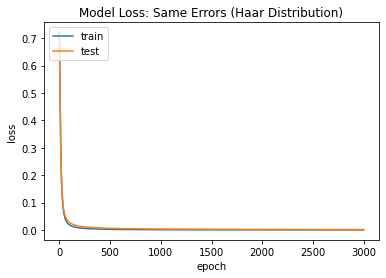

In [93]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Errors (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='yellow'>INF - 160 samples</font>

In [94]:
x_train_list = vectors_with_noise[:160]
y_train_list = vectors_noise_free[:160]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = vectors_with_noise[600:700]
y_val_list = vectors_noise_free[600:700]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = vectors_with_noise[700:]
y_test_list = vectors_noise_free[700:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [95]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

# Compile model
adam_opt = tf.optimizers.Adam(0.0003)
model.compile(optimizer=adam_opt,
              loss=infidelity2)

In [96]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=40, epochs=3000)

Epoch 1/3000
4/4 [==============================] - 1s 65ms/step - loss: 0.7342 - val_loss: 0.7384
Epoch 2/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.7109 - val_loss: 0.7194
Epoch 3/3000
4/4 [==============================] - 0s 18ms/step - loss: 0.6880 - val_loss: 0.7005
Epoch 4/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.6659 - val_loss: 0.6818
Epoch 5/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.6437 - val_loss: 0.6624
Epoch 6/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.6207 - val_loss: 0.6431
Epoch 7/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.5976 - val_loss: 0.6232
Epoch 8/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.5738 - val_loss: 0.6032
Epoch 9/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.5495 - val_loss: 0.5828
Epoch 10/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.5258 - val_loss: 0.5621
Epoch 11/

4/4 [==============================] - 0s 17ms/step - loss: 0.0393 - val_loss: 0.0931
Epoch 84/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0386 - val_loss: 0.0921
Epoch 85/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0379 - val_loss: 0.0911
Epoch 86/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0372 - val_loss: 0.0903
Epoch 87/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0366 - val_loss: 0.0894
Epoch 88/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0359 - val_loss: 0.0888
Epoch 89/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0353 - val_loss: 0.0879
Epoch 90/3000
4/4 [==============================] - 0s 18ms/step - loss: 0.0347 - val_loss: 0.0872
Epoch 91/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0341 - val_loss: 0.0865
Epoch 92/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0335 - val_loss: 0.0858
Epoch 93/3000


4/4 [==============================] - 0s 15ms/step - loss: 0.0136 - val_loss: 0.0577
Epoch 165/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0134 - val_loss: 0.0575
Epoch 166/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0133 - val_loss: 0.0574
Epoch 167/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0132 - val_loss: 0.0572
Epoch 168/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0131 - val_loss: 0.0570
Epoch 169/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0129 - val_loss: 0.0567
Epoch 170/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0128 - val_loss: 0.0566
Epoch 171/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0127 - val_loss: 0.0564
Epoch 172/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0126 - val_loss: 0.0563
Epoch 173/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0125 - val_loss: 0.0562
Epoch

4/4 [==============================] - 0s 16ms/step - loss: 0.0072 - val_loss: 0.0477
Epoch 246/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0.0476
Epoch 247/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0474
Epoch 248/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0071 - val_loss: 0.0474
Epoch 249/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0070 - val_loss: 0.0473
Epoch 250/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0472
Epoch 251/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0069 - val_loss: 0.0471
Epoch 252/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 0.0471
Epoch 253/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0069 - val_loss: 0.0470
Epoch 254/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0470
Epoch

4/4 [==============================] - 0s 17ms/step - loss: 0.0045 - val_loss: 0.0426
Epoch 327/3000
4/4 [==============================] - 0s 19ms/step - loss: 0.0045 - val_loss: 0.0426
Epoch 328/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0425
Epoch 329/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0044 - val_loss: 0.0425
Epoch 330/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0425
Epoch 331/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0044 - val_loss: 0.0424
Epoch 332/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0424
Epoch 333/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0423
Epoch 334/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0422
Epoch 335/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0043 - val_loss: 0.0422
Epoch

4/4 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0395
Epoch 408/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0030 - val_loss: 0.0394
Epoch 409/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0030 - val_loss: 0.0394
Epoch 410/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0394
Epoch 411/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0393
Epoch 412/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0393
Epoch 413/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0030 - val_loss: 0.0393
Epoch 414/3000
4/4 [==============================] - 0s 13ms/step - loss: 0.0029 - val_loss: 0.0393
Epoch 415/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0392
Epoch 416/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0392
Epoch

4/4 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0372
Epoch 489/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0372
Epoch 490/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0372
Epoch 491/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0372
Epoch 492/3000
4/4 [==============================] - 0s 19ms/step - loss: 0.0021 - val_loss: 0.0372
Epoch 493/3000
4/4 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0371
Epoch 494/3000
4/4 [==============================] - 0s 14ms/step - loss: 0.0021 - val_loss: 0.0371
Epoch 495/3000
4/4 [==============================] - 0s 25ms/step - loss: 0.0021 - val_loss: 0.0371
Epoch 496/3000
4/4 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 0.0371
Epoch 497/3000
4/4 [==============================] - 0s 26ms/step - loss: 0.0021 - val_loss: 0.0371
Epoch

4/4 [==============================] - 0s 21ms/step - loss: 0.0016 - val_loss: 0.0357
Epoch 570/3000
4/4 [==============================] - 0s 23ms/step - loss: 0.0016 - val_loss: 0.0356
Epoch 571/3000
4/4 [==============================] - 0s 21ms/step - loss: 0.0016 - val_loss: 0.0357
Epoch 572/3000
4/4 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0357
Epoch 573/3000
4/4 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0356
Epoch 574/3000
4/4 [==============================] - 0s 25ms/step - loss: 0.0015 - val_loss: 0.0355
Epoch 575/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0357
Epoch 576/3000
4/4 [==============================] - 0s 29ms/step - loss: 0.0015 - val_loss: 0.0356
Epoch 577/3000
4/4 [==============================] - 0s 26ms/step - loss: 0.0015 - val_loss: 0.0355
Epoch 578/3000
4/4 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0356
Epoch

4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0346
Epoch 651/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0345
Epoch 652/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0345
Epoch 653/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0012 - val_loss: 0.0346
Epoch 654/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0345
Epoch 655/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0345
Epoch 656/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0345
Epoch 657/3000
4/4 [==============================] - 0s 15ms/step - loss: 0.0011 - val_loss: 0.0345
Epoch 658/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0345
Epoch 659/3000
4/4 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0345
Epoch

Epoch 730/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.7078e-04 - val_loss: 0.0339
Epoch 731/3000
4/4 [==============================] - 0s 14ms/step - loss: 8.6935e-04 - val_loss: 0.0338
Epoch 732/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.7090e-04 - val_loss: 0.0338
Epoch 733/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.6255e-04 - val_loss: 0.0338
Epoch 734/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.6035e-04 - val_loss: 0.0339
Epoch 735/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.5806e-04 - val_loss: 0.0338
Epoch 736/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.5815e-04 - val_loss: 0.0338
Epoch 737/3000
4/4 [==============================] - 0s 16ms/step - loss: 8.5669e-04 - val_loss: 0.0338
Epoch 738/3000
4/4 [==============================] - 0s 18ms/step - loss: 8.5168e-04 - val_loss: 0.0338
Epoch 739/3000
4/4 [==============================] - 0

4/4 [==============================] - 0s 18ms/step - loss: 6.5914e-04 - val_loss: 0.0334
Epoch 809/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.6035e-04 - val_loss: 0.0335
Epoch 810/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.5551e-04 - val_loss: 0.0334
Epoch 811/3000
4/4 [==============================] - 0s 16ms/step - loss: 6.5065e-04 - val_loss: 0.0334
Epoch 812/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.5111e-04 - val_loss: 0.0334
Epoch 813/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.4851e-04 - val_loss: 0.0334
Epoch 814/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.4687e-04 - val_loss: 0.0335
Epoch 815/3000
4/4 [==============================] - 0s 17ms/step - loss: 6.4315e-04 - val_loss: 0.0334
Epoch 816/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.4483e-04 - val_loss: 0.0334
Epoch 817/3000
4/4 [==============================] - 0s 15ms/step - l

4/4 [==============================] - 0s 15ms/step - loss: 5.0121e-04 - val_loss: 0.0332
Epoch 887/3000
4/4 [==============================] - 0s 15ms/step - loss: 5.0067e-04 - val_loss: 0.0332
Epoch 888/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.9833e-04 - val_loss: 0.0332
Epoch 889/3000
4/4 [==============================] - 0s 15ms/step - loss: 4.9791e-04 - val_loss: 0.0332
Epoch 890/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.9936e-04 - val_loss: 0.0333
Epoch 891/3000
4/4 [==============================] - 0s 15ms/step - loss: 4.9212e-04 - val_loss: 0.0332
Epoch 892/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.9061e-04 - val_loss: 0.0332
Epoch 893/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.8699e-04 - val_loss: 0.0332
Epoch 894/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.8814e-04 - val_loss: 0.0332
Epoch 895/3000
4/4 [==============================] - 0s 16ms/step - l

4/4 [==============================] - 0s 15ms/step - loss: 3.8661e-04 - val_loss: 0.0330
Epoch 965/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.8066e-04 - val_loss: 0.0330
Epoch 966/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.7909e-04 - val_loss: 0.0330
Epoch 967/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.7843e-04 - val_loss: 0.0330
Epoch 968/3000
4/4 [==============================] - 0s 28ms/step - loss: 3.7834e-04 - val_loss: 0.0330
Epoch 969/3000
4/4 [==============================] - 0s 26ms/step - loss: 3.7545e-04 - val_loss: 0.0330
Epoch 970/3000
4/4 [==============================] - 0s 21ms/step - loss: 3.7524e-04 - val_loss: 0.0330
Epoch 971/3000
4/4 [==============================] - 0s 20ms/step - loss: 3.7340e-04 - val_loss: 0.0330
Epoch 972/3000
4/4 [==============================] - 0s 18ms/step - loss: 3.7415e-04 - val_loss: 0.0330
Epoch 973/3000
4/4 [==============================] - 0s 23ms/step - l

Epoch 1042/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.9058e-04 - val_loss: 0.0329
Epoch 1043/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.9086e-04 - val_loss: 0.0329
Epoch 1044/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.8870e-04 - val_loss: 0.0329
Epoch 1045/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.9174e-04 - val_loss: 0.0329
Epoch 1046/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.8940e-04 - val_loss: 0.0329
Epoch 1047/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.8559e-04 - val_loss: 0.0329
Epoch 1048/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.8737e-04 - val_loss: 0.0329
Epoch 1049/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.8361e-04 - val_loss: 0.0329
Epoch 1050/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.8266e-04 - val_loss: 0.0329
Epoch 1051/3000
4/4 [=========================

4/4 [==============================] - 0s 17ms/step - loss: 2.2583e-04 - val_loss: 0.0328
Epoch 1120/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.2367e-04 - val_loss: 0.0328
Epoch 1121/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.2084e-04 - val_loss: 0.0328
Epoch 1122/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.2170e-04 - val_loss: 0.0328
Epoch 1123/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.2156e-04 - val_loss: 0.0327
Epoch 1124/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.1945e-04 - val_loss: 0.0328
Epoch 1125/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.2199e-04 - val_loss: 0.0328
Epoch 1126/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.1856e-04 - val_loss: 0.0328
Epoch 1127/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.1907e-04 - val_loss: 0.0328
Epoch 1128/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 14ms/step - loss: 1.7322e-04 - val_loss: 0.0327
Epoch 1197/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.7427e-04 - val_loss: 0.0327
Epoch 1198/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.7145e-04 - val_loss: 0.0327
Epoch 1199/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.7434e-04 - val_loss: 0.0327
Epoch 1200/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.7128e-04 - val_loss: 0.0327
Epoch 1201/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.6901e-04 - val_loss: 0.0327
Epoch 1202/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.7062e-04 - val_loss: 0.0327
Epoch 1203/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.6933e-04 - val_loss: 0.0327
Epoch 1204/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.6839e-04 - val_loss: 0.0327
Epoch 1205/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 14ms/step - loss: 1.3196e-04 - val_loss: 0.0327
Epoch 1274/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3179e-04 - val_loss: 0.0327
Epoch 1275/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3016e-04 - val_loss: 0.0327
Epoch 1276/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3083e-04 - val_loss: 0.0327
Epoch 1277/3000
4/4 [==============================] - 0s 13ms/step - loss: 1.3141e-04 - val_loss: 0.0327
Epoch 1278/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3076e-04 - val_loss: 0.0327
Epoch 1279/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3139e-04 - val_loss: 0.0327
Epoch 1280/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.2673e-04 - val_loss: 0.0327
Epoch 1281/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.2904e-04 - val_loss: 0.0326
Epoch 1282/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 1.0033e-04 - val_loss: 0.0327
Epoch 1351/3000
4/4 [==============================] - 0s 17ms/step - loss: 9.9948e-05 - val_loss: 0.0327
Epoch 1352/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.8944e-05 - val_loss: 0.0327
Epoch 1353/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.7258e-05 - val_loss: 0.0327
Epoch 1354/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.7538e-05 - val_loss: 0.0327
Epoch 1355/3000
4/4 [==============================] - 0s 15ms/step - loss: 9.8541e-05 - val_loss: 0.0327
Epoch 1356/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.9083e-05 - val_loss: 0.0327
Epoch 1357/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.6463e-05 - val_loss: 0.0326
Epoch 1358/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.6913e-05 - val_loss: 0.0328
Epoch 1359/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 14ms/step - loss: 7.6844e-05 - val_loss: 0.0327
Epoch 1428/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.5044e-05 - val_loss: 0.0327
Epoch 1429/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.5940e-05 - val_loss: 0.0327
Epoch 1430/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.4459e-05 - val_loss: 0.0328
Epoch 1431/3000
4/4 [==============================] - 0s 13ms/step - loss: 7.6484e-05 - val_loss: 0.0327
Epoch 1432/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.4993e-05 - val_loss: 0.0327
Epoch 1433/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.5456e-05 - val_loss: 0.0327
Epoch 1434/3000
4/4 [==============================] - 0s 15ms/step - loss: 7.4702e-05 - val_loss: 0.0327
Epoch 1435/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.4264e-05 - val_loss: 0.0328
Epoch 1436/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 15ms/step - loss: 5.7065e-05 - val_loss: 0.0328
Epoch 1505/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.5308e-05 - val_loss: 0.0328
Epoch 1506/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.4595e-05 - val_loss: 0.0328
Epoch 1507/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.5511e-05 - val_loss: 0.0327
Epoch 1508/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.5644e-05 - val_loss: 0.0328
Epoch 1509/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.5769e-05 - val_loss: 0.0328
Epoch 1510/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.5815e-05 - val_loss: 0.0328
Epoch 1511/3000
4/4 [==============================] - 0s 15ms/step - loss: 5.6309e-05 - val_loss: 0.0328
Epoch 1512/3000
4/4 [==============================] - 0s 14ms/step - loss: 5.5500e-05 - val_loss: 0.0328
Epoch 1513/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 4.3118e-05 - val_loss: 0.0328
Epoch 1582/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.2871e-05 - val_loss: 0.0328
Epoch 1583/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.3006e-05 - val_loss: 0.0329
Epoch 1584/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.2256e-05 - val_loss: 0.0328
Epoch 1585/3000
4/4 [==============================] - 0s 13ms/step - loss: 4.1177e-05 - val_loss: 0.0329
Epoch 1586/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.1379e-05 - val_loss: 0.0328
Epoch 1587/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.1083e-05 - val_loss: 0.0329
Epoch 1588/3000
4/4 [==============================] - 0s 15ms/step - loss: 4.0580e-05 - val_loss: 0.0328
Epoch 1589/3000
4/4 [==============================] - 0s 14ms/step - loss: 4.1519e-05 - val_loss: 0.0329
Epoch 1590/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 14ms/step - loss: 3.3974e-05 - val_loss: 0.0329
Epoch 1659/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.3212e-05 - val_loss: 0.0329
Epoch 1660/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.1858e-05 - val_loss: 0.0329
Epoch 1661/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.1618e-05 - val_loss: 0.0330
Epoch 1662/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.1864e-05 - val_loss: 0.0329
Epoch 1663/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.0940e-05 - val_loss: 0.0330
Epoch 1664/3000
4/4 [==============================] - 0s 15ms/step - loss: 3.1137e-05 - val_loss: 0.0329
Epoch 1665/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.0066e-05 - val_loss: 0.0330
Epoch 1666/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.8977e-05 - val_loss: 0.0329
Epoch 1667/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 2.3897e-05 - val_loss: 0.0330
Epoch 1736/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.3646e-05 - val_loss: 0.0330
Epoch 1737/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.4052e-05 - val_loss: 0.0330
Epoch 1738/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.4876e-05 - val_loss: 0.0331
Epoch 1739/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.4096e-05 - val_loss: 0.0330
Epoch 1740/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.3079e-05 - val_loss: 0.0330
Epoch 1741/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.2368e-05 - val_loss: 0.0330
Epoch 1742/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.1591e-05 - val_loss: 0.0330
Epoch 1743/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.1329e-05 - val_loss: 0.0330
Epoch 1744/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 18ms/step - loss: 1.5986e-05 - val_loss: 0.0331
Epoch 1813/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.6490e-05 - val_loss: 0.0331
Epoch 1814/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.6480e-05 - val_loss: 0.0331
Epoch 1815/3000
4/4 [==============================] - 0s 16ms/step - loss: 1.5435e-05 - val_loss: 0.0331
Epoch 1816/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.6443e-05 - val_loss: 0.0331
Epoch 1817/3000
4/4 [==============================] - 0s 16ms/step - loss: 1.7387e-05 - val_loss: 0.0331
Epoch 1818/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.8121e-05 - val_loss: 0.0331
Epoch 1819/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.7851e-05 - val_loss: 0.0331
Epoch 1820/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.8328e-05 - val_loss: 0.0331
Epoch 1821/3000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 14ms/step - loss: 1.3679e-05 - val_loss: 0.0332
Epoch 1890/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.3656e-05 - val_loss: 0.0332
Epoch 1891/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.4571e-05 - val_loss: 0.0332
Epoch 1892/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.2804e-05 - val_loss: 0.0331
Epoch 1893/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.2423e-05 - val_loss: 0.0331
Epoch 1894/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.2115e-05 - val_loss: 0.0331
Epoch 1895/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.2316e-05 - val_loss: 0.0332
Epoch 1896/3000
4/4 [==============================] - 0s 16ms/step - loss: 1.3332e-05 - val_loss: 0.0332
Epoch 1897/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.3500e-05 - val_loss: 0.0331
Epoch 1898/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 14ms/step - loss: 8.5223e-06 - val_loss: 0.0332
Epoch 1967/3000
4/4 [==============================] - 0s 13ms/step - loss: 8.5454e-06 - val_loss: 0.0332
Epoch 1968/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.8768e-06 - val_loss: 0.0332
Epoch 1969/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.8160e-06 - val_loss: 0.0332
Epoch 1970/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.1949e-06 - val_loss: 0.0332
Epoch 1971/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.6308e-06 - val_loss: 0.0332
Epoch 1972/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.2085e-06 - val_loss: 0.0332
Epoch 1973/3000
4/4 [==============================] - 0s 15ms/step - loss: 9.0886e-06 - val_loss: 0.0332
Epoch 1974/3000
4/4 [==============================] - 0s 14ms/step - loss: 9.0491e-06 - val_loss: 0.0332
Epoch 1975/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 14ms/step - loss: 7.3254e-06 - val_loss: 0.0333
Epoch 2044/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.1090e-06 - val_loss: 0.0333
Epoch 2045/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.7946e-06 - val_loss: 0.0333
Epoch 2046/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.8750e-06 - val_loss: 0.0332
Epoch 2047/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.4395e-06 - val_loss: 0.0332
Epoch 2048/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.3978e-06 - val_loss: 0.0333
Epoch 2049/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.7107e-06 - val_loss: 0.0333
Epoch 2050/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.3843e-06 - val_loss: 0.0333
Epoch 2051/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.8076e-06 - val_loss: 0.0333
Epoch 2052/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 17ms/step - loss: 9.2797e-06 - val_loss: 0.0333
Epoch 2121/3000
4/4 [==============================] - 0s 17ms/step - loss: 8.2567e-06 - val_loss: 0.0333
Epoch 2122/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.3258e-06 - val_loss: 0.0333
Epoch 2123/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.5066e-06 - val_loss: 0.0333
Epoch 2124/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.8832e-06 - val_loss: 0.0333
Epoch 2125/3000
4/4 [==============================] - 0s 14ms/step - loss: 7.0326e-06 - val_loss: 0.0333
Epoch 2126/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.7174e-06 - val_loss: 0.0332
Epoch 2127/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.1974e-06 - val_loss: 0.0332
Epoch 2128/3000
4/4 [==============================] - 0s 14ms/step - loss: 6.2976e-06 - val_loss: 0.0333
Epoch 2129/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 5.3704e-06 - val_loss: 0.0333
Epoch 2198/3000
4/4 [==============================] - 0s 15ms/step - loss: 5.5764e-06 - val_loss: 0.0333
Epoch 2199/3000
4/4 [==============================] - 0s 15ms/step - loss: 7.2256e-06 - val_loss: 0.0333
Epoch 2200/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.0055e-05 - val_loss: 0.0333
Epoch 2201/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3157e-05 - val_loss: 0.0333
Epoch 2202/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3743e-05 - val_loss: 0.0333
Epoch 2203/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3939e-05 - val_loss: 0.0332
Epoch 2204/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.4561e-05 - val_loss: 0.0332
Epoch 2205/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.6360e-05 - val_loss: 0.0333
Epoch 2206/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 15ms/step - loss: 2.4419e-06 - val_loss: 0.0332
Epoch 2275/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.5649e-06 - val_loss: 0.0332
Epoch 2276/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.4673e-06 - val_loss: 0.0331
Epoch 2277/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.4993e-06 - val_loss: 0.0331
Epoch 2278/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.1387e-06 - val_loss: 0.0332
Epoch 2279/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.2855e-06 - val_loss: 0.0332
Epoch 2280/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.6029e-06 - val_loss: 0.0332
Epoch 2281/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.2963e-06 - val_loss: 0.0332
Epoch 2282/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.1003e-06 - val_loss: 0.0332
Epoch 2283/3000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 16ms/step - loss: 1.2357e-06 - val_loss: 0.0332
Epoch 2352/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.1541e-06 - val_loss: 0.0332
Epoch 2353/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.2357e-06 - val_loss: 0.0332
Epoch 2354/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.3504e-06 - val_loss: 0.0332
Epoch 2355/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.2774e-06 - val_loss: 0.0332
Epoch 2356/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3184e-06 - val_loss: 0.0332
Epoch 2357/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.3065e-06 - val_loss: 0.0333
Epoch 2358/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.2454e-06 - val_loss: 0.0332
Epoch 2359/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.3124e-06 - val_loss: 0.0332
Epoch 2360/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 2.9989e-05 - val_loss: 0.0332
Epoch 2429/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.6206e-05 - val_loss: 0.0333
Epoch 2430/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.3305e-05 - val_loss: 0.0332
Epoch 2431/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.0508e-05 - val_loss: 0.0333
Epoch 2432/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.1113e-05 - val_loss: 0.0331
Epoch 2433/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.8019e-05 - val_loss: 0.0332
Epoch 2434/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.0038e-05 - val_loss: 0.0330
Epoch 2435/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.3839e-05 - val_loss: 0.0331
Epoch 2436/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.0546e-05 - val_loss: 0.0331
Epoch 2437/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 14ms/step - loss: 9.9689e-07 - val_loss: 0.0331
Epoch 2506/3000
4/4 [==============================] - 0s 23ms/step - loss: 9.1270e-07 - val_loss: 0.0331
Epoch 2507/3000
4/4 [==============================] - 0s 29ms/step - loss: 1.0502e-06 - val_loss: 0.0331
Epoch 2508/3000
4/4 [==============================] - 0s 27ms/step - loss: 9.5591e-07 - val_loss: 0.0331
Epoch 2509/3000
4/4 [==============================] - 0s 19ms/step - loss: 9.6150e-07 - val_loss: 0.0331
Epoch 2510/3000
4/4 [==============================] - 0s 20ms/step - loss: 9.4622e-07 - val_loss: 0.0331
Epoch 2511/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.0766e-06 - val_loss: 0.0331
Epoch 2512/3000
4/4 [==============================] - 0s 19ms/step - loss: 1.1507e-06 - val_loss: 0.0331
Epoch 2513/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.3255e-06 - val_loss: 0.0331
Epoch 2514/3000
4/4 [==============================] - 0s 24ms

4/4 [==============================] - 0s 15ms/step - loss: 5.4542e-05 - val_loss: 0.0331
Epoch 2583/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.4085e-05 - val_loss: 0.0333
Epoch 2584/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.7428e-05 - val_loss: 0.0331
Epoch 2585/3000
4/4 [==============================] - 0s 14ms/step - loss: 3.8124e-05 - val_loss: 0.0329
Epoch 2586/3000
4/4 [==============================] - 0s 13ms/step - loss: 2.7195e-05 - val_loss: 0.0330
Epoch 2587/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.9488e-05 - val_loss: 0.0330
Epoch 2588/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.9374e-05 - val_loss: 0.0329
Epoch 2589/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.6812e-05 - val_loss: 0.0330
Epoch 2590/3000
4/4 [==============================] - 0s 18ms/step - loss: 2.4452e-05 - val_loss: 0.0331
Epoch 2591/3000
4/4 [==============================] - 0s 15ms

4/4 [==============================] - 0s 14ms/step - loss: 1.7826e-06 - val_loss: 0.0330
Epoch 2660/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.8343e-06 - val_loss: 0.0330
Epoch 2661/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.9234e-06 - val_loss: 0.0330
Epoch 2662/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.7319e-06 - val_loss: 0.0330
Epoch 2663/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.6615e-06 - val_loss: 0.0330
Epoch 2664/3000
4/4 [==============================] - 0s 13ms/step - loss: 1.5043e-06 - val_loss: 0.0330
Epoch 2665/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.4413e-06 - val_loss: 0.0330
Epoch 2666/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.3869e-06 - val_loss: 0.0330
Epoch 2667/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.1701e-06 - val_loss: 0.0330
Epoch 2668/3000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 13ms/step - loss: 1.2357e-06 - val_loss: 0.0330
Epoch 2737/3000
4/4 [==============================] - 0s 13ms/step - loss: 1.4622e-06 - val_loss: 0.0330
Epoch 2738/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.4402e-06 - val_loss: 0.0330
Epoch 2739/3000
4/4 [==============================] - 0s 18ms/step - loss: 1.6455e-06 - val_loss: 0.0330
Epoch 2740/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.6000e-06 - val_loss: 0.0330
Epoch 2741/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.5512e-06 - val_loss: 0.0330
Epoch 2742/3000
4/4 [==============================] - 0s 16ms/step - loss: 1.3575e-06 - val_loss: 0.0330
Epoch 2743/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.2707e-06 - val_loss: 0.0330
Epoch 2744/3000
4/4 [==============================] - 0s 20ms/step - loss: 1.0960e-06 - val_loss: 0.0330
Epoch 2745/3000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 18ms/step - loss: 1.7622e-05 - val_loss: 0.0329
Epoch 2814/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.6505e-05 - val_loss: 0.0329
Epoch 2815/3000
4/4 [==============================] - 0s 14ms/step - loss: 1.6701e-05 - val_loss: 0.0329
Epoch 2816/3000
4/4 [==============================] - 0s 13ms/step - loss: 1.3494e-05 - val_loss: 0.0329
Epoch 2817/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.1548e-05 - val_loss: 0.0329
Epoch 2818/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.0273e-05 - val_loss: 0.0328
Epoch 2819/3000
4/4 [==============================] - 0s 17ms/step - loss: 1.0078e-05 - val_loss: 0.0328
Epoch 2820/3000
4/4 [==============================] - 0s 15ms/step - loss: 1.0064e-05 - val_loss: 0.0329
Epoch 2821/3000
4/4 [==============================] - 0s 15ms/step - loss: 8.1938e-06 - val_loss: 0.0328
Epoch 2822/3000
4/4 [==============================] - 0s 16ms

4/4 [==============================] - 0s 20ms/step - loss: 4.1053e-07 - val_loss: 0.0328
Epoch 2891/3000
4/4 [==============================] - 0s 17ms/step - loss: 4.7870e-07 - val_loss: 0.0328
Epoch 2892/3000
4/4 [==============================] - 0s 16ms/step - loss: 4.2096e-07 - val_loss: 0.0328
Epoch 2893/3000
4/4 [==============================] - 0s 15ms/step - loss: 3.9265e-07 - val_loss: 0.0328
Epoch 2894/3000
4/4 [==============================] - 0s 15ms/step - loss: 4.5337e-07 - val_loss: 0.0328
Epoch 2895/3000
4/4 [==============================] - 0s 17ms/step - loss: 5.6922e-07 - val_loss: 0.0328
Epoch 2896/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.9940e-07 - val_loss: 0.0328
Epoch 2897/3000
4/4 [==============================] - 0s 16ms/step - loss: 5.8599e-07 - val_loss: 0.0328
Epoch 2898/3000
4/4 [==============================] - 0s 15ms/step - loss: 6.9588e-07 - val_loss: 0.0328
Epoch 2899/3000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 14ms/step - loss: 2.1777e-05 - val_loss: 0.0328
Epoch 2968/3000
4/4 [==============================] - 0s 14ms/step - loss: 2.1142e-05 - val_loss: 0.0326
Epoch 2969/3000
4/4 [==============================] - 0s 15ms/step - loss: 2.5735e-05 - val_loss: 0.0328
Epoch 2970/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.7750e-05 - val_loss: 0.0327
Epoch 2971/3000
4/4 [==============================] - 0s 16ms/step - loss: 2.8278e-05 - val_loss: 0.0329
Epoch 2972/3000
4/4 [==============================] - 0s 17ms/step - loss: 2.7708e-05 - val_loss: 0.0327
Epoch 2973/3000
4/4 [==============================] - 0s 17ms/step - loss: 3.6042e-05 - val_loss: 0.0329
Epoch 2974/3000
4/4 [==============================] - 0s 16ms/step - loss: 3.6692e-05 - val_loss: 0.0326
Epoch 2975/3000
4/4 [==============================] - 0s 15ms/step - loss: 3.9233e-05 - val_loss: 0.0328
Epoch 2976/3000
4/4 [==============================] - 0s 14ms

In [97]:
score = model.evaluate(x_test,  y_test, verbose=2)

4/4 - 0s - loss: 0.0314 - 35ms/epoch - 9ms/step


In [98]:
#save the model predictions in a tensor
y_prediction = model(x_test)

y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)
fidn = fid_twoq(y_test, x_test)



inft160 = tf.math.reduce_mean(fid)
print(tf.math.reduce_mean(fid))
print(tf.math.reduce_mean(fidn))

tf.Tensor((0.9685851+1.44355e-10j), shape=(), dtype=complex64)
tf.Tensor((0.7096527+0j), shape=(), dtype=complex64)


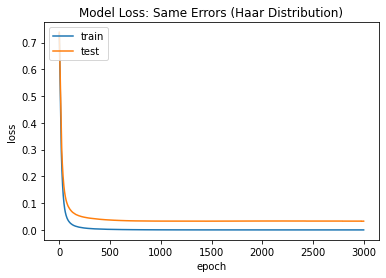

In [99]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Same Errors (Haar Distribution)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='brown'>Plotting the Results</font>

In [100]:
x = np.array([40, 80, 160, 240, 420])
y = np.array([tm40, tm80, tm160, tm240, tm420])
z = np.array([inft40, inft80, inft160, inft240, inft420])

C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


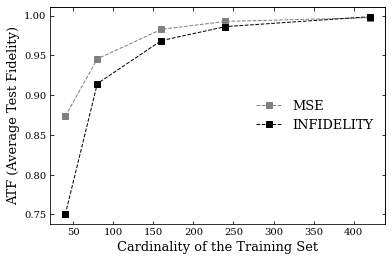

In [101]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')

plt.figure(figsize = (6,4))
plt.plot(x, y, label='MSE', color='0.50', ls='dashed', marker='s', linewidth=1)
plt.plot(x, z, label='INFIDELITY', color='k', ls='dashed', marker='s', linewidth=1)
ax = plt.subplot()

plt.xlabel("Cardinality of the Training Set", fontsize=13) 
plt.ylabel("ATF (Average Test Fidelity)", fontsize=13)
leg = plt.legend(fontsize=13, loc='center right', frameon='False')

secax = ax.secondary_xaxis('top')
secay = ax.secondary_yaxis('right')
ax.tick_params(axis="both", direction='in')
secax.tick_params(axis="x", direction="in")
secay.tick_params(axis="y", direction="in")
secax.set_xticklabels([])
secay.set_yticklabels([])


leg.get_frame().set_linewidth(0.0)

plt.savefig("md_tq.png")